In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.sig0  = qnn.QuantSigmoid(bit_width=4, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.sig1  = qnn.QuantSigmoid(bit_width=4, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.sig2  = qnn.QuantSigmoid(bit_width=4, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.sig0(self.bn0(self.fc0(out))))
        out = self.drop1(self.sig1(self.bn1(self.fc1(out))))
        out = self.drop2(self.sig2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3603, Acc: 0.8912 | Val Loss: 0.2094, Acc: 0.9371


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1551, Acc: 0.9537 | Val Loss: 0.1673, Acc: 0.9491


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9659 | Val Loss: 0.1357, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9747 | Val Loss: 0.1296, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9785 | Val Loss: 0.1080, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 0.1439, Acc: 0.9602


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1328, Acc: 0.9651


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.1147, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1211, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.1142, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1068, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.1104, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1160, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1441, Acc: 0.9706


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1167, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1316, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.1232, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1077, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.1163, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1304, Acc: 0.9697


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1194, Acc: 0.9712


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1115, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.1322, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1284, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1277, Acc: 0.9753


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9945 | Val Loss: 0.1520, Acc: 0.9687


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1159, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1635, Acc: 0.9669


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1371, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9949 | Val Loss: 0.1032, Acc: 0.9737


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1321, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1111, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1689, Acc: 0.9676


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1317, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1113, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1868, Acc: 0.9700


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1595, Acc: 0.9688


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1106, Acc: 0.9750


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1265, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1427, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1084, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1366, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1339, Acc: 0.9723


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1803, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1641, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1571, Acc: 0.9710


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1536, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1402, Acc: 0.9741


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1222, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1348, Acc: 0.9759


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1295, Acc: 0.9731


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1684, Acc: 0.9739


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9743


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1446, Acc: 0.9702


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1753, Acc: 0.9749


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1677, Acc: 0.9762


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1542, Acc: 0.9770


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1708, Acc: 0.9738


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1177, Acc: 0.9736


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1406, Acc: 0.9748


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1844, Acc: 0.9750


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1670, Acc: 0.9742


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1157, Acc: 0.9763


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1608, Acc: 0.9745


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1477, Acc: 0.9742


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1585, Acc: 0.9744


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1554, Acc: 0.9732


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1211, Acc: 0.9735


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1513, Acc: 0.9752


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1581, Acc: 0.9736


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1623, Acc: 0.9758


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1035, Acc: 0.9739


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1713, Acc: 0.9754


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1385, Acc: 0.9730


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1506, Acc: 0.9757


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1252, Acc: 0.9767


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1334, Acc: 0.9752


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1619, Acc: 0.9743


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1325, Acc: 0.9758


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1716, Acc: 0.9759


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1826, Acc: 0.9720


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1334, Acc: 0.9759


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1491, Acc: 0.9761


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1758, Acc: 0.9752


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1326, Acc: 0.9742


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1515, Acc: 0.9742


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.2294, Acc: 0.9740


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1397, Acc: 0.9774


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.2324, Acc: 0.9687


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1730, Acc: 0.9742


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1606, Acc: 0.9767


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1375, Acc: 0.9755


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1665, Acc: 0.9762


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.2057, Acc: 0.9751


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1500, Acc: 0.9757


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1074, Acc: 0.9744


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.2099, Acc: 0.9738


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1880, Acc: 0.9736


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.2221, Acc: 0.9700


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1746, Acc: 0.9740


Final Test Loss: 0.1619 Accuracy: 0.9779


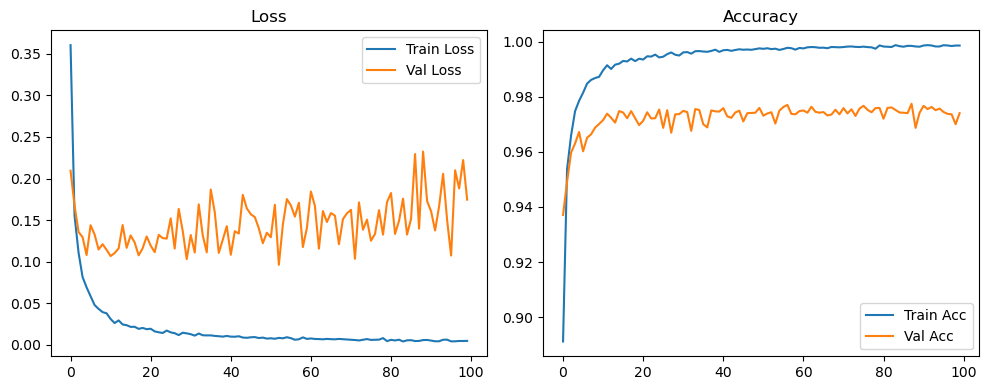

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4622, Acc: 0.8593 | Val Loss: 0.2354, Acc: 0.9276


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2586, Acc: 0.9233 | Val Loss: 0.1646, Acc: 0.9504


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1975, Acc: 0.9401 | Val Loss: 0.1466, Acc: 0.9579


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9520 | Val Loss: 0.1199, Acc: 0.9647


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9597 | Val Loss: 0.1116, Acc: 0.9678


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9636 | Val Loss: 0.1090, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9668 | Val Loss: 0.1101, Acc: 0.9673


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9723 | Val Loss: 0.1095, Acc: 0.9666


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9736 | Val Loss: 0.1122, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9739 | Val Loss: 0.0947, Acc: 0.9727


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9770 | Val Loss: 0.0984, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.0931, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9789 | Val Loss: 0.0967, Acc: 0.9734


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9817 | Val Loss: 0.1006, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9813 | Val Loss: 0.0993, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9831 | Val Loss: 0.1003, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.1119, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9837 | Val Loss: 0.0953, Acc: 0.9747


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.0939, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 0.0892, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.1052, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 0.1049, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9866 | Val Loss: 0.0967, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9873 | Val Loss: 0.1052, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0909, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.1062, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9884 | Val Loss: 0.0838, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1074, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0891, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.0993, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0846, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9896 | Val Loss: 0.1118, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0930, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0938, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0893, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0995, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9907 | Val Loss: 0.0928, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1099, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0851, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.0881, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.1025, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0987, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1047, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0778, Acc: 0.9787


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1012, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0970, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1191, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.1088, Acc: 0.9766


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1021, Acc: 0.9766


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1016, Acc: 0.9764


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1008, Acc: 0.9760


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.1120, Acc: 0.9768


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.1151, Acc: 0.9769


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.0920, Acc: 0.9772


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0953, Acc: 0.9786


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0960, Acc: 0.9781


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9939 | Val Loss: 0.1085, Acc: 0.9778


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0868, Acc: 0.9776


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1205, Acc: 0.9760


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.1138, Acc: 0.9773


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9937 | Val Loss: 0.0904, Acc: 0.9766


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.1053, Acc: 0.9774


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0980, Acc: 0.9788


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1181, Acc: 0.9760


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.1162, Acc: 0.9772


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9942 | Val Loss: 0.0856, Acc: 0.9772


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0852, Acc: 0.9777


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0975, Acc: 0.9772


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1119, Acc: 0.9785


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9948 | Val Loss: 0.1285, Acc: 0.9769


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0981, Acc: 0.9774


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1008, Acc: 0.9765


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0807, Acc: 0.9777


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0968, Acc: 0.9765


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.1050, Acc: 0.9784


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0848, Acc: 0.9773


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1086, Acc: 0.9771


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1324, Acc: 0.9766


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1265, Acc: 0.9776


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1310, Acc: 0.9773


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1204, Acc: 0.9780


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1053, Acc: 0.9775


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.1152, Acc: 0.9779


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1082, Acc: 0.9776


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1315, Acc: 0.9772


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1102, Acc: 0.9780


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1207, Acc: 0.9778


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1218, Acc: 0.9773


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1001, Acc: 0.9791


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1295, Acc: 0.9784


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1307, Acc: 0.9765


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1246, Acc: 0.9777


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1290, Acc: 0.9778


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1035, Acc: 0.9787


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1254, Acc: 0.9781


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1105, Acc: 0.9773


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.0987, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1074, Acc: 0.9778


Final Test Loss: 0.0950 Accuracy: 0.9809


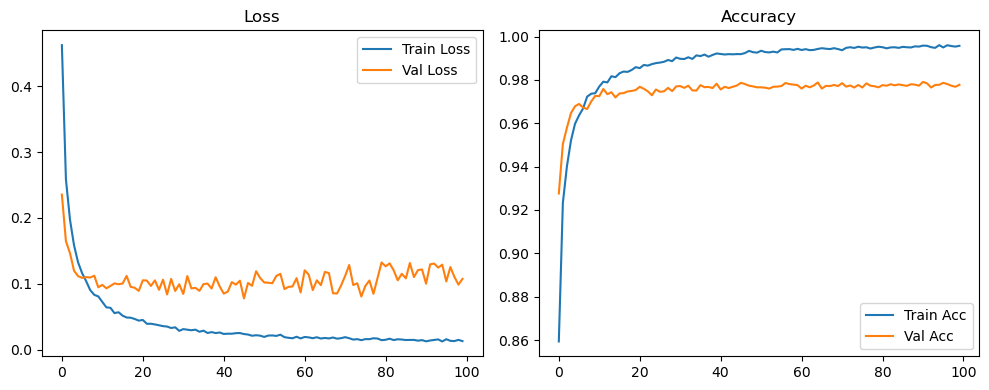

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6721, Acc: 0.7865 | Val Loss: 0.2961, Acc: 0.9132


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3956, Acc: 0.8828 | Val Loss: 0.2161, Acc: 0.9357


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3183, Acc: 0.9055 | Val Loss: 0.1908, Acc: 0.9428


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2727, Acc: 0.9193 | Val Loss: 0.1538, Acc: 0.9524


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2398, Acc: 0.9285 | Val Loss: 0.1355, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9361 | Val Loss: 0.1313, Acc: 0.9596


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1982, Acc: 0.9409 | Val Loss: 0.1208, Acc: 0.9625


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9455 | Val Loss: 0.1131, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9468 | Val Loss: 0.1117, Acc: 0.9668


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9490 | Val Loss: 0.1054, Acc: 0.9683


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9502 | Val Loss: 0.1055, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1002, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9545 | Val Loss: 0.1001, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9558 | Val Loss: 0.1037, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9574 | Val Loss: 0.0977, Acc: 0.9725


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9598 | Val Loss: 0.0963, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9600 | Val Loss: 0.0951, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9614 | Val Loss: 0.1004, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9616 | Val Loss: 0.0944, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9623 | Val Loss: 0.0908, Acc: 0.9744


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9633 | Val Loss: 0.0886, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9645 | Val Loss: 0.0888, Acc: 0.9727


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9656 | Val Loss: 0.0865, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9654 | Val Loss: 0.0983, Acc: 0.9718


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9655 | Val Loss: 0.0890, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.0858, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9668 | Val Loss: 0.0914, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1036, Acc: 0.9679 | Val Loss: 0.0891, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9697 | Val Loss: 0.0870, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9690 | Val Loss: 0.0957, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0968, Acc: 0.9697 | Val Loss: 0.0866, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9704 | Val Loss: 0.0878, Acc: 0.9759


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0967, Acc: 0.9695 | Val Loss: 0.0893, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9711 | Val Loss: 0.0894, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0864, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9705 | Val Loss: 0.0831, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9714 | Val Loss: 0.0867, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9735 | Val Loss: 0.0873, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9726 | Val Loss: 0.0965, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9742 | Val Loss: 0.0843, Acc: 0.9752


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9743 | Val Loss: 0.0979, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9741 | Val Loss: 0.0870, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9739 | Val Loss: 0.0903, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9750 | Val Loss: 0.0850, Acc: 0.9742


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.0882, Acc: 0.9754


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9748 | Val Loss: 0.0901, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9752 | Val Loss: 0.0864, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9759 | Val Loss: 0.0894, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9754 | Val Loss: 0.0850, Acc: 0.9753


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9761 | Val Loss: 0.0842, Acc: 0.9758


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9755 | Val Loss: 0.0901, Acc: 0.9758


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9757 | Val Loss: 0.0841, Acc: 0.9754


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9760 | Val Loss: 0.0790, Acc: 0.9762


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9760 | Val Loss: 0.0862, Acc: 0.9768


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9780 | Val Loss: 0.0781, Acc: 0.9760


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9775 | Val Loss: 0.0819, Acc: 0.9758


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9781 | Val Loss: 0.0932, Acc: 0.9762


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9783 | Val Loss: 0.0836, Acc: 0.9776


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9779 | Val Loss: 0.0763, Acc: 0.9769


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9784 | Val Loss: 0.0827, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9788 | Val Loss: 0.0867, Acc: 0.9762


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9792 | Val Loss: 0.0834, Acc: 0.9764


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9796 | Val Loss: 0.0994, Acc: 0.9759


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9787 | Val Loss: 0.0839, Acc: 0.9757


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0812, Acc: 0.9765


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9795 | Val Loss: 0.0893, Acc: 0.9766


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9782 | Val Loss: 0.0946, Acc: 0.9762


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9774 | Val Loss: 0.0873, Acc: 0.9767


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9798 | Val Loss: 0.0870, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9795 | Val Loss: 0.0881, Acc: 0.9777


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9804 | Val Loss: 0.0836, Acc: 0.9764


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9809 | Val Loss: 0.1024, Acc: 0.9771


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9790 | Val Loss: 0.0809, Acc: 0.9760


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9809 | Val Loss: 0.0833, Acc: 0.9775


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9800 | Val Loss: 0.0875, Acc: 0.9778


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9811 | Val Loss: 0.0880, Acc: 0.9770


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9796 | Val Loss: 0.0813, Acc: 0.9767


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9801 | Val Loss: 0.0918, Acc: 0.9771


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9808 | Val Loss: 0.0923, Acc: 0.9769


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9818 | Val Loss: 0.0939, Acc: 0.9761


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9797 | Val Loss: 0.0917, Acc: 0.9759


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9802 | Val Loss: 0.0899, Acc: 0.9770


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9821 | Val Loss: 0.0928, Acc: 0.9780


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9807 | Val Loss: 0.0868, Acc: 0.9757


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9808 | Val Loss: 0.0806, Acc: 0.9761


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9812 | Val Loss: 0.0928, Acc: 0.9768


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9824 | Val Loss: 0.0827, Acc: 0.9777


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9818 | Val Loss: 0.0931, Acc: 0.9764


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9820 | Val Loss: 0.0866, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 0.0840, Acc: 0.9780


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9815 | Val Loss: 0.0962, Acc: 0.9762


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9815 | Val Loss: 0.0984, Acc: 0.9774


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9823 | Val Loss: 0.0869, Acc: 0.9764


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9827 | Val Loss: 0.0821, Acc: 0.9763


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9821 | Val Loss: 0.0830, Acc: 0.9768


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9830 | Val Loss: 0.1022, Acc: 0.9757


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9831 | Val Loss: 0.1033, Acc: 0.9776


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9814 | Val Loss: 0.0894, Acc: 0.9752


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9821 | Val Loss: 0.0985, Acc: 0.9771


Final Test Loss: 0.0807 Accuracy: 0.9816


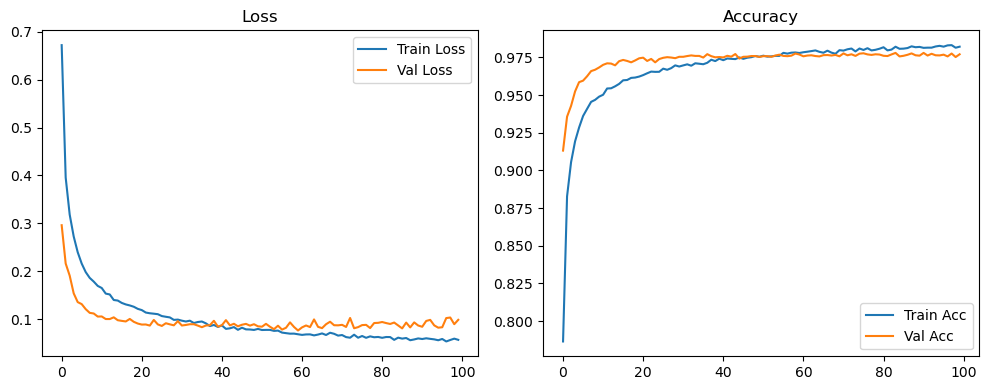

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3603, Acc: 0.8912 | Val Loss: 0.2094, Acc: 0.9371


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1551, Acc: 0.9537 | Val Loss: 0.1673, Acc: 0.9491


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9659 | Val Loss: 0.1357, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9747 | Val Loss: 0.1296, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9785 | Val Loss: 0.1080, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 0.1439, Acc: 0.9602


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1328, Acc: 0.9651


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.1147, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1211, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.1142, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1068, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.1104, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1160, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1441, Acc: 0.9706


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1167, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1316, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.1232, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1077, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.1163, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1304, Acc: 0.9697


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1194, Acc: 0.9712


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1115, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.1322, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1284, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1277, Acc: 0.9753


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9945 | Val Loss: 0.1520, Acc: 0.9687


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1159, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1635, Acc: 0.9669


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1371, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9949 | Val Loss: 0.1032, Acc: 0.9737


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1321, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1111, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1689, Acc: 0.9676


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1317, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1113, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1868, Acc: 0.9700


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1595, Acc: 0.9688


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1106, Acc: 0.9750


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1265, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1427, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1084, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1366, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1339, Acc: 0.9723


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1803, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1641, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1571, Acc: 0.9710


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1536, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1402, Acc: 0.9741


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1222, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1348, Acc: 0.9759


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1267, Acc: 0.9763


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1452, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1156, Acc: 0.9766


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1381, Acc: 0.9777


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1722, Acc: 0.9753


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1483, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1433, Acc: 0.9776


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1344, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1729, Acc: 0.9767


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1450, Acc: 0.9770


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1695, Acc: 0.9748


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1535, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1485, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1188, Acc: 0.9774


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0995, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1641, Acc: 0.9787


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1435, Acc: 0.9770


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1747, Acc: 0.9767


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1868, Acc: 0.9770


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1864, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1765, Acc: 0.9751


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1805, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1680, Acc: 0.9771


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1661, Acc: 0.9772


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1318, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1507, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1334, Acc: 0.9765


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1584, Acc: 0.9772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1507, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1444, Acc: 0.9793


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1728, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1408, Acc: 0.9797


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1631, Acc: 0.9797


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1431, Acc: 0.9787


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1485, Acc: 0.9784


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2118, Acc: 0.9780


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1591, Acc: 0.9785


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1648, Acc: 0.9790


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2100, Acc: 0.9791


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1950, Acc: 0.9793


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1870, Acc: 0.9786


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1537, Acc: 0.9782


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2169, Acc: 0.9781


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2084, Acc: 0.9792


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1554, Acc: 0.9789


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1771, Acc: 0.9790


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1433, Acc: 0.9781


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1722, Acc: 0.9790


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1937, Acc: 0.9788


Final Test Loss: 0.1629 Accuracy: 0.9814


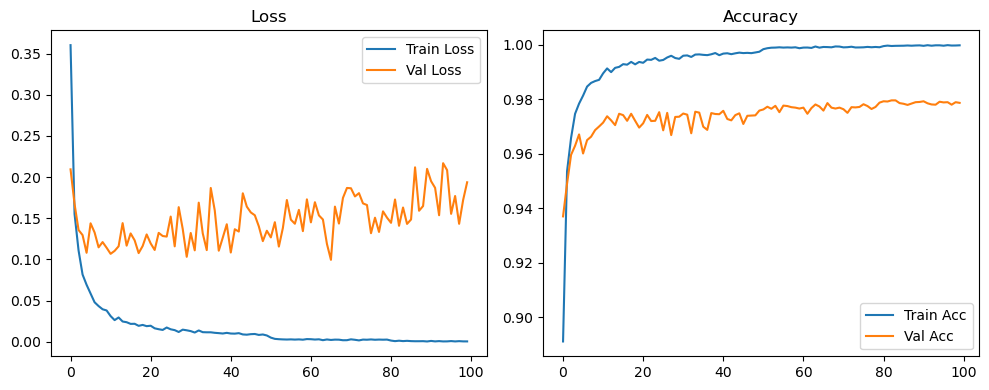

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4622, Acc: 0.8593 | Val Loss: 0.2354, Acc: 0.9276


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2586, Acc: 0.9233 | Val Loss: 0.1646, Acc: 0.9504


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1975, Acc: 0.9401 | Val Loss: 0.1466, Acc: 0.9579


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9520 | Val Loss: 0.1199, Acc: 0.9647


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9597 | Val Loss: 0.1116, Acc: 0.9678


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9636 | Val Loss: 0.1090, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9668 | Val Loss: 0.1101, Acc: 0.9673


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9723 | Val Loss: 0.1095, Acc: 0.9666


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9736 | Val Loss: 0.1122, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9739 | Val Loss: 0.0947, Acc: 0.9727


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9770 | Val Loss: 0.0984, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.0931, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9789 | Val Loss: 0.0967, Acc: 0.9734


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9817 | Val Loss: 0.1006, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9813 | Val Loss: 0.0993, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9831 | Val Loss: 0.1003, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.1119, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9837 | Val Loss: 0.0953, Acc: 0.9747


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.0939, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 0.0892, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.1052, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 0.1049, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9866 | Val Loss: 0.0967, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9873 | Val Loss: 0.1052, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0909, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.1062, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9884 | Val Loss: 0.0838, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1074, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0891, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.0993, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0846, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9896 | Val Loss: 0.1118, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0930, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0938, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0893, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0995, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9907 | Val Loss: 0.0928, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1099, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0851, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.0881, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.1025, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0987, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1047, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0778, Acc: 0.9787


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1012, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0970, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1191, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.1088, Acc: 0.9766


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0842, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0966, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0970, Acc: 0.9782


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0910, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1013, Acc: 0.9785


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0990, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1130, Acc: 0.9794


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1149, Acc: 0.9787


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1184, Acc: 0.9779


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1019, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1170, Acc: 0.9783


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1034, Acc: 0.9796


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1014, Acc: 0.9797


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0917, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1169, Acc: 0.9779


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1255, Acc: 0.9784


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1069, Acc: 0.9784


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0982, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1168, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0750, Acc: 0.9796


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1283, Acc: 0.9795


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1297, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0978, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1177, Acc: 0.9787


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1101, Acc: 0.9783


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0904, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1078, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1047, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1188, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1270, Acc: 0.9791


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1086, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1135, Acc: 0.9802


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1171, Acc: 0.9797


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1079, Acc: 0.9807


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1141, Acc: 0.9794


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1088, Acc: 0.9798


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1182, Acc: 0.9793


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1169, Acc: 0.9800


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1192, Acc: 0.9795


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1116, Acc: 0.9805


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1290, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1167, Acc: 0.9802


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1224, Acc: 0.9801


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1072, Acc: 0.9791


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1377, Acc: 0.9793


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1229, Acc: 0.9797


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1292, Acc: 0.9794


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1164, Acc: 0.9793


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1162, Acc: 0.9797


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1249, Acc: 0.9802


Final Test Loss: 0.1111 Accuracy: 0.9825


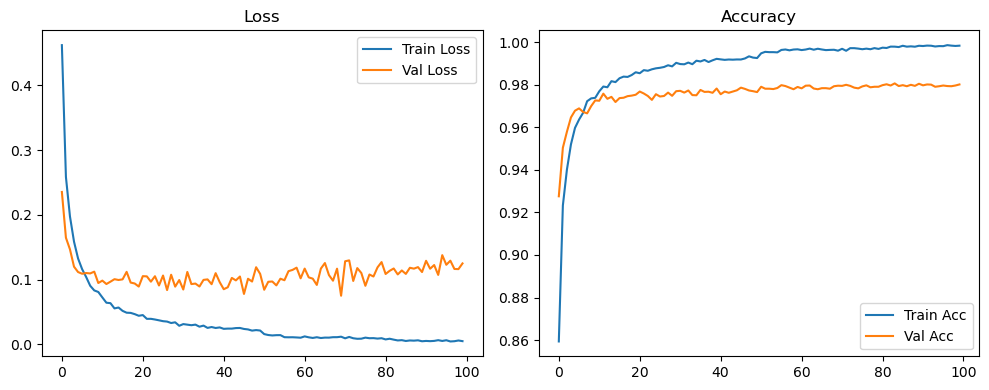

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6721, Acc: 0.7865 | Val Loss: 0.2961, Acc: 0.9132


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3956, Acc: 0.8828 | Val Loss: 0.2161, Acc: 0.9357


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3183, Acc: 0.9055 | Val Loss: 0.1908, Acc: 0.9428


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2727, Acc: 0.9193 | Val Loss: 0.1538, Acc: 0.9524


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2398, Acc: 0.9285 | Val Loss: 0.1355, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9361 | Val Loss: 0.1313, Acc: 0.9596


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1982, Acc: 0.9409 | Val Loss: 0.1208, Acc: 0.9625


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9455 | Val Loss: 0.1131, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9468 | Val Loss: 0.1117, Acc: 0.9668


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9490 | Val Loss: 0.1054, Acc: 0.9683


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9502 | Val Loss: 0.1055, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1002, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9545 | Val Loss: 0.1001, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9558 | Val Loss: 0.1037, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9574 | Val Loss: 0.0977, Acc: 0.9725


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9598 | Val Loss: 0.0963, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9600 | Val Loss: 0.0951, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9614 | Val Loss: 0.1004, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9616 | Val Loss: 0.0944, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9623 | Val Loss: 0.0908, Acc: 0.9744


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9633 | Val Loss: 0.0886, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9645 | Val Loss: 0.0888, Acc: 0.9727


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9656 | Val Loss: 0.0865, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9654 | Val Loss: 0.0983, Acc: 0.9718


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9655 | Val Loss: 0.0890, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.0858, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9668 | Val Loss: 0.0914, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1036, Acc: 0.9679 | Val Loss: 0.0891, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9697 | Val Loss: 0.0870, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9690 | Val Loss: 0.0957, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0968, Acc: 0.9697 | Val Loss: 0.0866, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9704 | Val Loss: 0.0878, Acc: 0.9759


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0967, Acc: 0.9695 | Val Loss: 0.0893, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9711 | Val Loss: 0.0894, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0864, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9705 | Val Loss: 0.0831, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9714 | Val Loss: 0.0867, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9735 | Val Loss: 0.0873, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9726 | Val Loss: 0.0965, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9742 | Val Loss: 0.0843, Acc: 0.9752


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9743 | Val Loss: 0.0979, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9741 | Val Loss: 0.0870, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9739 | Val Loss: 0.0903, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9750 | Val Loss: 0.0850, Acc: 0.9742


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.0882, Acc: 0.9754


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9748 | Val Loss: 0.0901, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9752 | Val Loss: 0.0864, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9759 | Val Loss: 0.0894, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9754 | Val Loss: 0.0850, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0685, Acc: 0.9781 | Val Loss: 0.0845, Acc: 0.9757


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9785 | Val Loss: 0.0901, Acc: 0.9750


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9798 | Val Loss: 0.0844, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9807 | Val Loss: 0.0815, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9795 | Val Loss: 0.0943, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9812 | Val Loss: 0.0790, Acc: 0.9769


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9818 | Val Loss: 0.0844, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9826 | Val Loss: 0.0920, Acc: 0.9777


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9824 | Val Loss: 0.0891, Acc: 0.9779


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9826 | Val Loss: 0.0780, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9823 | Val Loss: 0.0938, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9818 | Val Loss: 0.0910, Acc: 0.9771


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9834 | Val Loss: 0.0762, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 0.1000, Acc: 0.9775


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9827 | Val Loss: 0.0857, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9822 | Val Loss: 0.0888, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.0873, Acc: 0.9772


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9827 | Val Loss: 0.0869, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9827 | Val Loss: 0.0901, Acc: 0.9785


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9832 | Val Loss: 0.0899, Acc: 0.9783


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9842 | Val Loss: 0.0905, Acc: 0.9776


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9841 | Val Loss: 0.0899, Acc: 0.9764


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9841 | Val Loss: 0.0982, Acc: 0.9768


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9835 | Val Loss: 0.0837, Acc: 0.9764


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.0822, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0821, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.0845, Acc: 0.9778


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.0919, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 0.0900, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9839 | Val Loss: 0.0931, Acc: 0.9780


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9859 | Val Loss: 0.0914, Acc: 0.9781


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9857 | Val Loss: 0.0869, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9863 | Val Loss: 0.0902, Acc: 0.9792


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.0854, Acc: 0.9785


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.0957, Acc: 0.9772


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0921, Acc: 0.9772


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.0910, Acc: 0.9778


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.0888, Acc: 0.9781


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9873 | Val Loss: 0.0919, Acc: 0.9781


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.0786, Acc: 0.9780


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.0851, Acc: 0.9779


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.0852, Acc: 0.9773


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.0948, Acc: 0.9775


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.0948, Acc: 0.9785


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.0939, Acc: 0.9775


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9866 | Val Loss: 0.0945, Acc: 0.9778


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0915, Acc: 0.9781


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9880 | Val Loss: 0.0820, Acc: 0.9781


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.0918, Acc: 0.9782


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9884 | Val Loss: 0.0914, Acc: 0.9786


Final Test Loss: 0.0799 Accuracy: 0.9811


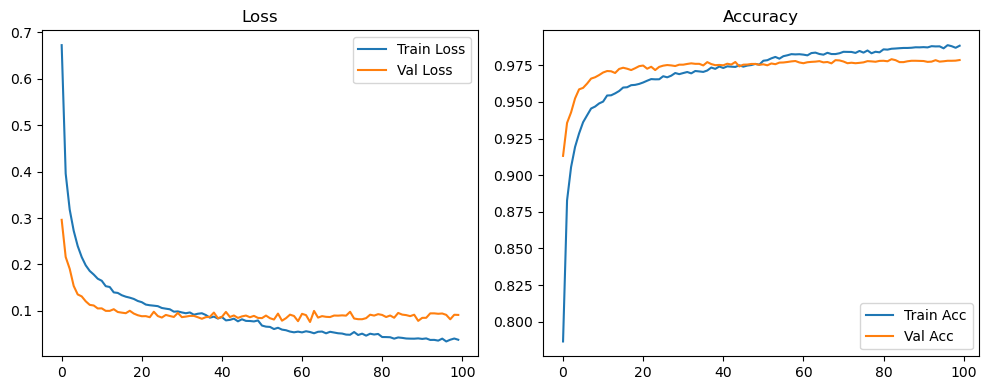

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3603, Acc: 0.8912 | Val Loss: 0.2094, Acc: 0.9371


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1551, Acc: 0.9537 | Val Loss: 0.1673, Acc: 0.9491


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9659 | Val Loss: 0.1357, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9747 | Val Loss: 0.1296, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9785 | Val Loss: 0.1080, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 0.1439, Acc: 0.9602


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1328, Acc: 0.9651


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.1147, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1211, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.1142, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1068, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.1104, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1160, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1441, Acc: 0.9706


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1167, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1316, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.1232, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1077, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.1163, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1304, Acc: 0.9697


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1194, Acc: 0.9712


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1115, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.1322, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1284, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1277, Acc: 0.9753


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9945 | Val Loss: 0.1520, Acc: 0.9687


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1159, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1635, Acc: 0.9669


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1371, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9949 | Val Loss: 0.1032, Acc: 0.9737


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1321, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1111, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1689, Acc: 0.9676


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1317, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1113, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1868, Acc: 0.9700


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1595, Acc: 0.9688


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1106, Acc: 0.9750


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1265, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1427, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1084, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1366, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1339, Acc: 0.9723


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1803, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1641, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1571, Acc: 0.9710


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1536, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1402, Acc: 0.9741


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1222, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1348, Acc: 0.9759


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1267, Acc: 0.9763


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1452, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1156, Acc: 0.9766


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1381, Acc: 0.9777


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1722, Acc: 0.9753


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1483, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1433, Acc: 0.9776


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1344, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1729, Acc: 0.9767


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1450, Acc: 0.9770


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1695, Acc: 0.9748


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1535, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1485, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1188, Acc: 0.9774


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0995, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1641, Acc: 0.9787


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1435, Acc: 0.9770


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1747, Acc: 0.9767


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1868, Acc: 0.9770


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1864, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1765, Acc: 0.9751


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1805, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1680, Acc: 0.9771


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1661, Acc: 0.9772


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1318, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1507, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1334, Acc: 0.9765


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1584, Acc: 0.9772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1507, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1366, Acc: 0.9786


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1555, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1568, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1541, Acc: 0.9797


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1555, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1765, Acc: 0.9793


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1595, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1730, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1991, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1826, Acc: 0.9797


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1739, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1996, Acc: 0.9786


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2034, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2066, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1863, Acc: 0.9799


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1878, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1675, Acc: 0.9796


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1622, Acc: 0.9803


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1551, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1748, Acc: 0.9799


Final Test Loss: 0.1658 Accuracy: 0.9806


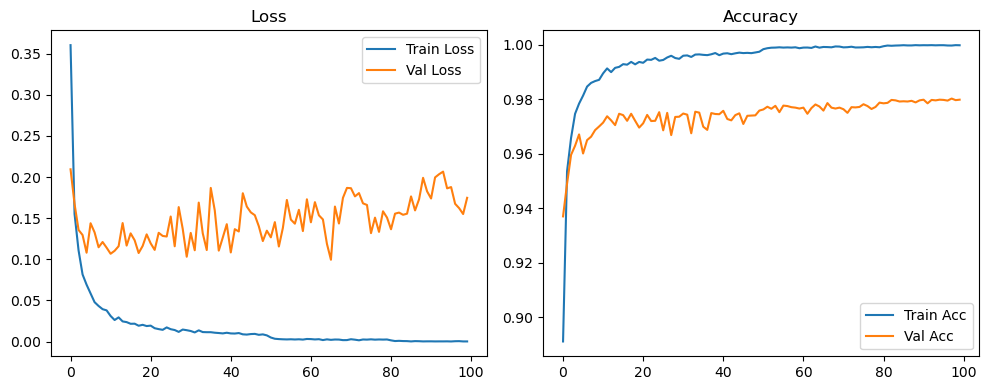

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4622, Acc: 0.8593 | Val Loss: 0.2354, Acc: 0.9276


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2586, Acc: 0.9233 | Val Loss: 0.1646, Acc: 0.9504


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1975, Acc: 0.9401 | Val Loss: 0.1466, Acc: 0.9579


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9520 | Val Loss: 0.1199, Acc: 0.9647


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9597 | Val Loss: 0.1116, Acc: 0.9678


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9636 | Val Loss: 0.1090, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9668 | Val Loss: 0.1101, Acc: 0.9673


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9723 | Val Loss: 0.1095, Acc: 0.9666


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9736 | Val Loss: 0.1122, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9739 | Val Loss: 0.0947, Acc: 0.9727


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9770 | Val Loss: 0.0984, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.0931, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9789 | Val Loss: 0.0967, Acc: 0.9734


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9817 | Val Loss: 0.1006, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9813 | Val Loss: 0.0993, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9831 | Val Loss: 0.1003, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.1119, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9837 | Val Loss: 0.0953, Acc: 0.9747


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.0939, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 0.0892, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.1052, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 0.1049, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9866 | Val Loss: 0.0967, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9873 | Val Loss: 0.1052, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0909, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.1062, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9884 | Val Loss: 0.0838, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1074, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0891, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.0993, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0846, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9896 | Val Loss: 0.1118, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0930, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0938, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0893, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0995, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9907 | Val Loss: 0.0928, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1099, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0851, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.0881, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.1025, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0987, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1047, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0778, Acc: 0.9787


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1012, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0970, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1191, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.1088, Acc: 0.9766


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0842, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0966, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0970, Acc: 0.9782


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0910, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1013, Acc: 0.9785


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0990, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1130, Acc: 0.9794


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1149, Acc: 0.9787


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1184, Acc: 0.9779


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1019, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1170, Acc: 0.9783


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1034, Acc: 0.9796


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1014, Acc: 0.9797


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0917, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1169, Acc: 0.9779


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1255, Acc: 0.9784


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1069, Acc: 0.9784


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0982, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1168, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0750, Acc: 0.9796


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1283, Acc: 0.9795


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1297, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0978, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1177, Acc: 0.9787


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1101, Acc: 0.9783


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0904, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1078, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1047, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1188, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1270, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1045, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1077, Acc: 0.9800


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.1102, Acc: 0.9797


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1117, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1101, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1214, Acc: 0.9804


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1233, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.1156, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1077, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1102, Acc: 0.9804


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1159, Acc: 0.9804


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1162, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1256, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1139, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1315, Acc: 0.9805


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1193, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1206, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1056, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1119, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1209, Acc: 0.9806


Final Test Loss: 0.1058 Accuracy: 0.9833


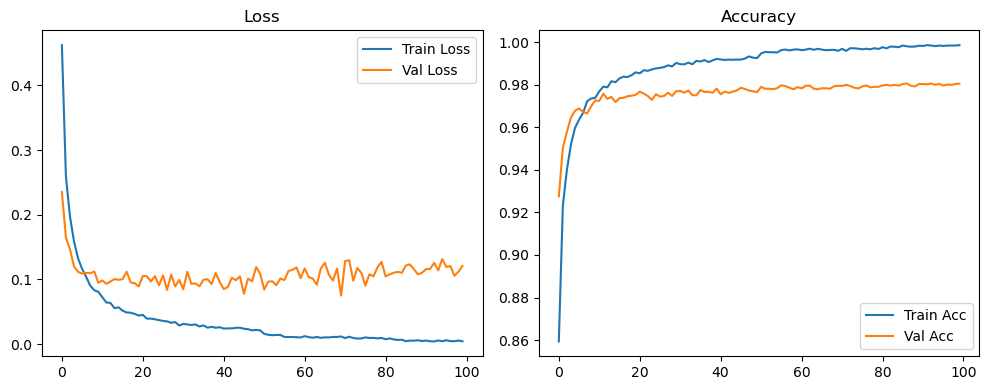

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6721, Acc: 0.7865 | Val Loss: 0.2961, Acc: 0.9132


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3956, Acc: 0.8828 | Val Loss: 0.2161, Acc: 0.9357


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3183, Acc: 0.9055 | Val Loss: 0.1908, Acc: 0.9428


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2727, Acc: 0.9193 | Val Loss: 0.1538, Acc: 0.9524


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2398, Acc: 0.9285 | Val Loss: 0.1355, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9361 | Val Loss: 0.1313, Acc: 0.9596


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1982, Acc: 0.9409 | Val Loss: 0.1208, Acc: 0.9625


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9455 | Val Loss: 0.1131, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9468 | Val Loss: 0.1117, Acc: 0.9668


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9490 | Val Loss: 0.1054, Acc: 0.9683


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9502 | Val Loss: 0.1055, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1002, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9545 | Val Loss: 0.1001, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9558 | Val Loss: 0.1037, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9574 | Val Loss: 0.0977, Acc: 0.9725


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9598 | Val Loss: 0.0963, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9600 | Val Loss: 0.0951, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9614 | Val Loss: 0.1004, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9616 | Val Loss: 0.0944, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9623 | Val Loss: 0.0908, Acc: 0.9744


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9633 | Val Loss: 0.0886, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9645 | Val Loss: 0.0888, Acc: 0.9727


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9656 | Val Loss: 0.0865, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9654 | Val Loss: 0.0983, Acc: 0.9718


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9655 | Val Loss: 0.0890, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.0858, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9668 | Val Loss: 0.0914, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1036, Acc: 0.9679 | Val Loss: 0.0891, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9697 | Val Loss: 0.0870, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9690 | Val Loss: 0.0957, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0968, Acc: 0.9697 | Val Loss: 0.0866, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9704 | Val Loss: 0.0878, Acc: 0.9759


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0967, Acc: 0.9695 | Val Loss: 0.0893, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9711 | Val Loss: 0.0894, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0864, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9705 | Val Loss: 0.0831, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9714 | Val Loss: 0.0867, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9735 | Val Loss: 0.0873, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9726 | Val Loss: 0.0965, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9742 | Val Loss: 0.0843, Acc: 0.9752


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9743 | Val Loss: 0.0979, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9741 | Val Loss: 0.0870, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9739 | Val Loss: 0.0903, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9750 | Val Loss: 0.0850, Acc: 0.9742


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.0882, Acc: 0.9754


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9748 | Val Loss: 0.0901, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9752 | Val Loss: 0.0864, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9759 | Val Loss: 0.0894, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9754 | Val Loss: 0.0850, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0685, Acc: 0.9781 | Val Loss: 0.0845, Acc: 0.9757


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9785 | Val Loss: 0.0901, Acc: 0.9750


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9798 | Val Loss: 0.0844, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9807 | Val Loss: 0.0815, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9795 | Val Loss: 0.0943, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9812 | Val Loss: 0.0790, Acc: 0.9769


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9818 | Val Loss: 0.0844, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9826 | Val Loss: 0.0920, Acc: 0.9777


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9824 | Val Loss: 0.0891, Acc: 0.9779


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9826 | Val Loss: 0.0780, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9823 | Val Loss: 0.0938, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9818 | Val Loss: 0.0910, Acc: 0.9771


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9834 | Val Loss: 0.0762, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 0.1000, Acc: 0.9775


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9827 | Val Loss: 0.0857, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9822 | Val Loss: 0.0888, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.0873, Acc: 0.9772


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9827 | Val Loss: 0.0869, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9827 | Val Loss: 0.0901, Acc: 0.9785


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9832 | Val Loss: 0.0899, Acc: 0.9783


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9842 | Val Loss: 0.0905, Acc: 0.9776


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9841 | Val Loss: 0.0899, Acc: 0.9764


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9841 | Val Loss: 0.0982, Acc: 0.9768


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9835 | Val Loss: 0.0837, Acc: 0.9764


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.0822, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0821, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.0845, Acc: 0.9778


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.0919, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 0.0900, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9839 | Val Loss: 0.0931, Acc: 0.9780


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.0900, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0854, Acc: 0.9786


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.0898, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0886, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9871 | Val Loss: 0.0914, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9871 | Val Loss: 0.0914, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.0892, Acc: 0.9787


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 0.0907, Acc: 0.9787


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0911, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9876 | Val Loss: 0.0806, Acc: 0.9779


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0867, Acc: 0.9775


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9876 | Val Loss: 0.0866, Acc: 0.9779


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.0949, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0942, Acc: 0.9783


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.0887, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0896, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9884 | Val Loss: 0.0913, Acc: 0.9781


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0837, Acc: 0.9786


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.0885, Acc: 0.9785


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9883 | Val Loss: 0.0905, Acc: 0.9782


Final Test Loss: 0.0785 Accuracy: 0.9804


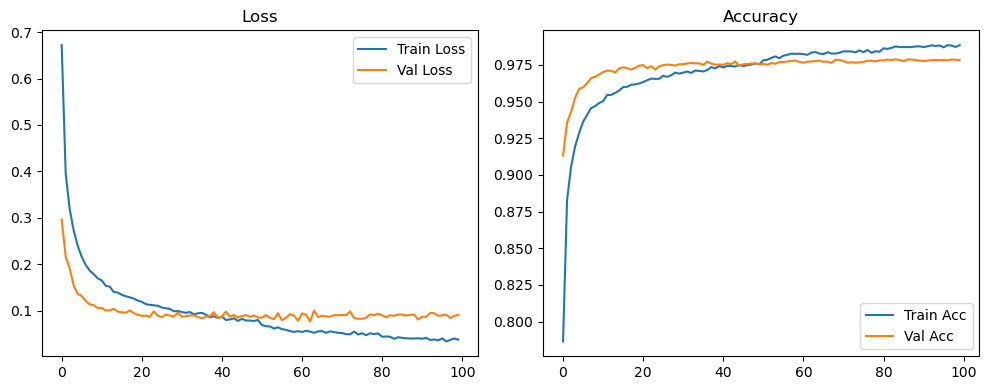

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3603, Acc: 0.8912 | Val Loss: 0.2094, Acc: 0.9371


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1551, Acc: 0.9537 | Val Loss: 0.1673, Acc: 0.9491


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9659 | Val Loss: 0.1357, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9747 | Val Loss: 0.1296, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9785 | Val Loss: 0.1080, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 0.1439, Acc: 0.9602


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1328, Acc: 0.9651


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.1147, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1211, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.1142, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1068, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.1104, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1160, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1441, Acc: 0.9706


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1167, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1316, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.1232, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1077, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.1163, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1304, Acc: 0.9697


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1194, Acc: 0.9712


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1115, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.1322, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1284, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1277, Acc: 0.9753


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9945 | Val Loss: 0.1520, Acc: 0.9687


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1159, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1635, Acc: 0.9669


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1371, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9949 | Val Loss: 0.1032, Acc: 0.9737


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1321, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1111, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1689, Acc: 0.9676


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1317, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1113, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1868, Acc: 0.9700


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1595, Acc: 0.9688


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1106, Acc: 0.9750


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1265, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1427, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1084, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1366, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1339, Acc: 0.9723


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1803, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1641, Acc: 0.9749


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1571, Acc: 0.9710


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1536, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1402, Acc: 0.9741


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1222, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1348, Acc: 0.9759


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1256, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1388, Acc: 0.9770


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1533, Acc: 0.9773


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1713, Acc: 0.9781


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1633, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1482, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1526, Acc: 0.9779


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1425, Acc: 0.9784


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1473, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1464, Acc: 0.9781


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1556, Acc: 0.9776


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1637, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1665, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1527, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1674, Acc: 0.9784


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1717, Acc: 0.9787


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1738, Acc: 0.9776


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1574, Acc: 0.9773


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1499, Acc: 0.9785


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1377, Acc: 0.9781


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1683, Acc: 0.9789


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1714, Acc: 0.9787


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1899, Acc: 0.9787


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1918, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1747, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1277, Acc: 0.9784


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1622, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1499, Acc: 0.9790


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1583, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1678, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1441, Acc: 0.9800


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1559, Acc: 0.9796


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1590, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1643, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1519, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1589, Acc: 0.9794


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1550, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1686, Acc: 0.9804


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1656, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1711, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1789, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1819, Acc: 0.9783


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1709, Acc: 0.9785


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1721, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1535, Acc: 0.9789


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1676, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1563, Acc: 0.9784


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1578, Acc: 0.9794


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1549, Acc: 0.9802


Final Test Loss: 0.1531 Accuracy: 0.9807


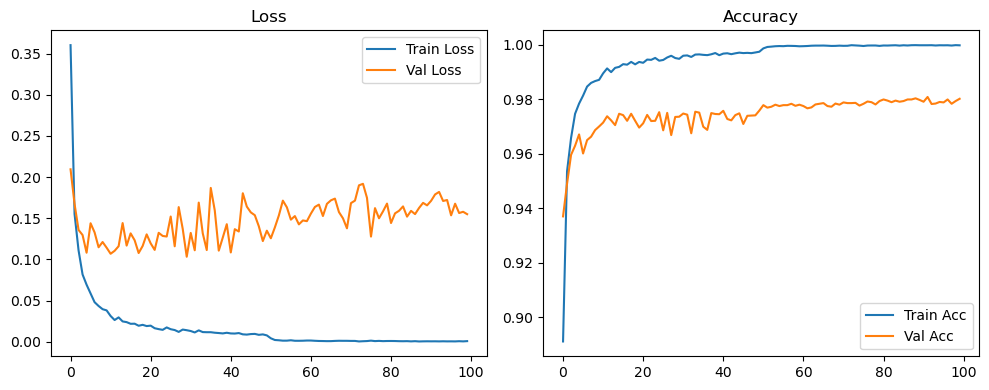

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4622, Acc: 0.8593 | Val Loss: 0.2354, Acc: 0.9276


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2586, Acc: 0.9233 | Val Loss: 0.1646, Acc: 0.9504


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1975, Acc: 0.9401 | Val Loss: 0.1466, Acc: 0.9579


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9520 | Val Loss: 0.1199, Acc: 0.9647


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9597 | Val Loss: 0.1116, Acc: 0.9678


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9636 | Val Loss: 0.1090, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9668 | Val Loss: 0.1101, Acc: 0.9673


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9723 | Val Loss: 0.1095, Acc: 0.9666


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9736 | Val Loss: 0.1122, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9739 | Val Loss: 0.0947, Acc: 0.9727


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9770 | Val Loss: 0.0984, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.0931, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9789 | Val Loss: 0.0967, Acc: 0.9734


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9817 | Val Loss: 0.1006, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9813 | Val Loss: 0.0993, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9831 | Val Loss: 0.1003, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.1119, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9837 | Val Loss: 0.0953, Acc: 0.9747


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.0939, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 0.0892, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.1052, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 0.1049, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9866 | Val Loss: 0.0967, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9873 | Val Loss: 0.1052, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0909, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.1062, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9884 | Val Loss: 0.0838, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1074, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0891, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.0993, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0846, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9896 | Val Loss: 0.1118, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0930, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0938, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0893, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0995, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9907 | Val Loss: 0.0928, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1099, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0851, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.0881, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.1025, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0987, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1047, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0778, Acc: 0.9787


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1012, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0970, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1191, Acc: 0.9770


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.1088, Acc: 0.9766


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0936, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.0967, Acc: 0.9785


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1075, Acc: 0.9787


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1037, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1092, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1003, Acc: 0.9781


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1094, Acc: 0.9787


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9972 | Val Loss: 0.1099, Acc: 0.9790


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1180, Acc: 0.9784


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1107, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1264, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1068, Acc: 0.9782


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1088, Acc: 0.9793


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1113, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1191, Acc: 0.9786


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1082, Acc: 0.9787


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1058, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1071, Acc: 0.9793


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1185, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0986, Acc: 0.9802


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1162, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1226, Acc: 0.9791


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1133, Acc: 0.9792


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1183, Acc: 0.9785


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1228, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1130, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1171, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1177, Acc: 0.9791


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1190, Acc: 0.9800


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1027, Acc: 0.9800


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1004, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1148, Acc: 0.9791


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1129, Acc: 0.9794


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1085, Acc: 0.9797


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1113, Acc: 0.9789


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1247, Acc: 0.9790


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1192, Acc: 0.9793


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1182, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1173, Acc: 0.9785


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9984 | Val Loss: 0.1233, Acc: 0.9787


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1275, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1234, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1165, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1146, Acc: 0.9801


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1224, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1144, Acc: 0.9794


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1205, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1138, Acc: 0.9793


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1172, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1112, Acc: 0.9798


Final Test Loss: 0.1012 Accuracy: 0.9820


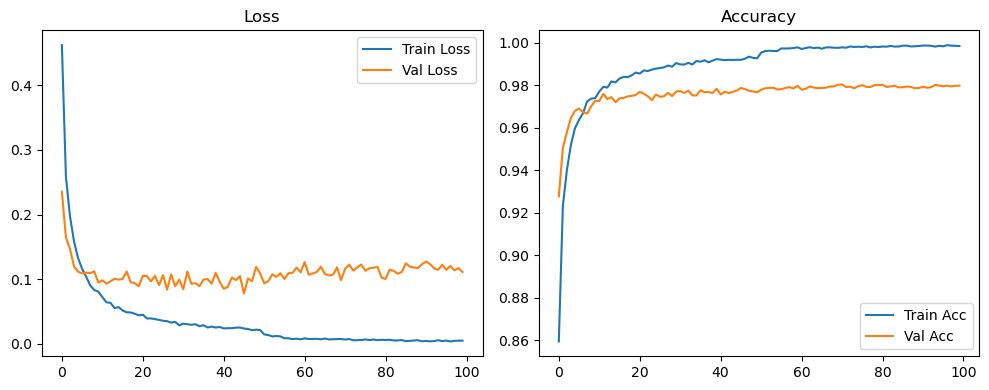

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6721, Acc: 0.7865 | Val Loss: 0.2961, Acc: 0.9132


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3956, Acc: 0.8828 | Val Loss: 0.2161, Acc: 0.9357


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3183, Acc: 0.9055 | Val Loss: 0.1908, Acc: 0.9428


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2727, Acc: 0.9193 | Val Loss: 0.1538, Acc: 0.9524


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2398, Acc: 0.9285 | Val Loss: 0.1355, Acc: 0.9586


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9361 | Val Loss: 0.1313, Acc: 0.9596


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1982, Acc: 0.9409 | Val Loss: 0.1208, Acc: 0.9625


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9455 | Val Loss: 0.1131, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9468 | Val Loss: 0.1117, Acc: 0.9668


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9490 | Val Loss: 0.1054, Acc: 0.9683


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1650, Acc: 0.9502 | Val Loss: 0.1055, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1002, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9545 | Val Loss: 0.1001, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9558 | Val Loss: 0.1037, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9574 | Val Loss: 0.0977, Acc: 0.9725


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9598 | Val Loss: 0.0963, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9600 | Val Loss: 0.0951, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9614 | Val Loss: 0.1004, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9616 | Val Loss: 0.0944, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9623 | Val Loss: 0.0908, Acc: 0.9744


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9633 | Val Loss: 0.0886, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9645 | Val Loss: 0.0888, Acc: 0.9727


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9656 | Val Loss: 0.0865, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9654 | Val Loss: 0.0983, Acc: 0.9718


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9655 | Val Loss: 0.0890, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9675 | Val Loss: 0.0858, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9668 | Val Loss: 0.0914, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1036, Acc: 0.9679 | Val Loss: 0.0891, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9697 | Val Loss: 0.0870, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9690 | Val Loss: 0.0957, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0968, Acc: 0.9697 | Val Loss: 0.0866, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9704 | Val Loss: 0.0878, Acc: 0.9759


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0967, Acc: 0.9695 | Val Loss: 0.0893, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9711 | Val Loss: 0.0894, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0864, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9705 | Val Loss: 0.0831, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9714 | Val Loss: 0.0867, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9735 | Val Loss: 0.0873, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9726 | Val Loss: 0.0965, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9742 | Val Loss: 0.0843, Acc: 0.9752


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9750


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9743 | Val Loss: 0.0979, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9741 | Val Loss: 0.0870, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9739 | Val Loss: 0.0903, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9750 | Val Loss: 0.0850, Acc: 0.9742


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.0882, Acc: 0.9754


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9748 | Val Loss: 0.0901, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9752 | Val Loss: 0.0864, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9759 | Val Loss: 0.0894, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9754 | Val Loss: 0.0850, Acc: 0.9753


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9784 | Val Loss: 0.0893, Acc: 0.9754


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9800 | Val Loss: 0.0860, Acc: 0.9760


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9798 | Val Loss: 0.0886, Acc: 0.9767


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9811 | Val Loss: 0.0802, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9814 | Val Loss: 0.0874, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9820 | Val Loss: 0.0793, Acc: 0.9767


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0552, Acc: 0.9825 | Val Loss: 0.0826, Acc: 0.9768


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9832 | Val Loss: 0.0866, Acc: 0.9775


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9839 | Val Loss: 0.0925, Acc: 0.9764


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9838 | Val Loss: 0.0836, Acc: 0.9775


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9832 | Val Loss: 0.0915, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9832 | Val Loss: 0.0909, Acc: 0.9767


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9841 | Val Loss: 0.0787, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0909, Acc: 0.9769


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9828 | Val Loss: 0.0868, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0801, Acc: 0.9773


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9839 | Val Loss: 0.0867, Acc: 0.9768


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9846 | Val Loss: 0.0818, Acc: 0.9773


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9847 | Val Loss: 0.0857, Acc: 0.9779


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9854 | Val Loss: 0.0860, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9851 | Val Loss: 0.0895, Acc: 0.9776


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9864 | Val Loss: 0.0902, Acc: 0.9777


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.0938, Acc: 0.9772


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9844 | Val Loss: 0.0910, Acc: 0.9774


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.0855, Acc: 0.9771


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9860 | Val Loss: 0.0844, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0922, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.0914, Acc: 0.9781


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9853 | Val Loss: 0.0935, Acc: 0.9786


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9860 | Val Loss: 0.0932, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.0881, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9857 | Val Loss: 0.0864, Acc: 0.9794


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.0908, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.0872, Acc: 0.9782


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9865 | Val Loss: 0.0901, Acc: 0.9785


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.0876, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0886, Acc: 0.9787


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9867 | Val Loss: 0.0867, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.0898, Acc: 0.9785


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0821, Acc: 0.9787


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9871 | Val Loss: 0.0844, Acc: 0.9781


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9865 | Val Loss: 0.0855, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.0903, Acc: 0.9787


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0926, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.0891, Acc: 0.9776


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9864 | Val Loss: 0.0924, Acc: 0.9785


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9879 | Val Loss: 0.0896, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.0820, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0855, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9873 | Val Loss: 0.0896, Acc: 0.9791


Final Test Loss: 0.0756 Accuracy: 0.9821


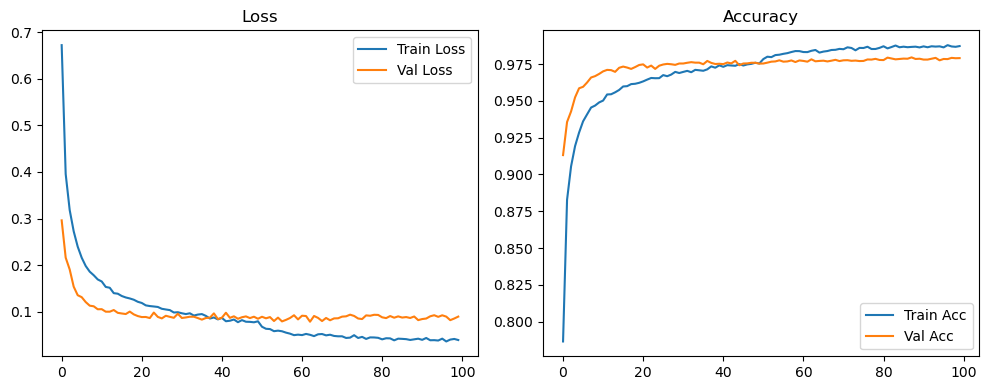

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3575, Acc: 0.8939 | Val Loss: 0.2055, Acc: 0.9363


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1476, Acc: 0.9550 | Val Loss: 0.1635, Acc: 0.9514


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9693 | Val Loss: 0.1136, Acc: 0.9636


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9758 | Val Loss: 0.1463, Acc: 0.9583


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9812 | Val Loss: 0.1163, Acc: 0.9687


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9828 | Val Loss: 0.1140, Acc: 0.9698


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.1241, Acc: 0.9660


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.1270, Acc: 0.9638


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.1115, Acc: 0.9704


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1136, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1062, Acc: 0.9739


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1283, Acc: 0.9713


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1185, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.1088, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.1294, Acc: 0.9704


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1493, Acc: 0.9673


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1301, Acc: 0.9704


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1087, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1152, Acc: 0.9737


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1241, Acc: 0.9727


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1264, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1228, Acc: 0.9719


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1312, Acc: 0.9705


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1444, Acc: 0.9702


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1112, Acc: 0.9747


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1292, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1334, Acc: 0.9722


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1250, Acc: 0.9754


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1211, Acc: 0.9728


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1195, Acc: 0.9737


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1323, Acc: 0.9722


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1338, Acc: 0.9729


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1332, Acc: 0.9736


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1399, Acc: 0.9721


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1377, Acc: 0.9747


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1552, Acc: 0.9705


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1338, Acc: 0.9754


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1282, Acc: 0.9761


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1570, Acc: 0.9712


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1181, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1181, Acc: 0.9765


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1289, Acc: 0.9732


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1298, Acc: 0.9735


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1235, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1287, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1242, Acc: 0.9760


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1080, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1290, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1361, Acc: 0.9729


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1280, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1145, Acc: 0.9782


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1173, Acc: 0.9762


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1285, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1390, Acc: 0.9726


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1401, Acc: 0.9765


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1315, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1175, Acc: 0.9753


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1063, Acc: 0.9764


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1404, Acc: 0.9777


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1254, Acc: 0.9759


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1307, Acc: 0.9753


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1187, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1257, Acc: 0.9760


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1186, Acc: 0.9760


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1533, Acc: 0.9753


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1290, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1678, Acc: 0.9728


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1399, Acc: 0.9718


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1230, Acc: 0.9773


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1492, Acc: 0.9731


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1352, Acc: 0.9765


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1261, Acc: 0.9757


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1280, Acc: 0.9787


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1418, Acc: 0.9750


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1211, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1313, Acc: 0.9730


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1384, Acc: 0.9765


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1416, Acc: 0.9746


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1306, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1461, Acc: 0.9772


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1075, Acc: 0.9778


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1124, Acc: 0.9763


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1545, Acc: 0.9766


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1412, Acc: 0.9741


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1397, Acc: 0.9758


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1465, Acc: 0.9771


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1208, Acc: 0.9773


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1455, Acc: 0.9781


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1654, Acc: 0.9764


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9985 | Val Loss: 0.1351, Acc: 0.9758


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0938, Acc: 0.9751


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1088, Acc: 0.9774


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1287, Acc: 0.9753


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1230, Acc: 0.9771


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1603, Acc: 0.9750


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1220, Acc: 0.9748


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1398, Acc: 0.9752


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1295, Acc: 0.9759


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1538, Acc: 0.9757


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1049, Acc: 0.9757


Final Test Loss: 0.0997 Accuracy: 0.9766


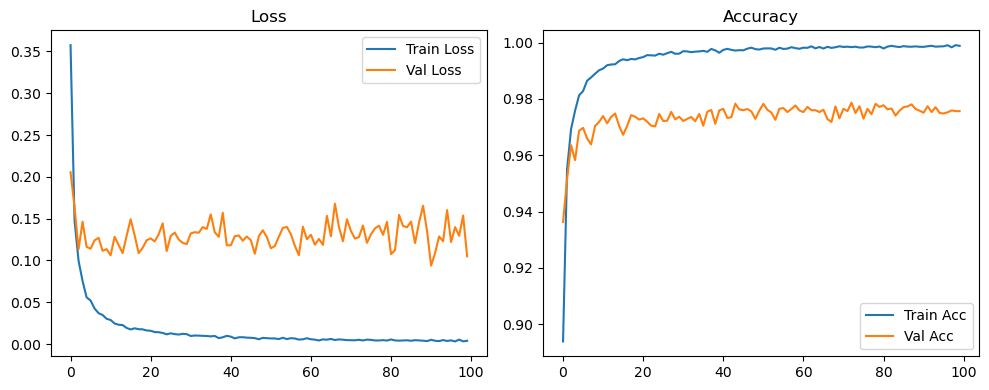

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4765, Acc: 0.8560 | Val Loss: 0.2506, Acc: 0.9233


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2855, Acc: 0.9140 | Val Loss: 0.1865, Acc: 0.9432


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2270, Acc: 0.9309 | Val Loss: 0.1571, Acc: 0.9530


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1872, Acc: 0.9438 | Val Loss: 0.1437, Acc: 0.9565


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1576, Acc: 0.9519 | Val Loss: 0.1339, Acc: 0.9613


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1402, Acc: 0.9572 | Val Loss: 0.1279, Acc: 0.9634


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1251, Acc: 0.9619 | Val Loss: 0.1158, Acc: 0.9667


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1123, Acc: 0.9649 | Val Loss: 0.1198, Acc: 0.9639


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9677 | Val Loss: 0.1145, Acc: 0.9684


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9691 | Val Loss: 0.1057, Acc: 0.9696


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9727 | Val Loss: 0.1066, Acc: 0.9702


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9735 | Val Loss: 0.1136, Acc: 0.9708


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9767 | Val Loss: 0.1010, Acc: 0.9725


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9777 | Val Loss: 0.1076, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9776 | Val Loss: 0.1020, Acc: 0.9726


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9805 | Val Loss: 0.0976, Acc: 0.9729


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0985, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9798 | Val Loss: 0.1050, Acc: 0.9713


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9820 | Val Loss: 0.1076, Acc: 0.9702


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9825 | Val Loss: 0.0980, Acc: 0.9729


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9822 | Val Loss: 0.0966, Acc: 0.9727


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.1004, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.1000, Acc: 0.9732


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9850 | Val Loss: 0.1103, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.1000, Acc: 0.9741


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9856 | Val Loss: 0.0945, Acc: 0.9752


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.1036, Acc: 0.9739


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.1000, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9873 | Val Loss: 0.1078, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9872 | Val Loss: 0.1009, Acc: 0.9737


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0970, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1040, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 0.1088, Acc: 0.9747


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.1046, Acc: 0.9756


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.1001, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9893 | Val Loss: 0.1113, Acc: 0.9750


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.1046, Acc: 0.9750


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.0980, Acc: 0.9750


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.1172, Acc: 0.9737


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0950, Acc: 0.9740


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1070, Acc: 0.9755


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.1015, Acc: 0.9745


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1142, Acc: 0.9737


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.1059, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9908 | Val Loss: 0.1107, Acc: 0.9744


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.1069, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1073, Acc: 0.9763


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.1116, Acc: 0.9755


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9913 | Val Loss: 0.1084, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1283, Acc: 0.9751


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1167, Acc: 0.9735


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9918 | Val Loss: 0.1147, Acc: 0.9755


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.1044, Acc: 0.9770


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.1079, Acc: 0.9755


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1130, Acc: 0.9765


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1008, Acc: 0.9762


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9919 | Val Loss: 0.1155, Acc: 0.9754


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1106, Acc: 0.9771


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1140, Acc: 0.9765


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9932 | Val Loss: 0.1197, Acc: 0.9776


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.1072, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.1036, Acc: 0.9757


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1070, Acc: 0.9758


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1119, Acc: 0.9765


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1125, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.1199, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1160, Acc: 0.9776


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1033, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9927 | Val Loss: 0.1153, Acc: 0.9755


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1167, Acc: 0.9762


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.1258, Acc: 0.9752


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1094, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1115, Acc: 0.9752


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0982, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1010, Acc: 0.9766


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9938 | Val Loss: 0.1183, Acc: 0.9757


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.1031, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.1028, Acc: 0.9767


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1141, Acc: 0.9766


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1204, Acc: 0.9770


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1191, Acc: 0.9777


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1108, Acc: 0.9755


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1314, Acc: 0.9758


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1303, Acc: 0.9766


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.1170, Acc: 0.9765


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1230, Acc: 0.9774


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1036, Acc: 0.9773


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1013, Acc: 0.9779


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.1156, Acc: 0.9780


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1205, Acc: 0.9762


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1149, Acc: 0.9758


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1234, Acc: 0.9772


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0949, Acc: 0.9773


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1136, Acc: 0.9776


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1083, Acc: 0.9776


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1056, Acc: 0.9765


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.1336, Acc: 0.9773


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.1228, Acc: 0.9772


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1079, Acc: 0.9784


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1252, Acc: 0.9773


Final Test Loss: 0.1120 Accuracy: 0.9783


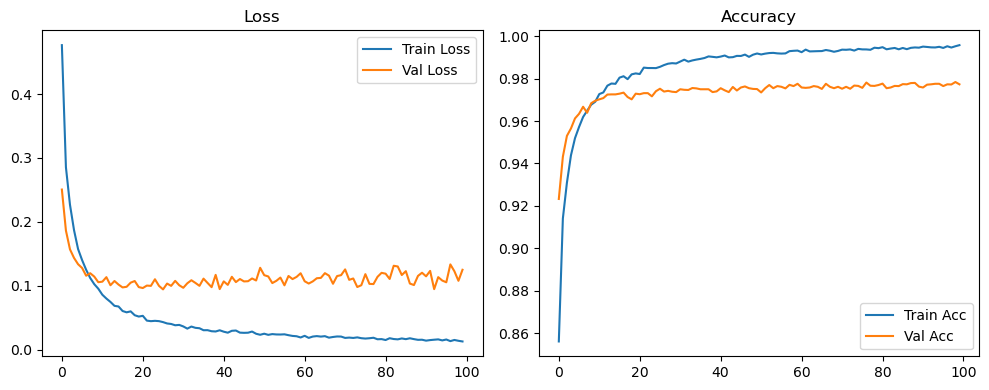

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7167, Acc: 0.7728 | Val Loss: 0.3277, Acc: 0.9041


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4431, Acc: 0.8662 | Val Loss: 0.2458, Acc: 0.9268


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3640, Acc: 0.8910 | Val Loss: 0.2235, Acc: 0.9340


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3122, Acc: 0.9079 | Val Loss: 0.1825, Acc: 0.9435


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2782, Acc: 0.9174 | Val Loss: 0.1572, Acc: 0.9537


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2542, Acc: 0.9229 | Val Loss: 0.1499, Acc: 0.9541


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2276, Acc: 0.9318 | Val Loss: 0.1428, Acc: 0.9568


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2134, Acc: 0.9356 | Val Loss: 0.1301, Acc: 0.9603


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1977, Acc: 0.9400 | Val Loss: 0.1242, Acc: 0.9631


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1908, Acc: 0.9417 | Val Loss: 0.1174, Acc: 0.9651


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1839, Acc: 0.9454 | Val Loss: 0.1238, Acc: 0.9638


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1724, Acc: 0.9485 | Val Loss: 0.1120, Acc: 0.9677


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1647, Acc: 0.9498 | Val Loss: 0.1097, Acc: 0.9665


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1578, Acc: 0.9517 | Val Loss: 0.1155, Acc: 0.9667


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1543, Acc: 0.9531 | Val Loss: 0.1090, Acc: 0.9681


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1452, Acc: 0.9564 | Val Loss: 0.1024, Acc: 0.9715


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1449, Acc: 0.9552 | Val Loss: 0.1019, Acc: 0.9703


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1383, Acc: 0.9571 | Val Loss: 0.1016, Acc: 0.9709


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1317, Acc: 0.9592 | Val Loss: 0.0979, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1343, Acc: 0.9585 | Val Loss: 0.0974, Acc: 0.9704


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9605 | Val Loss: 0.0969, Acc: 0.9712


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1260, Acc: 0.9614 | Val Loss: 0.0934, Acc: 0.9734


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1214, Acc: 0.9627 | Val Loss: 0.0952, Acc: 0.9712


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1201, Acc: 0.9632 | Val Loss: 0.0976, Acc: 0.9716


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1153, Acc: 0.9646 | Val Loss: 0.0996, Acc: 0.9718


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1123, Acc: 0.9654 | Val Loss: 0.0993, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1122, Acc: 0.9651 | Val Loss: 0.1004, Acc: 0.9715


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1067, Acc: 0.9663 | Val Loss: 0.0984, Acc: 0.9730


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9668 | Val Loss: 0.0964, Acc: 0.9725


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1038, Acc: 0.9674 | Val Loss: 0.0966, Acc: 0.9744


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1017, Acc: 0.9678 | Val Loss: 0.0914, Acc: 0.9734


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0984, Acc: 0.9694 | Val Loss: 0.0941, Acc: 0.9736


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1036, Acc: 0.9673 | Val Loss: 0.0911, Acc: 0.9745


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9680 | Val Loss: 0.0982, Acc: 0.9730


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0995, Acc: 0.9679 | Val Loss: 0.0923, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0979, Acc: 0.9689 | Val Loss: 0.0985, Acc: 0.9752


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0930, Acc: 0.9707 | Val Loss: 0.0910, Acc: 0.9745


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9712 | Val Loss: 0.0957, Acc: 0.9736


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9715 | Val Loss: 0.0946, Acc: 0.9745


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9715 | Val Loss: 0.0908, Acc: 0.9739


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9701 | Val Loss: 0.0903, Acc: 0.9739


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9730 | Val Loss: 0.0937, Acc: 0.9741


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9717 | Val Loss: 0.0973, Acc: 0.9729


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9732 | Val Loss: 0.0896, Acc: 0.9738


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0865, Acc: 0.9721 | Val Loss: 0.0964, Acc: 0.9744


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9739 | Val Loss: 0.0934, Acc: 0.9739


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9741 | Val Loss: 0.0902, Acc: 0.9756


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9734 | Val Loss: 0.0938, Acc: 0.9758


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9747 | Val Loss: 0.0933, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0834, Acc: 0.9737 | Val Loss: 0.0949, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0827, Acc: 0.9732 | Val Loss: 0.0936, Acc: 0.9748


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0796, Acc: 0.9749 | Val Loss: 0.0934, Acc: 0.9758


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9747 | Val Loss: 0.0913, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0784, Acc: 0.9748 | Val Loss: 0.0863, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0787, Acc: 0.9760 | Val Loss: 0.0889, Acc: 0.9760


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9759 | Val Loss: 0.0867, Acc: 0.9755


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9765 | Val Loss: 0.0857, Acc: 0.9748


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9765 | Val Loss: 0.0959, Acc: 0.9758


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9773 | Val Loss: 0.0924, Acc: 0.9751


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9762 | Val Loss: 0.0869, Acc: 0.9763


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9771 | Val Loss: 0.0918, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9768 | Val Loss: 0.0919, Acc: 0.9755


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9777 | Val Loss: 0.0838, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9775 | Val Loss: 0.0929, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9781 | Val Loss: 0.1057, Acc: 0.9752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9773 | Val Loss: 0.0948, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9785 | Val Loss: 0.0984, Acc: 0.9748


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9772 | Val Loss: 0.0881, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9777 | Val Loss: 0.0855, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9796 | Val Loss: 0.0923, Acc: 0.9742


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9782 | Val Loss: 0.0874, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9784 | Val Loss: 0.0937, Acc: 0.9755


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9801 | Val Loss: 0.0986, Acc: 0.9757


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9792 | Val Loss: 0.0943, Acc: 0.9756


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.0924, Acc: 0.9750


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.0817, Acc: 0.9754


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.0910, Acc: 0.9754


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.0920, Acc: 0.9764


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9792 | Val Loss: 0.0909, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.0924, Acc: 0.9767


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9816 | Val Loss: 0.0990, Acc: 0.9752


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9811 | Val Loss: 0.0899, Acc: 0.9757


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9809 | Val Loss: 0.0894, Acc: 0.9764


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9812 | Val Loss: 0.0901, Acc: 0.9752


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0945, Acc: 0.9756


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9814 | Val Loss: 0.0959, Acc: 0.9767


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.1002, Acc: 0.9761


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9807 | Val Loss: 0.0900, Acc: 0.9754


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9805 | Val Loss: 0.0930, Acc: 0.9752


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9823 | Val Loss: 0.0827, Acc: 0.9762


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9816 | Val Loss: 0.0908, Acc: 0.9760


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.0926, Acc: 0.9762


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9827 | Val Loss: 0.0978, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9805 | Val Loss: 0.0948, Acc: 0.9761


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9809 | Val Loss: 0.0875, Acc: 0.9759


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9814 | Val Loss: 0.0901, Acc: 0.9770


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9814 | Val Loss: 0.0930, Acc: 0.9759


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9823 | Val Loss: 0.0880, Acc: 0.9758


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9824 | Val Loss: 0.0827, Acc: 0.9772


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9814 | Val Loss: 0.0925, Acc: 0.9757


Final Test Loss: 0.0820 Accuracy: 0.9788


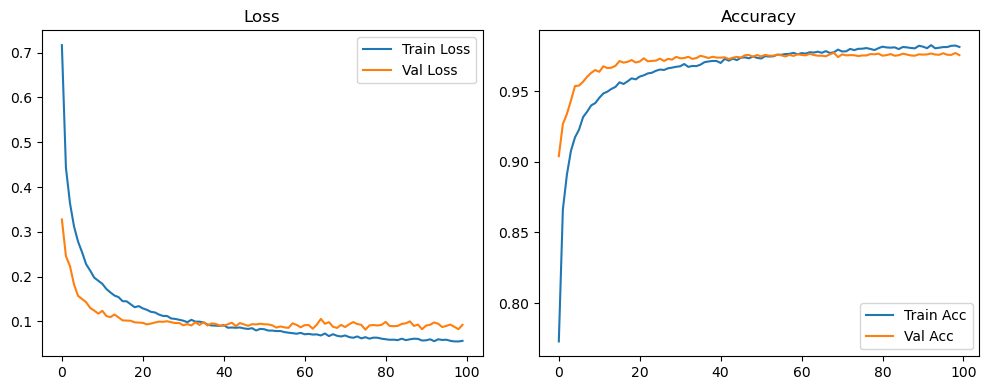

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3575, Acc: 0.8939 | Val Loss: 0.2055, Acc: 0.9363


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1476, Acc: 0.9550 | Val Loss: 0.1635, Acc: 0.9514


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9693 | Val Loss: 0.1136, Acc: 0.9636


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9758 | Val Loss: 0.1463, Acc: 0.9583


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9812 | Val Loss: 0.1163, Acc: 0.9687


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9828 | Val Loss: 0.1140, Acc: 0.9698


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.1241, Acc: 0.9660


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.1270, Acc: 0.9638


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.1115, Acc: 0.9704


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1136, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1062, Acc: 0.9739


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1283, Acc: 0.9713


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1185, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.1088, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.1294, Acc: 0.9704


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1493, Acc: 0.9673


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1301, Acc: 0.9704


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1087, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1152, Acc: 0.9737


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1241, Acc: 0.9727


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1264, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1228, Acc: 0.9719


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1312, Acc: 0.9705


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1444, Acc: 0.9702


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1112, Acc: 0.9747


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1292, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1334, Acc: 0.9722


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1250, Acc: 0.9754


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1211, Acc: 0.9728


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1195, Acc: 0.9737


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1323, Acc: 0.9722


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1338, Acc: 0.9729


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1332, Acc: 0.9736


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1399, Acc: 0.9721


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1377, Acc: 0.9747


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1552, Acc: 0.9705


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1338, Acc: 0.9754


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1282, Acc: 0.9761


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1570, Acc: 0.9712


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1181, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1181, Acc: 0.9765


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1289, Acc: 0.9732


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1298, Acc: 0.9735


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1235, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1287, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1242, Acc: 0.9760


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1080, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1290, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1361, Acc: 0.9729


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1280, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1174, Acc: 0.9780


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1295, Acc: 0.9765


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1531, Acc: 0.9769


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1560, Acc: 0.9771


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1342, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1339, Acc: 0.9794


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1512, Acc: 0.9786


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1447, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1531, Acc: 0.9780


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1559, Acc: 0.9764


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1449, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1625, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1503, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1528, Acc: 0.9770


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1498, Acc: 0.9785


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1403, Acc: 0.9789


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1587, Acc: 0.9768


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1607, Acc: 0.9759


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1453, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1316, Acc: 0.9802


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1365, Acc: 0.9787


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1520, Acc: 0.9783


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1435, Acc: 0.9795


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1410, Acc: 0.9790


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1317, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1550, Acc: 0.9773


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1440, Acc: 0.9784


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1538, Acc: 0.9773


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1574, Acc: 0.9757


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1477, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1529, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1463, Acc: 0.9789


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1519, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1587, Acc: 0.9794


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1514, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1596, Acc: 0.9793


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1593, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1425, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1596, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1464, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1650, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1549, Acc: 0.9795


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1542, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1607, Acc: 0.9793


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1466, Acc: 0.9795


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1483, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1468, Acc: 0.9796


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1558, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1579, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1643, Acc: 0.9788


Final Test Loss: 0.1515 Accuracy: 0.9805


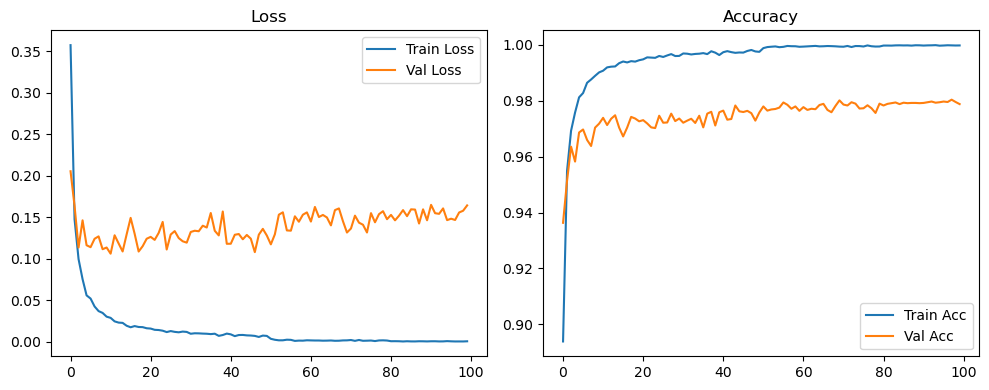

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4765, Acc: 0.8560 | Val Loss: 0.2506, Acc: 0.9233


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2855, Acc: 0.9140 | Val Loss: 0.1865, Acc: 0.9432


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2270, Acc: 0.9309 | Val Loss: 0.1571, Acc: 0.9530


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1872, Acc: 0.9438 | Val Loss: 0.1437, Acc: 0.9565


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1576, Acc: 0.9519 | Val Loss: 0.1339, Acc: 0.9613


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1402, Acc: 0.9572 | Val Loss: 0.1279, Acc: 0.9634


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1251, Acc: 0.9619 | Val Loss: 0.1158, Acc: 0.9667


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1123, Acc: 0.9649 | Val Loss: 0.1198, Acc: 0.9639


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9677 | Val Loss: 0.1145, Acc: 0.9684


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9691 | Val Loss: 0.1057, Acc: 0.9696


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9727 | Val Loss: 0.1066, Acc: 0.9702


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9735 | Val Loss: 0.1136, Acc: 0.9708


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9767 | Val Loss: 0.1010, Acc: 0.9725


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9777 | Val Loss: 0.1076, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9776 | Val Loss: 0.1020, Acc: 0.9726


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9805 | Val Loss: 0.0976, Acc: 0.9729


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0985, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9798 | Val Loss: 0.1050, Acc: 0.9713


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9820 | Val Loss: 0.1076, Acc: 0.9702


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9825 | Val Loss: 0.0980, Acc: 0.9729


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9822 | Val Loss: 0.0966, Acc: 0.9727


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.1004, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.1000, Acc: 0.9732


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9850 | Val Loss: 0.1103, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.1000, Acc: 0.9741


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9856 | Val Loss: 0.0945, Acc: 0.9752


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.1036, Acc: 0.9739


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.1000, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9873 | Val Loss: 0.1078, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9872 | Val Loss: 0.1009, Acc: 0.9737


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0970, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1040, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 0.1088, Acc: 0.9747


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.1046, Acc: 0.9756


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.1001, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9893 | Val Loss: 0.1113, Acc: 0.9750


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.1046, Acc: 0.9750


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.0980, Acc: 0.9750


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.1172, Acc: 0.9737


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0950, Acc: 0.9740


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1070, Acc: 0.9755


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.1015, Acc: 0.9745


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1142, Acc: 0.9737


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.1059, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9908 | Val Loss: 0.1107, Acc: 0.9744


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.1069, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1073, Acc: 0.9763


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.1116, Acc: 0.9755


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9913 | Val Loss: 0.1084, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1283, Acc: 0.9751


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.1059, Acc: 0.9760


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1164, Acc: 0.9752


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1119, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1133, Acc: 0.9769


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.1135, Acc: 0.9777


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.1127, Acc: 0.9775


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.1145, Acc: 0.9789


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1152, Acc: 0.9776


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.1147, Acc: 0.9787


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.1140, Acc: 0.9780


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1178, Acc: 0.9774


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1137, Acc: 0.9784


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1052, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.1193, Acc: 0.9771


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1174, Acc: 0.9766


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1257, Acc: 0.9766


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1238, Acc: 0.9764


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1015, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1074, Acc: 0.9779


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1275, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1238, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1176, Acc: 0.9772


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1253, Acc: 0.9762


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1160, Acc: 0.9777


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1088, Acc: 0.9785


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1139, Acc: 0.9778


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1191, Acc: 0.9781


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1191, Acc: 0.9766


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1226, Acc: 0.9771


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1168, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1261, Acc: 0.9777


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1231, Acc: 0.9776


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1184, Acc: 0.9783


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1285, Acc: 0.9784


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1244, Acc: 0.9775


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1252, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1267, Acc: 0.9779


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1213, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1223, Acc: 0.9777


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1181, Acc: 0.9787


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1264, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1259, Acc: 0.9785


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1238, Acc: 0.9783


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1331, Acc: 0.9767


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1264, Acc: 0.9784


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1191, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1279, Acc: 0.9782


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9777


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9777


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1222, Acc: 0.9781


Final Test Loss: 0.1030 Accuracy: 0.9822


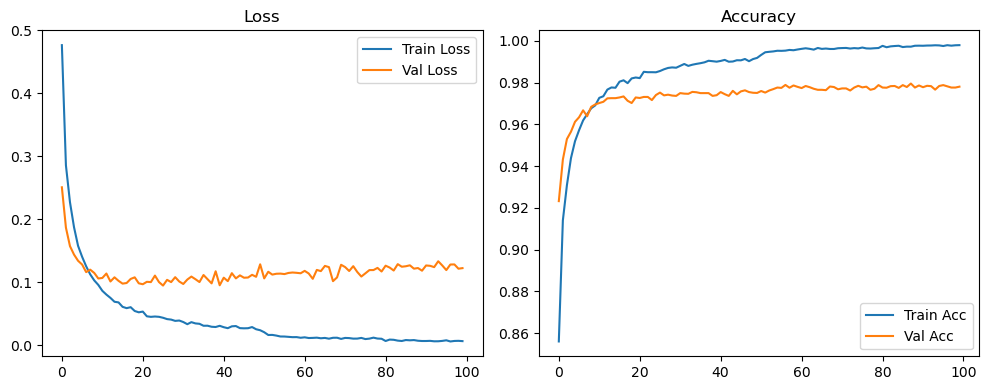

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7167, Acc: 0.7728 | Val Loss: 0.3277, Acc: 0.9041


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4431, Acc: 0.8662 | Val Loss: 0.2458, Acc: 0.9268


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3640, Acc: 0.8910 | Val Loss: 0.2235, Acc: 0.9340


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3122, Acc: 0.9079 | Val Loss: 0.1825, Acc: 0.9435


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2782, Acc: 0.9174 | Val Loss: 0.1572, Acc: 0.9537


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2542, Acc: 0.9229 | Val Loss: 0.1499, Acc: 0.9541


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2276, Acc: 0.9318 | Val Loss: 0.1428, Acc: 0.9568


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2134, Acc: 0.9356 | Val Loss: 0.1301, Acc: 0.9603


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1977, Acc: 0.9400 | Val Loss: 0.1242, Acc: 0.9631


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1908, Acc: 0.9417 | Val Loss: 0.1174, Acc: 0.9651


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1839, Acc: 0.9454 | Val Loss: 0.1238, Acc: 0.9638


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1724, Acc: 0.9485 | Val Loss: 0.1120, Acc: 0.9677


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1647, Acc: 0.9498 | Val Loss: 0.1097, Acc: 0.9665


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1578, Acc: 0.9517 | Val Loss: 0.1155, Acc: 0.9667


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1543, Acc: 0.9531 | Val Loss: 0.1090, Acc: 0.9681


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1452, Acc: 0.9564 | Val Loss: 0.1024, Acc: 0.9715


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1449, Acc: 0.9552 | Val Loss: 0.1019, Acc: 0.9703


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1383, Acc: 0.9571 | Val Loss: 0.1016, Acc: 0.9709


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1317, Acc: 0.9592 | Val Loss: 0.0979, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1343, Acc: 0.9585 | Val Loss: 0.0974, Acc: 0.9704


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9605 | Val Loss: 0.0969, Acc: 0.9712


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1260, Acc: 0.9614 | Val Loss: 0.0934, Acc: 0.9734


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1214, Acc: 0.9627 | Val Loss: 0.0952, Acc: 0.9712


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1201, Acc: 0.9632 | Val Loss: 0.0976, Acc: 0.9716


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1153, Acc: 0.9646 | Val Loss: 0.0996, Acc: 0.9718


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1123, Acc: 0.9654 | Val Loss: 0.0993, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1122, Acc: 0.9651 | Val Loss: 0.1004, Acc: 0.9715


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1067, Acc: 0.9663 | Val Loss: 0.0984, Acc: 0.9730


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9668 | Val Loss: 0.0964, Acc: 0.9725


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1038, Acc: 0.9674 | Val Loss: 0.0966, Acc: 0.9744


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1017, Acc: 0.9678 | Val Loss: 0.0914, Acc: 0.9734


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0984, Acc: 0.9694 | Val Loss: 0.0941, Acc: 0.9736


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1036, Acc: 0.9673 | Val Loss: 0.0911, Acc: 0.9745


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9680 | Val Loss: 0.0982, Acc: 0.9730


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0995, Acc: 0.9679 | Val Loss: 0.0923, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0979, Acc: 0.9689 | Val Loss: 0.0985, Acc: 0.9752


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0930, Acc: 0.9707 | Val Loss: 0.0910, Acc: 0.9745


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9712 | Val Loss: 0.0957, Acc: 0.9736


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9715 | Val Loss: 0.0946, Acc: 0.9745


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9715 | Val Loss: 0.0908, Acc: 0.9739


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9701 | Val Loss: 0.0903, Acc: 0.9739


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9730 | Val Loss: 0.0937, Acc: 0.9741


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9717 | Val Loss: 0.0973, Acc: 0.9729


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9732 | Val Loss: 0.0896, Acc: 0.9738


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0865, Acc: 0.9721 | Val Loss: 0.0964, Acc: 0.9744


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9739 | Val Loss: 0.0934, Acc: 0.9739


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9741 | Val Loss: 0.0902, Acc: 0.9756


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9734 | Val Loss: 0.0938, Acc: 0.9758


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9747 | Val Loss: 0.0933, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0834, Acc: 0.9737 | Val Loss: 0.0949, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9754 | Val Loss: 0.0890, Acc: 0.9756


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9780 | Val Loss: 0.0924, Acc: 0.9758


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9786 | Val Loss: 0.0887, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.0877, Acc: 0.9761


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9796 | Val Loss: 0.0855, Acc: 0.9771


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9807 | Val Loss: 0.0879, Acc: 0.9762


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9801 | Val Loss: 0.0906, Acc: 0.9763


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9809 | Val Loss: 0.0931, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0916, Acc: 0.9766


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9806 | Val Loss: 0.0894, Acc: 0.9758


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9821 | Val Loss: 0.0960, Acc: 0.9751


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9812 | Val Loss: 0.0920, Acc: 0.9758


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9819 | Val Loss: 0.0860, Acc: 0.9766


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9811 | Val Loss: 0.0895, Acc: 0.9760


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9822 | Val Loss: 0.0944, Acc: 0.9756


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9817 | Val Loss: 0.0909, Acc: 0.9762


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9832 | Val Loss: 0.0938, Acc: 0.9755


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9821 | Val Loss: 0.0876, Acc: 0.9764


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.0886, Acc: 0.9773


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9829 | Val Loss: 0.0944, Acc: 0.9759


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9819 | Val Loss: 0.0883, Acc: 0.9764


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9832 | Val Loss: 0.0985, Acc: 0.9766


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9833 | Val Loss: 0.0922, Acc: 0.9767


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9829 | Val Loss: 0.0916, Acc: 0.9750


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.0929, Acc: 0.9755


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9841 | Val Loss: 0.0879, Acc: 0.9762


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9842 | Val Loss: 0.0922, Acc: 0.9763


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9836 | Val Loss: 0.0908, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9829 | Val Loss: 0.0950, Acc: 0.9768


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 0.0948, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9849 | Val Loss: 0.0942, Acc: 0.9763


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9853 | Val Loss: 0.0944, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.0933, Acc: 0.9771


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.0904, Acc: 0.9770


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9846 | Val Loss: 0.0940, Acc: 0.9768


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9866 | Val Loss: 0.0930, Acc: 0.9764


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9859 | Val Loss: 0.0928, Acc: 0.9771


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.0944, Acc: 0.9764


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0917, Acc: 0.9760


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9863 | Val Loss: 0.0921, Acc: 0.9769


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 0.0919, Acc: 0.9767


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9852 | Val Loss: 0.0914, Acc: 0.9761


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0954, Acc: 0.9762


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9853 | Val Loss: 0.0952, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0927, Acc: 0.9760


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.0939, Acc: 0.9763


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.0930, Acc: 0.9758


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.0929, Acc: 0.9759


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9869 | Val Loss: 0.0983, Acc: 0.9762


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.0931, Acc: 0.9757


Final Test Loss: 0.0825 Accuracy: 0.9802


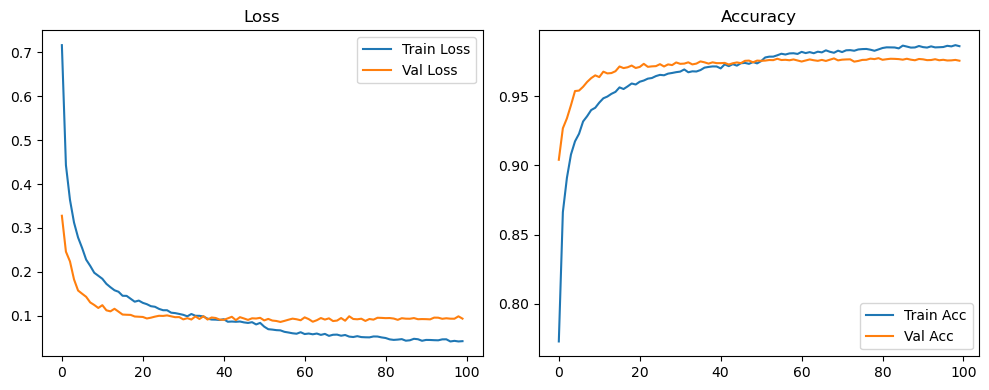

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3721, Acc: 0.8976 | Val Loss: 0.2002, Acc: 0.9378


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1331, Acc: 0.9591 | Val Loss: 0.1316, Acc: 0.9604


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9746 | Val Loss: 0.1083, Acc: 0.9645


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9799 | Val Loss: 0.1353, Acc: 0.9581


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9846 | Val Loss: 0.1080, Acc: 0.9670


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.1273, Acc: 0.9658


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0937, Acc: 0.9743


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.1218, Acc: 0.9680


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1077, Acc: 0.9714


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1060, Acc: 0.9723


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1097, Acc: 0.9733


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.1121, Acc: 0.9726


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1152, Acc: 0.9703


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1106, Acc: 0.9755


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1148, Acc: 0.9726


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.1135, Acc: 0.9748


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1132, Acc: 0.9742


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1340, Acc: 0.9708


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.1386, Acc: 0.9726


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1033, Acc: 0.9759


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1206, Acc: 0.9748


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1360, Acc: 0.9700


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1193, Acc: 0.9739


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1819, Acc: 0.9631


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.1274, Acc: 0.9739


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1212, Acc: 0.9752


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1274, Acc: 0.9753


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1441, Acc: 0.9702


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1244, Acc: 0.9750


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1427, Acc: 0.9731


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1354, Acc: 0.9753


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9741


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1240, Acc: 0.9768


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1381, Acc: 0.9744


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9760


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1119, Acc: 0.9768


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1289, Acc: 0.9735


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1209, Acc: 0.9764


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1590, Acc: 0.9711


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1436, Acc: 0.9742


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1611, Acc: 0.9698


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1390, Acc: 0.9746


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1296, Acc: 0.9757


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1160, Acc: 0.9773


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1416, Acc: 0.9758


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1383, Acc: 0.9764


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1486, Acc: 0.9732


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1405, Acc: 0.9774


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1299, Acc: 0.9762


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1194, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1349, Acc: 0.9748


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1469, Acc: 0.9760


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1255, Acc: 0.9769


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1456, Acc: 0.9746


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1330, Acc: 0.9757


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1366, Acc: 0.9748


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1332, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1378, Acc: 0.9728


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1187, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1437, Acc: 0.9751


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1244, Acc: 0.9754


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1286, Acc: 0.9770


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1342, Acc: 0.9759


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1245, Acc: 0.9766


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1280, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1276, Acc: 0.9762


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1269, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1319, Acc: 0.9762


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1337, Acc: 0.9763


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1474, Acc: 0.9764


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1358, Acc: 0.9782


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1324, Acc: 0.9742


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1611, Acc: 0.9736


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1253, Acc: 0.9774


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1687, Acc: 0.9733


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1236, Acc: 0.9781


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1429, Acc: 0.9778


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1480, Acc: 0.9748


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1616, Acc: 0.9762


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1294, Acc: 0.9789


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1257, Acc: 0.9781


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1308, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1356, Acc: 0.9788


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1447, Acc: 0.9778


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1302, Acc: 0.9768


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1227, Acc: 0.9778


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1485, Acc: 0.9758


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1455, Acc: 0.9758


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1296, Acc: 0.9771


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1406, Acc: 0.9777


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1657, Acc: 0.9735


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1301, Acc: 0.9790


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1294, Acc: 0.9778


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1326, Acc: 0.9782


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1495, Acc: 0.9758


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1443, Acc: 0.9749


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1444, Acc: 0.9757


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1638, Acc: 0.9732


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1593, Acc: 0.9757


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1362, Acc: 0.9764


Final Test Loss: 0.1317 Accuracy: 0.9779


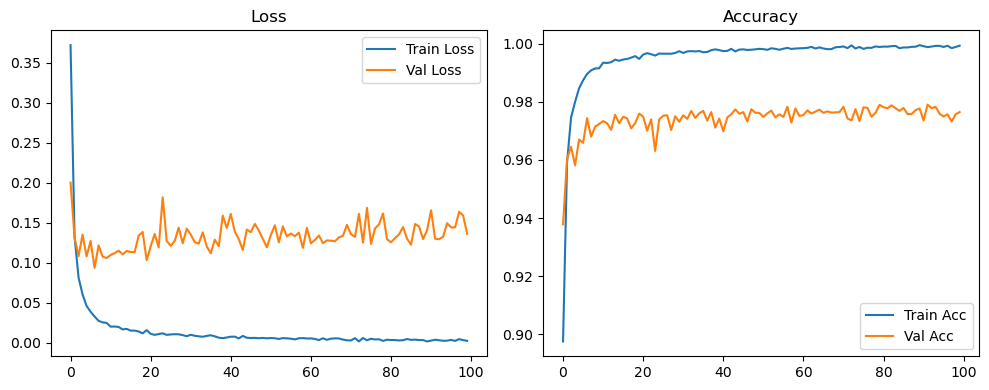

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5234, Acc: 0.8495 | Val Loss: 0.2678, Acc: 0.9182


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3103, Acc: 0.9065 | Val Loss: 0.2089, Acc: 0.9357


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2498, Acc: 0.9241 | Val Loss: 0.1764, Acc: 0.9467


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2147, Acc: 0.9356 | Val Loss: 0.1530, Acc: 0.9538


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1880, Acc: 0.9428 | Val Loss: 0.1445, Acc: 0.9560


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1696, Acc: 0.9481 | Val Loss: 0.1393, Acc: 0.9589


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1564, Acc: 0.9517 | Val Loss: 0.1285, Acc: 0.9630


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1395, Acc: 0.9567 | Val Loss: 0.1291, Acc: 0.9602


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1315, Acc: 0.9592 | Val Loss: 0.1255, Acc: 0.9631


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1259, Acc: 0.9595 | Val Loss: 0.1165, Acc: 0.9658


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1129, Acc: 0.9640 | Val Loss: 0.1236, Acc: 0.9647


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1062, Acc: 0.9656 | Val Loss: 0.1191, Acc: 0.9673


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1018, Acc: 0.9673 | Val Loss: 0.1143, Acc: 0.9673


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0955, Acc: 0.9689 | Val Loss: 0.1219, Acc: 0.9670


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0916, Acc: 0.9714 | Val Loss: 0.1121, Acc: 0.9688


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0862, Acc: 0.9724 | Val Loss: 0.1112, Acc: 0.9698


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0871, Acc: 0.9714 | Val Loss: 0.1104, Acc: 0.9692


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0794, Acc: 0.9747 | Val Loss: 0.1184, Acc: 0.9685


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9753 | Val Loss: 0.1151, Acc: 0.9705


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0742, Acc: 0.9759 | Val Loss: 0.1066, Acc: 0.9715


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9750 | Val Loss: 0.1112, Acc: 0.9705


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9780 | Val Loss: 0.1099, Acc: 0.9708


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9793 | Val Loss: 0.1192, Acc: 0.9710


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9790 | Val Loss: 0.1169, Acc: 0.9687


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0616, Acc: 0.9790 | Val Loss: 0.1084, Acc: 0.9714


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9804 | Val Loss: 0.1124, Acc: 0.9702


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9805 | Val Loss: 0.1106, Acc: 0.9721


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9818 | Val Loss: 0.1127, Acc: 0.9718


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9807 | Val Loss: 0.1171, Acc: 0.9721


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9819 | Val Loss: 0.1126, Acc: 0.9723


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9832 | Val Loss: 0.1182, Acc: 0.9706


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9831 | Val Loss: 0.1128, Acc: 0.9727


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9827 | Val Loss: 0.1097, Acc: 0.9727


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9839 | Val Loss: 0.1168, Acc: 0.9726


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9840 | Val Loss: 0.1130, Acc: 0.9725


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9840 | Val Loss: 0.1108, Acc: 0.9735


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.1120, Acc: 0.9724


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9852 | Val Loss: 0.1085, Acc: 0.9733


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.1190, Acc: 0.9732


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9841 | Val Loss: 0.1151, Acc: 0.9728


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9863 | Val Loss: 0.1165, Acc: 0.9724


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9871 | Val Loss: 0.1152, Acc: 0.9735


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.1195, Acc: 0.9718


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9861 | Val Loss: 0.1105, Acc: 0.9745


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9862 | Val Loss: 0.1162, Acc: 0.9749


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9878 | Val Loss: 0.1115, Acc: 0.9739


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.1148, Acc: 0.9751


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.1153, Acc: 0.9745


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.1133, Acc: 0.9741


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9881 | Val Loss: 0.1148, Acc: 0.9737


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9871 | Val Loss: 0.1108, Acc: 0.9744


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.1169, Acc: 0.9732


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9882 | Val Loss: 0.1136, Acc: 0.9753


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1126, Acc: 0.9759


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.1119, Acc: 0.9753


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.1119, Acc: 0.9743


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.1119, Acc: 0.9743


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.1084, Acc: 0.9761


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1189, Acc: 0.9737


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9893 | Val Loss: 0.1156, Acc: 0.9742


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1066, Acc: 0.9758


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9897 | Val Loss: 0.1144, Acc: 0.9751


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.1091, Acc: 0.9760


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.1176, Acc: 0.9751


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.1159, Acc: 0.9743


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9906 | Val Loss: 0.1132, Acc: 0.9757


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1235, Acc: 0.9744


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.1191, Acc: 0.9732


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.1163, Acc: 0.9752


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.1117, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.1165, Acc: 0.9754


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1158, Acc: 0.9740


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.1167, Acc: 0.9748


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1215, Acc: 0.9752


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9909 | Val Loss: 0.1181, Acc: 0.9747


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9909 | Val Loss: 0.1149, Acc: 0.9748


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.1213, Acc: 0.9751


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1211, Acc: 0.9744


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.1153, Acc: 0.9751


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9917 | Val Loss: 0.1184, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9919 | Val Loss: 0.1135, Acc: 0.9772


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.1140, Acc: 0.9755


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.1218, Acc: 0.9754


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.1166, Acc: 0.9766


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.1210, Acc: 0.9752


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1118, Acc: 0.9761


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.1180, Acc: 0.9753


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1192, Acc: 0.9757


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1140, Acc: 0.9758


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.1114, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.1152, Acc: 0.9761


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.1176, Acc: 0.9764


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.1158, Acc: 0.9759


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1201, Acc: 0.9743


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.1157, Acc: 0.9770


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.1127, Acc: 0.9751


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1133, Acc: 0.9774


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.1153, Acc: 0.9761


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.1161, Acc: 0.9762


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.1226, Acc: 0.9758


Final Test Loss: 0.1040 Accuracy: 0.9781


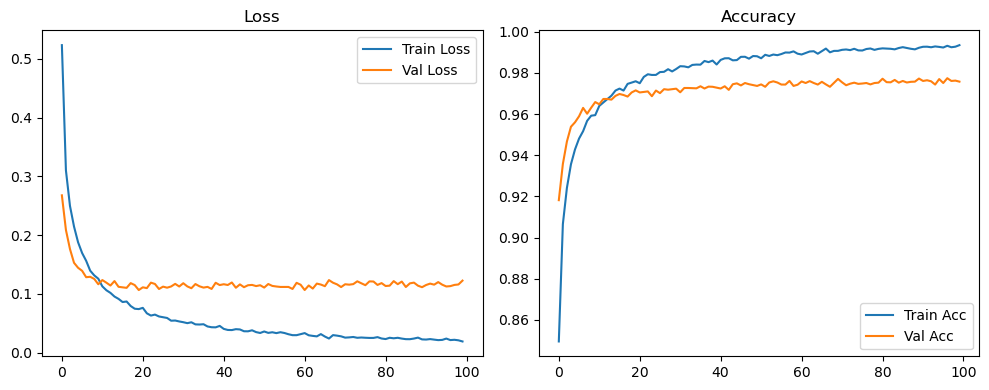

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.8309, Acc: 0.7399 | Val Loss: 0.3545, Acc: 0.8958


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.5036, Acc: 0.8461 | Val Loss: 0.2934, Acc: 0.9117


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.4303, Acc: 0.8698 | Val Loss: 0.2688, Acc: 0.9211


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3788, Acc: 0.8859 | Val Loss: 0.2350, Acc: 0.9284


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3459, Acc: 0.8961 | Val Loss: 0.2017, Acc: 0.9393


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3104, Acc: 0.9072 | Val Loss: 0.1916, Acc: 0.9433


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2886, Acc: 0.9145 | Val Loss: 0.1750, Acc: 0.9470


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2723, Acc: 0.9174 | Val Loss: 0.1660, Acc: 0.9492


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2492, Acc: 0.9253 | Val Loss: 0.1571, Acc: 0.9528


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2399, Acc: 0.9271 | Val Loss: 0.1472, Acc: 0.9552


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2287, Acc: 0.9315 | Val Loss: 0.1494, Acc: 0.9561


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.2122, Acc: 0.9366 | Val Loss: 0.1357, Acc: 0.9597


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.2081, Acc: 0.9370 | Val Loss: 0.1349, Acc: 0.9592


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1968, Acc: 0.9389 | Val Loss: 0.1330, Acc: 0.9599


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1892, Acc: 0.9415 | Val Loss: 0.1252, Acc: 0.9623


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1845, Acc: 0.9442 | Val Loss: 0.1212, Acc: 0.9650


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1790, Acc: 0.9445 | Val Loss: 0.1190, Acc: 0.9647


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1721, Acc: 0.9474 | Val Loss: 0.1201, Acc: 0.9645


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1678, Acc: 0.9482 | Val Loss: 0.1185, Acc: 0.9667


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1633, Acc: 0.9503 | Val Loss: 0.1116, Acc: 0.9666


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1608, Acc: 0.9512 | Val Loss: 0.1129, Acc: 0.9667


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1541, Acc: 0.9531 | Val Loss: 0.1109, Acc: 0.9666


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1492, Acc: 0.9549 | Val Loss: 0.1109, Acc: 0.9677


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1458, Acc: 0.9552 | Val Loss: 0.1115, Acc: 0.9680


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1393, Acc: 0.9564 | Val Loss: 0.1071, Acc: 0.9683


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1402, Acc: 0.9567 | Val Loss: 0.1102, Acc: 0.9690


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1389, Acc: 0.9573 | Val Loss: 0.1058, Acc: 0.9699


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1328, Acc: 0.9585 | Val Loss: 0.1038, Acc: 0.9708


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1315, Acc: 0.9584 | Val Loss: 0.1057, Acc: 0.9694


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1284, Acc: 0.9596 | Val Loss: 0.1054, Acc: 0.9709


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1271, Acc: 0.9600 | Val Loss: 0.1022, Acc: 0.9711


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1243, Acc: 0.9617 | Val Loss: 0.1063, Acc: 0.9704


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1233, Acc: 0.9613 | Val Loss: 0.1015, Acc: 0.9719


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1160, Acc: 0.9629 | Val Loss: 0.1025, Acc: 0.9722


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1194, Acc: 0.9626 | Val Loss: 0.1059, Acc: 0.9709


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1222, Acc: 0.9616 | Val Loss: 0.1019, Acc: 0.9718


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.1134, Acc: 0.9640 | Val Loss: 0.1007, Acc: 0.9721


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.1117, Acc: 0.9643 | Val Loss: 0.1055, Acc: 0.9722


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.1105, Acc: 0.9649 | Val Loss: 0.1057, Acc: 0.9729


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.1060, Acc: 0.9664 | Val Loss: 0.0995, Acc: 0.9729


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.1103, Acc: 0.9651 | Val Loss: 0.1022, Acc: 0.9708


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.1033, Acc: 0.9677 | Val Loss: 0.0989, Acc: 0.9728


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.1030, Acc: 0.9680 | Val Loss: 0.1042, Acc: 0.9717


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.1022, Acc: 0.9682 | Val Loss: 0.0994, Acc: 0.9728


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.1043, Acc: 0.9663 | Val Loss: 0.1002, Acc: 0.9728


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.1033, Acc: 0.9675 | Val Loss: 0.0998, Acc: 0.9721


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0992, Acc: 0.9684 | Val Loss: 0.1013, Acc: 0.9729


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.1001, Acc: 0.9685 | Val Loss: 0.1018, Acc: 0.9735


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0966, Acc: 0.9692 | Val Loss: 0.0978, Acc: 0.9740


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0958, Acc: 0.9693 | Val Loss: 0.0996, Acc: 0.9734


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0962, Acc: 0.9702 | Val Loss: 0.0991, Acc: 0.9730


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0985, Acc: 0.9699 | Val Loss: 0.0981, Acc: 0.9732


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0942, Acc: 0.9700 | Val Loss: 0.1011, Acc: 0.9731


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0934, Acc: 0.9703 | Val Loss: 0.0969, Acc: 0.9738


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0960, Acc: 0.9698 | Val Loss: 0.1003, Acc: 0.9730


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0903, Acc: 0.9710 | Val Loss: 0.0995, Acc: 0.9725


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0916, Acc: 0.9707 | Val Loss: 0.0977, Acc: 0.9737


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0885, Acc: 0.9715 | Val Loss: 0.0971, Acc: 0.9739


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0873, Acc: 0.9723 | Val Loss: 0.1028, Acc: 0.9728


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0883, Acc: 0.9710 | Val Loss: 0.0949, Acc: 0.9742


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0835, Acc: 0.9733 | Val Loss: 0.1017, Acc: 0.9730


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0838, Acc: 0.9732 | Val Loss: 0.1029, Acc: 0.9736


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0842, Acc: 0.9730 | Val Loss: 0.0964, Acc: 0.9734


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9740 | Val Loss: 0.1011, Acc: 0.9739


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0837, Acc: 0.9742 | Val Loss: 0.1015, Acc: 0.9737


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0833, Acc: 0.9732 | Val Loss: 0.0967, Acc: 0.9738


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0814, Acc: 0.9746 | Val Loss: 0.1007, Acc: 0.9746


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9732 | Val Loss: 0.0971, Acc: 0.9740


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0831, Acc: 0.9737 | Val Loss: 0.0949, Acc: 0.9747


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0779, Acc: 0.9750 | Val Loss: 0.0991, Acc: 0.9741


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0784, Acc: 0.9751 | Val Loss: 0.1006, Acc: 0.9749


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0764, Acc: 0.9751 | Val Loss: 0.0977, Acc: 0.9752


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0764, Acc: 0.9751 | Val Loss: 0.0946, Acc: 0.9754


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9762 | Val Loss: 0.0984, Acc: 0.9747


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0728, Acc: 0.9768 | Val Loss: 0.0988, Acc: 0.9754


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9758 | Val Loss: 0.0936, Acc: 0.9752


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9761 | Val Loss: 0.0914, Acc: 0.9748


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0768, Acc: 0.9757 | Val Loss: 0.0953, Acc: 0.9762


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9750 | Val Loss: 0.0977, Acc: 0.9748


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9769 | Val Loss: 0.0981, Acc: 0.9740


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0715, Acc: 0.9777 | Val Loss: 0.1014, Acc: 0.9742


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0753, Acc: 0.9763 | Val Loss: 0.0960, Acc: 0.9750


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0730, Acc: 0.9760 | Val Loss: 0.0998, Acc: 0.9742


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0726, Acc: 0.9771 | Val Loss: 0.0963, Acc: 0.9742


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9766 | Val Loss: 0.1009, Acc: 0.9740


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9786 | Val Loss: 0.0987, Acc: 0.9748


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0721, Acc: 0.9771 | Val Loss: 0.0948, Acc: 0.9758


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0717, Acc: 0.9770 | Val Loss: 0.0978, Acc: 0.9753


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9788 | Val Loss: 0.0989, Acc: 0.9747


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9775 | Val Loss: 0.0949, Acc: 0.9737


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9779 | Val Loss: 0.0986, Acc: 0.9742


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9775 | Val Loss: 0.0978, Acc: 0.9738


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9777 | Val Loss: 0.0962, Acc: 0.9750


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9774 | Val Loss: 0.0984, Acc: 0.9737


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9779 | Val Loss: 0.1033, Acc: 0.9742


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9770 | Val Loss: 0.0973, Acc: 0.9762


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0639, Acc: 0.9791 | Val Loss: 0.0999, Acc: 0.9741


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9778 | Val Loss: 0.0991, Acc: 0.9747


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9790 | Val Loss: 0.0985, Acc: 0.9749


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9780 | Val Loss: 0.1023, Acc: 0.9742


Final Test Loss: 0.0839 Accuracy: 0.9772


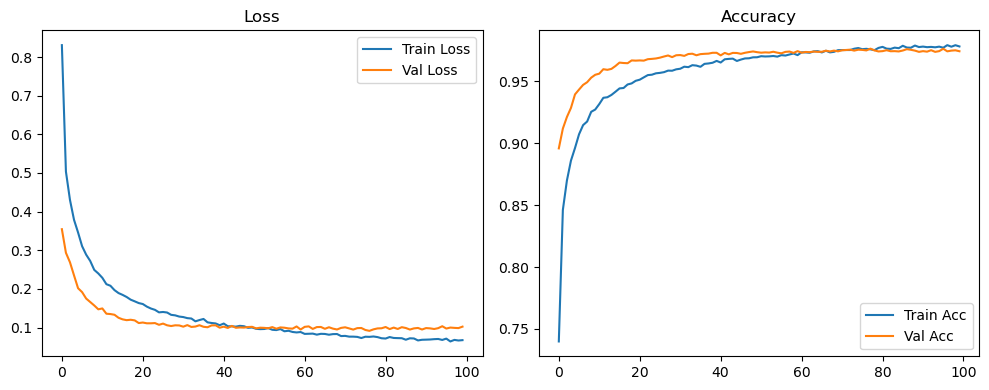

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4250, Acc: 0.8940 | Val Loss: 0.1948, Acc: 0.9417


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1380, Acc: 0.9589 | Val Loss: 0.1167, Acc: 0.9644


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0838, Acc: 0.9744 | Val Loss: 0.1061, Acc: 0.9657


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9821 | Val Loss: 0.0936, Acc: 0.9720


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.1210, Acc: 0.9655


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9874 | Val Loss: 0.1124, Acc: 0.9672


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0937, Acc: 0.9735


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1107, Acc: 0.9677


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.1080, Acc: 0.9706


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1152, Acc: 0.9678


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1108, Acc: 0.9718


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1067, Acc: 0.9737


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1160, Acc: 0.9706


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1109, Acc: 0.9735


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9945 | Val Loss: 0.1141, Acc: 0.9728


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0979, Acc: 0.9767


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1172, Acc: 0.9723


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1037, Acc: 0.9758


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1021, Acc: 0.9756


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1198, Acc: 0.9730


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1109, Acc: 0.9743


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1063, Acc: 0.9748


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1172, Acc: 0.9738


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1147, Acc: 0.9738


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1085, Acc: 0.9753


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1104, Acc: 0.9750


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1083, Acc: 0.9772


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9746


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1248, Acc: 0.9735


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1307, Acc: 0.9716


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1170, Acc: 0.9732


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1116, Acc: 0.9769


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1129, Acc: 0.9761


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1179, Acc: 0.9763


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1323, Acc: 0.9726


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1426, Acc: 0.9722


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1089, Acc: 0.9762


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1278, Acc: 0.9754


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1314, Acc: 0.9748


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1174, Acc: 0.9759


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1169, Acc: 0.9764


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1307, Acc: 0.9745


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1341, Acc: 0.9739


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1112, Acc: 0.9775


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1208, Acc: 0.9754


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1133, Acc: 0.9778


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1391, Acc: 0.9748


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1250, Acc: 0.9758


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1286, Acc: 0.9762


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1230, Acc: 0.9772


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1230, Acc: 0.9777


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1180, Acc: 0.9758


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1191, Acc: 0.9782


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1272, Acc: 0.9767


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1232, Acc: 0.9781


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1364, Acc: 0.9755


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1322, Acc: 0.9772


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1328, Acc: 0.9759


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1371, Acc: 0.9740


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1285, Acc: 0.9765


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1347, Acc: 0.9750


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1364, Acc: 0.9747


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1340, Acc: 0.9759


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1336, Acc: 0.9745


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1313, Acc: 0.9771


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1440, Acc: 0.9762


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1410, Acc: 0.9755


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1318, Acc: 0.9771


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1783, Acc: 0.9717


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1312, Acc: 0.9768


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1484, Acc: 0.9751


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1440, Acc: 0.9755


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1478, Acc: 0.9760


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1408, Acc: 0.9778


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1531, Acc: 0.9753


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1396, Acc: 0.9756


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1368, Acc: 0.9785


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1392, Acc: 0.9758


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1288, Acc: 0.9772


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1397, Acc: 0.9760


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1379, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1412, Acc: 0.9764


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1257, Acc: 0.9773


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1252, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1339, Acc: 0.9774


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1339, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1408, Acc: 0.9760


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1358, Acc: 0.9765


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1527, Acc: 0.9750


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1299, Acc: 0.9779


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1335, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1290, Acc: 0.9783


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1323, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1340, Acc: 0.9774


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1404, Acc: 0.9774


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1662, Acc: 0.9720


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1368, Acc: 0.9774


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1475, Acc: 0.9753


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1200, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1468, Acc: 0.9764


Final Test Loss: 0.1421 Accuracy: 0.9764


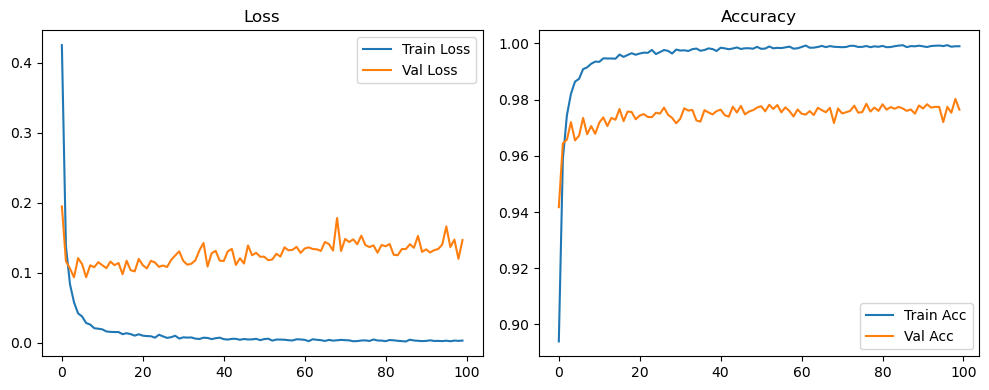

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6000, Acc: 0.8410 | Val Loss: 0.2834, Acc: 0.9133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3234, Acc: 0.9028 | Val Loss: 0.2118, Acc: 0.9344


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2625, Acc: 0.9209 | Val Loss: 0.1808, Acc: 0.9467


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2278, Acc: 0.9313 | Val Loss: 0.1576, Acc: 0.9527


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2014, Acc: 0.9385 | Val Loss: 0.1458, Acc: 0.9549


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1837, Acc: 0.9425 | Val Loss: 0.1425, Acc: 0.9583


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1715, Acc: 0.9469 | Val Loss: 0.1311, Acc: 0.9605


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1538, Acc: 0.9514 | Val Loss: 0.1325, Acc: 0.9605


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1459, Acc: 0.9539 | Val Loss: 0.1302, Acc: 0.9614


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1369, Acc: 0.9570 | Val Loss: 0.1200, Acc: 0.9654


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1282, Acc: 0.9598 | Val Loss: 0.1226, Acc: 0.9643


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1220, Acc: 0.9611 | Val Loss: 0.1202, Acc: 0.9663


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1163, Acc: 0.9627 | Val Loss: 0.1182, Acc: 0.9653


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1073, Acc: 0.9653 | Val Loss: 0.1129, Acc: 0.9676


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1072, Acc: 0.9669 | Val Loss: 0.1136, Acc: 0.9679


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0977, Acc: 0.9683 | Val Loss: 0.1142, Acc: 0.9678


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0964, Acc: 0.9690 | Val Loss: 0.1099, Acc: 0.9686


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0934, Acc: 0.9693 | Val Loss: 0.1101, Acc: 0.9694


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0877, Acc: 0.9714 | Val Loss: 0.1128, Acc: 0.9685


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0865, Acc: 0.9715 | Val Loss: 0.1100, Acc: 0.9692


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9716 | Val Loss: 0.1094, Acc: 0.9689


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9730 | Val Loss: 0.1088, Acc: 0.9695


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0752, Acc: 0.9753 | Val Loss: 0.1108, Acc: 0.9688


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0758, Acc: 0.9751 | Val Loss: 0.1147, Acc: 0.9688


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9749 | Val Loss: 0.1062, Acc: 0.9709


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0697, Acc: 0.9772 | Val Loss: 0.1074, Acc: 0.9713


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0712, Acc: 0.9766 | Val Loss: 0.1101, Acc: 0.9714


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0647, Acc: 0.9787 | Val Loss: 0.1102, Acc: 0.9718


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0665, Acc: 0.9776 | Val Loss: 0.1080, Acc: 0.9702


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9800 | Val Loss: 0.1087, Acc: 0.9708


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9801 | Val Loss: 0.1122, Acc: 0.9707


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9812 | Val Loss: 0.1074, Acc: 0.9722


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0624, Acc: 0.9792 | Val Loss: 0.1048, Acc: 0.9722


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0589, Acc: 0.9808 | Val Loss: 0.1130, Acc: 0.9702


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0555, Acc: 0.9810 | Val Loss: 0.1089, Acc: 0.9723


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1054, Acc: 0.9731


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9818 | Val Loss: 0.1133, Acc: 0.9718


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0545, Acc: 0.9821 | Val Loss: 0.1073, Acc: 0.9722


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9840 | Val Loss: 0.1092, Acc: 0.9719


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0504, Acc: 0.9830 | Val Loss: 0.1088, Acc: 0.9722


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9835 | Val Loss: 0.1060, Acc: 0.9723


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0457, Acc: 0.9846 | Val Loss: 0.1088, Acc: 0.9719


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9844 | Val Loss: 0.1108, Acc: 0.9710


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9844 | Val Loss: 0.1103, Acc: 0.9734


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9847 | Val Loss: 0.1110, Acc: 0.9724


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.1144, Acc: 0.9722


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9850 | Val Loss: 0.1105, Acc: 0.9726


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.1137, Acc: 0.9728


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9861 | Val Loss: 0.1152, Acc: 0.9732


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9854 | Val Loss: 0.1148, Acc: 0.9719


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1127, Acc: 0.9723


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9865 | Val Loss: 0.1144, Acc: 0.9720


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9865 | Val Loss: 0.1146, Acc: 0.9736


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9868 | Val Loss: 0.1115, Acc: 0.9723


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9861 | Val Loss: 0.1140, Acc: 0.9722


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.1097, Acc: 0.9735


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.1136, Acc: 0.9732


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9879 | Val Loss: 0.1139, Acc: 0.9722


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9880 | Val Loss: 0.1196, Acc: 0.9723


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.1165, Acc: 0.9733


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9878 | Val Loss: 0.1304, Acc: 0.9704


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.1232, Acc: 0.9719


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.1199, Acc: 0.9718


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9890 | Val Loss: 0.1233, Acc: 0.9722


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1185, Acc: 0.9722


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9888 | Val Loss: 0.1101, Acc: 0.9732


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9889 | Val Loss: 0.1140, Acc: 0.9743


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9888 | Val Loss: 0.1133, Acc: 0.9730


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.1147, Acc: 0.9736


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9890 | Val Loss: 0.1224, Acc: 0.9714


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.1219, Acc: 0.9719


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 0.1133, Acc: 0.9727


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.1182, Acc: 0.9730


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.1209, Acc: 0.9729


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9900 | Val Loss: 0.1149, Acc: 0.9744


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9893 | Val Loss: 0.1120, Acc: 0.9732


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.1137, Acc: 0.9741


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1223, Acc: 0.9735


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9902 | Val Loss: 0.1143, Acc: 0.9741


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1198, Acc: 0.9741


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9899 | Val Loss: 0.1160, Acc: 0.9730


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9899 | Val Loss: 0.1194, Acc: 0.9735


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9900 | Val Loss: 0.1153, Acc: 0.9763


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1178, Acc: 0.9746


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9900 | Val Loss: 0.1134, Acc: 0.9749


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.1137, Acc: 0.9756


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.1186, Acc: 0.9731


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 0.1204, Acc: 0.9731


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1184, Acc: 0.9738


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.1137, Acc: 0.9742


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9908 | Val Loss: 0.1157, Acc: 0.9742


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1181, Acc: 0.9742


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1170, Acc: 0.9747


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9904 | Val Loss: 0.1149, Acc: 0.9742


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.1174, Acc: 0.9741


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.1159, Acc: 0.9746


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.1113, Acc: 0.9748


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.1143, Acc: 0.9748


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.1189, Acc: 0.9740


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1214, Acc: 0.9742


Final Test Loss: 0.1053 Accuracy: 0.9778


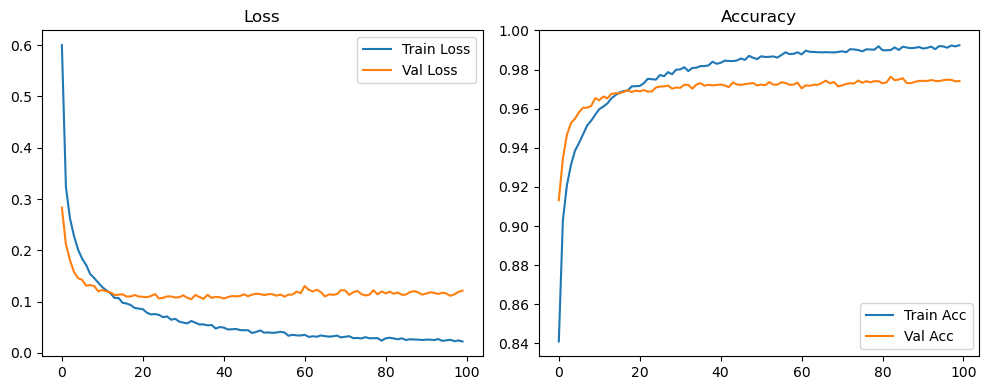

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9812, Acc: 0.6967 | Val Loss: 0.3875, Acc: 0.8898


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.5645, Acc: 0.8271 | Val Loss: 0.3212, Acc: 0.9043


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.4848, Acc: 0.8526 | Val Loss: 0.2968, Acc: 0.9123


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.4362, Acc: 0.8687 | Val Loss: 0.2722, Acc: 0.9198


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.4038, Acc: 0.8798 | Val Loss: 0.2476, Acc: 0.9257


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.3686, Acc: 0.8903 | Val Loss: 0.2361, Acc: 0.9287


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.3484, Acc: 0.8972 | Val Loss: 0.2216, Acc: 0.9343


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3312, Acc: 0.9019 | Val Loss: 0.2124, Acc: 0.9354


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.3115, Acc: 0.9065 | Val Loss: 0.1953, Acc: 0.9408


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.2955, Acc: 0.9121 | Val Loss: 0.1881, Acc: 0.9437


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.2827, Acc: 0.9160 | Val Loss: 0.1822, Acc: 0.9444


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.2633, Acc: 0.9209 | Val Loss: 0.1715, Acc: 0.9498


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2569, Acc: 0.9229 | Val Loss: 0.1683, Acc: 0.9495


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2444, Acc: 0.9262 | Val Loss: 0.1619, Acc: 0.9509


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2363, Acc: 0.9291 | Val Loss: 0.1625, Acc: 0.9502


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2272, Acc: 0.9325 | Val Loss: 0.1476, Acc: 0.9548


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.2195, Acc: 0.9337 | Val Loss: 0.1466, Acc: 0.9557


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.2147, Acc: 0.9334 | Val Loss: 0.1448, Acc: 0.9572


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.2052, Acc: 0.9377 | Val Loss: 0.1393, Acc: 0.9585


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.2004, Acc: 0.9397 | Val Loss: 0.1358, Acc: 0.9593


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1968, Acc: 0.9415 | Val Loss: 0.1344, Acc: 0.9602


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1919, Acc: 0.9414 | Val Loss: 0.1309, Acc: 0.9617


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1823, Acc: 0.9445 | Val Loss: 0.1276, Acc: 0.9628


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1814, Acc: 0.9451 | Val Loss: 0.1274, Acc: 0.9626


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1753, Acc: 0.9460 | Val Loss: 0.1238, Acc: 0.9639


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1719, Acc: 0.9474 | Val Loss: 0.1219, Acc: 0.9643


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1723, Acc: 0.9476 | Val Loss: 0.1226, Acc: 0.9646


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1651, Acc: 0.9490 | Val Loss: 0.1210, Acc: 0.9646


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1591, Acc: 0.9510 | Val Loss: 0.1183, Acc: 0.9657


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1584, Acc: 0.9510 | Val Loss: 0.1196, Acc: 0.9664


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1548, Acc: 0.9521 | Val Loss: 0.1178, Acc: 0.9663


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1528, Acc: 0.9524 | Val Loss: 0.1163, Acc: 0.9652


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1526, Acc: 0.9535 | Val Loss: 0.1133, Acc: 0.9661


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1408, Acc: 0.9556 | Val Loss: 0.1154, Acc: 0.9679


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1464, Acc: 0.9552 | Val Loss: 0.1148, Acc: 0.9673


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1461, Acc: 0.9552 | Val Loss: 0.1110, Acc: 0.9676


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1385, Acc: 0.9570 | Val Loss: 0.1091, Acc: 0.9697


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1374, Acc: 0.9570 | Val Loss: 0.1114, Acc: 0.9683


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1377, Acc: 0.9576 | Val Loss: 0.1123, Acc: 0.9680


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1297, Acc: 0.9580 | Val Loss: 0.1090, Acc: 0.9701


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1321, Acc: 0.9581 | Val Loss: 0.1079, Acc: 0.9688


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1278, Acc: 0.9598 | Val Loss: 0.1070, Acc: 0.9704


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1262, Acc: 0.9599 | Val Loss: 0.1114, Acc: 0.9692


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1267, Acc: 0.9609 | Val Loss: 0.1074, Acc: 0.9698


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1278, Acc: 0.9594 | Val Loss: 0.1115, Acc: 0.9697


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1235, Acc: 0.9607 | Val Loss: 0.1102, Acc: 0.9706


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1239, Acc: 0.9609 | Val Loss: 0.1086, Acc: 0.9705


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1213, Acc: 0.9628 | Val Loss: 0.1096, Acc: 0.9705


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1179, Acc: 0.9627 | Val Loss: 0.1065, Acc: 0.9712


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.1174, Acc: 0.9622 | Val Loss: 0.1052, Acc: 0.9716


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1171, Acc: 0.9636 | Val Loss: 0.1081, Acc: 0.9701


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.1152, Acc: 0.9633 | Val Loss: 0.1070, Acc: 0.9700


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.1158, Acc: 0.9630 | Val Loss: 0.1040, Acc: 0.9710


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.1142, Acc: 0.9646 | Val Loss: 0.1056, Acc: 0.9705


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.1110, Acc: 0.9641 | Val Loss: 0.1048, Acc: 0.9712


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.1122, Acc: 0.9639 | Val Loss: 0.1052, Acc: 0.9716


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.1098, Acc: 0.9657 | Val Loss: 0.1080, Acc: 0.9710


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.1062, Acc: 0.9659 | Val Loss: 0.1027, Acc: 0.9720


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.1067, Acc: 0.9662 | Val Loss: 0.1090, Acc: 0.9714


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.1084, Acc: 0.9658 | Val Loss: 0.1038, Acc: 0.9722


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.1012, Acc: 0.9666 | Val Loss: 0.1057, Acc: 0.9714


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.1029, Acc: 0.9677 | Val Loss: 0.1067, Acc: 0.9723


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.1031, Acc: 0.9673 | Val Loss: 0.1028, Acc: 0.9707


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9696 | Val Loss: 0.1088, Acc: 0.9711


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.1003, Acc: 0.9685 | Val Loss: 0.1066, Acc: 0.9708


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.1020, Acc: 0.9672 | Val Loss: 0.1063, Acc: 0.9705


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.1016, Acc: 0.9674 | Val Loss: 0.1044, Acc: 0.9715


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9694 | Val Loss: 0.1060, Acc: 0.9722


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0964, Acc: 0.9688 | Val Loss: 0.1051, Acc: 0.9728


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0966, Acc: 0.9685 | Val Loss: 0.1053, Acc: 0.9713


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0967, Acc: 0.9693 | Val Loss: 0.1048, Acc: 0.9732


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0933, Acc: 0.9700 | Val Loss: 0.1066, Acc: 0.9713


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0950, Acc: 0.9700 | Val Loss: 0.1038, Acc: 0.9726


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0948, Acc: 0.9702 | Val Loss: 0.1053, Acc: 0.9722


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0863, Acc: 0.9724 | Val Loss: 0.1066, Acc: 0.9722


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0953, Acc: 0.9697 | Val Loss: 0.1027, Acc: 0.9731


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0892, Acc: 0.9712 | Val Loss: 0.1010, Acc: 0.9735


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0956, Acc: 0.9701 | Val Loss: 0.1078, Acc: 0.9704


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0927, Acc: 0.9698 | Val Loss: 0.1054, Acc: 0.9718


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0900, Acc: 0.9711 | Val Loss: 0.1039, Acc: 0.9721


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0847, Acc: 0.9732 | Val Loss: 0.1061, Acc: 0.9726


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0917, Acc: 0.9716 | Val Loss: 0.1044, Acc: 0.9708


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9720 | Val Loss: 0.1016, Acc: 0.9739


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0836, Acc: 0.9732 | Val Loss: 0.1052, Acc: 0.9722


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0871, Acc: 0.9711 | Val Loss: 0.1049, Acc: 0.9719


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0847, Acc: 0.9723 | Val Loss: 0.1033, Acc: 0.9731


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0868, Acc: 0.9714 | Val Loss: 0.1039, Acc: 0.9736


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0859, Acc: 0.9723 | Val Loss: 0.1041, Acc: 0.9728


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9732 | Val Loss: 0.1058, Acc: 0.9722


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0820, Acc: 0.9728 | Val Loss: 0.1003, Acc: 0.9739


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9731 | Val Loss: 0.1011, Acc: 0.9728


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0792, Acc: 0.9741 | Val Loss: 0.1037, Acc: 0.9713


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0807, Acc: 0.9740 | Val Loss: 0.1039, Acc: 0.9731


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0851, Acc: 0.9722 | Val Loss: 0.1030, Acc: 0.9731


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9737 | Val Loss: 0.1048, Acc: 0.9731


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0844, Acc: 0.9731 | Val Loss: 0.0999, Acc: 0.9738


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9742 | Val Loss: 0.1065, Acc: 0.9718


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0802, Acc: 0.9739 | Val Loss: 0.0989, Acc: 0.9744


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0804, Acc: 0.9742 | Val Loss: 0.1018, Acc: 0.9740


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9735 | Val Loss: 0.1022, Acc: 0.9732


Final Test Loss: 0.0887 Accuracy: 0.9755


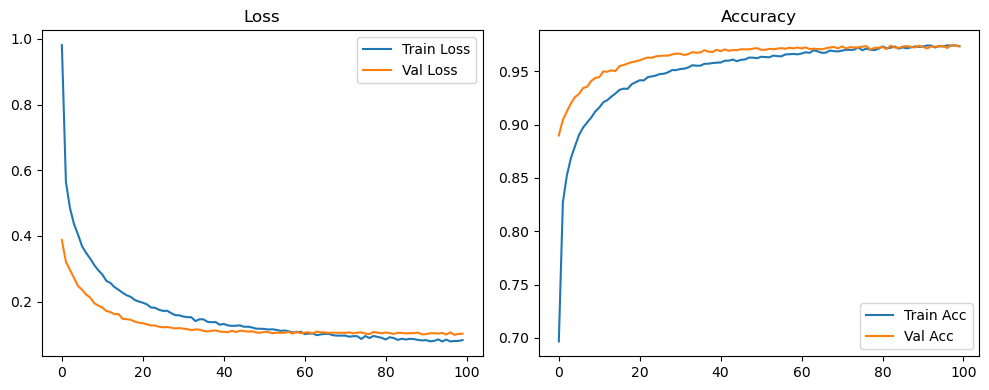

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3714, Acc: 0.8895 | Val Loss: 0.2327, Acc: 0.9297


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1688, Acc: 0.9483 | Val Loss: 0.1530, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1009, Acc: 0.9690 | Val Loss: 0.1197, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9759 | Val Loss: 0.1234, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9814 | Val Loss: 0.1262, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.1291, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.1385, Acc: 0.9650


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.1381, Acc: 0.9625


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9897 | Val Loss: 0.1323, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1394, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9918 | Val Loss: 0.1277, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1278, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1515, Acc: 0.9683


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1320, Acc: 0.9697


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.2000, Acc: 0.9560


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1353, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1475, Acc: 0.9675


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.1239, Acc: 0.9706


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1240, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1086, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1700, Acc: 0.9652


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1219, Acc: 0.9718


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1543, Acc: 0.9695


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1790, Acc: 0.9654


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1204, Acc: 0.9712


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1410, Acc: 0.9715


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1232, Acc: 0.9722


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1295, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1301, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1436, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1904, Acc: 0.9659


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1245, Acc: 0.9713


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1362, Acc: 0.9718


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1355, Acc: 0.9747


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.1590, Acc: 0.9704


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1594, Acc: 0.9719


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1439, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1558, Acc: 0.9720


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1447, Acc: 0.9738


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9738


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1538, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1260, Acc: 0.9728


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.1319, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1534, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1294, Acc: 0.9698


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1524, Acc: 0.9712


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1526, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.1587, Acc: 0.9662


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.1603, Acc: 0.9737


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1454, Acc: 0.9715


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1619, Acc: 0.9738


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1006, Acc: 0.9736


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1424, Acc: 0.9734


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1780, Acc: 0.9740


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1479, Acc: 0.9717


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1664, Acc: 0.9725


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1986, Acc: 0.9737


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1601, Acc: 0.9715


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1618, Acc: 0.9736


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.1586, Acc: 0.9722


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1456, Acc: 0.9710


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1412, Acc: 0.9716


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.1447, Acc: 0.9743


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1513, Acc: 0.9745


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1401, Acc: 0.9753


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1656, Acc: 0.9737


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1424, Acc: 0.9726


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1636, Acc: 0.9712


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1619, Acc: 0.9740


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1519, Acc: 0.9735


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1594, Acc: 0.9718


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.1417, Acc: 0.9737


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1493, Acc: 0.9722


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1668, Acc: 0.9737


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1221, Acc: 0.9720


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1709, Acc: 0.9749


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1822, Acc: 0.9732


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1289, Acc: 0.9749


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2005, Acc: 0.9738


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1411, Acc: 0.9730


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1441, Acc: 0.9749


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1564, Acc: 0.9759


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1716, Acc: 0.9760


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1132, Acc: 0.9727


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1525, Acc: 0.9737


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1576, Acc: 0.9738


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1701, Acc: 0.9708


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1571, Acc: 0.9704


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1666, Acc: 0.9661


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1614, Acc: 0.9710


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1263, Acc: 0.9768


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1802, Acc: 0.9747


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1758, Acc: 0.9722


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1375, Acc: 0.9756


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1818, Acc: 0.9752


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1435, Acc: 0.9768


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1300, Acc: 0.9745


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1742, Acc: 0.9742


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1798, Acc: 0.9732


Final Test Loss: 0.1614 Accuracy: 0.9770


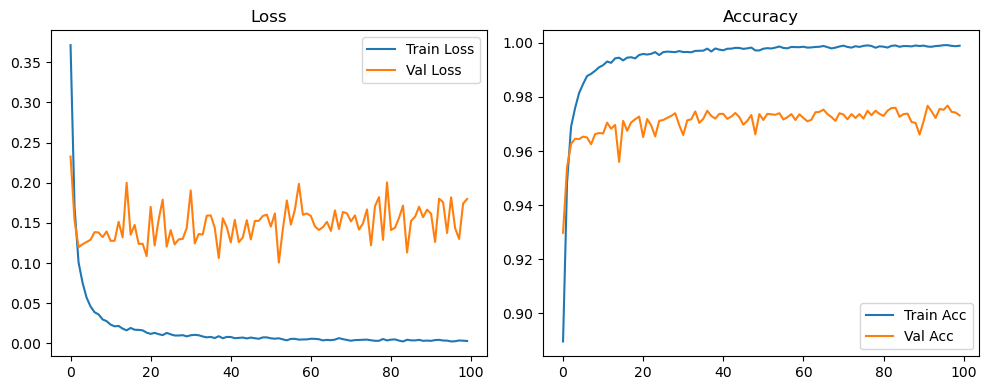

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4645, Acc: 0.8579 | Val Loss: 0.2510, Acc: 0.9256


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2577, Acc: 0.9239 | Val Loss: 0.1814, Acc: 0.9431


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1899, Acc: 0.9425 | Val Loss: 0.1664, Acc: 0.9506


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9539 | Val Loss: 0.1331, Acc: 0.9607


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9602 | Val Loss: 0.1236, Acc: 0.9633


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9660 | Val Loss: 0.1251, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9708 | Val Loss: 0.1046, Acc: 0.9701


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.1088, Acc: 0.9679


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9760 | Val Loss: 0.1121, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9767 | Val Loss: 0.1047, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 0.1042, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9812 | Val Loss: 0.1108, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9823 | Val Loss: 0.1043, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9840 | Val Loss: 0.1055, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.1093, Acc: 0.9714


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 0.0966, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.1157, Acc: 0.9726


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.1078, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0960, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1011, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.0990, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1107, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.1060, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.1027, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9897 | Val Loss: 0.1149, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.1131, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1045, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1151, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1004, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0924, Acc: 0.9767


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.1019, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.0995, Acc: 0.9775


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.1144, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1062, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0998, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1157, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1093, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1095, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1185, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1277, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1045, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1108, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1149, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1133, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.1205, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1156, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1010, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1110, Acc: 0.9774


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1174, Acc: 0.9780


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1190, Acc: 0.9768


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1062, Acc: 0.9778


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1165, Acc: 0.9764


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1149, Acc: 0.9784


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0867, Acc: 0.9778


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9773


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1203, Acc: 0.9771


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1291, Acc: 0.9769


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1109, Acc: 0.9771


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1127, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1191, Acc: 0.9768


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1075, Acc: 0.9782


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1156, Acc: 0.9776


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1146, Acc: 0.9762


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1130, Acc: 0.9759


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1003, Acc: 0.9777


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1238, Acc: 0.9766


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0901, Acc: 0.9774


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1298, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1164, Acc: 0.9771


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1004, Acc: 0.9767


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1124, Acc: 0.9791


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1364, Acc: 0.9767


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1255, Acc: 0.9773


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.1067, Acc: 0.9777


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1082, Acc: 0.9772


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1278, Acc: 0.9788


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1040, Acc: 0.9792


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1010, Acc: 0.9774


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1137, Acc: 0.9770


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1272, Acc: 0.9763


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1176, Acc: 0.9782


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1229, Acc: 0.9778


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0962, Acc: 0.9781


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1155, Acc: 0.9772


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1061, Acc: 0.9774


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1197, Acc: 0.9772


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1183, Acc: 0.9758


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1060, Acc: 0.9793


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1014, Acc: 0.9782


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0965, Acc: 0.9783


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1340, Acc: 0.9782


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1256, Acc: 0.9766


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1142, Acc: 0.9786


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1125, Acc: 0.9783


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0973, Acc: 0.9775


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9960 | Val Loss: 0.1211, Acc: 0.9776


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1032, Acc: 0.9788


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1036, Acc: 0.9773


Final Test Loss: 0.0872 Accuracy: 0.9809


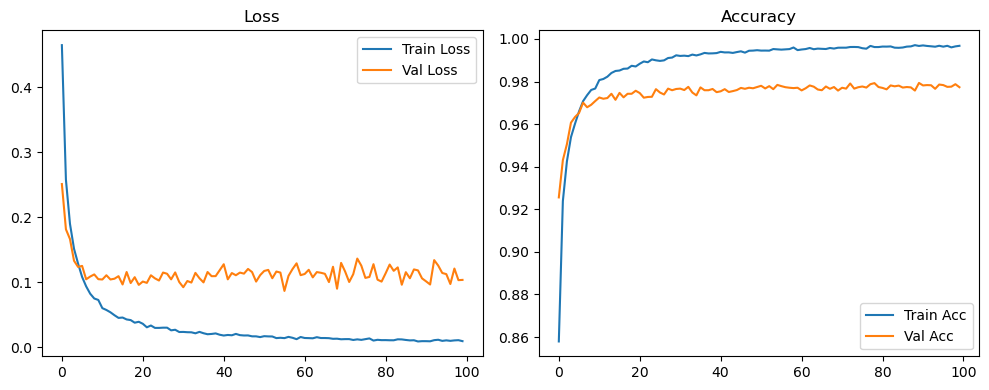

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6848, Acc: 0.7821 | Val Loss: 0.3256, Acc: 0.9016


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4065, Acc: 0.8801 | Val Loss: 0.2343, Acc: 0.9307


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3150, Acc: 0.9079 | Val Loss: 0.2033, Acc: 0.9403


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2625, Acc: 0.9242 | Val Loss: 0.1685, Acc: 0.9500


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2342, Acc: 0.9306 | Val Loss: 0.1508, Acc: 0.9556


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9381 | Val Loss: 0.1369, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1923, Acc: 0.9418 | Val Loss: 0.1304, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9464 | Val Loss: 0.1238, Acc: 0.9629


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9491 | Val Loss: 0.1200, Acc: 0.9649


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9523 | Val Loss: 0.1219, Acc: 0.9637


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1531, Acc: 0.9540 | Val Loss: 0.1129, Acc: 0.9670


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1412, Acc: 0.9567 | Val Loss: 0.1074, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9575 | Val Loss: 0.1041, Acc: 0.9699


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9597 | Val Loss: 0.1040, Acc: 0.9688


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9602 | Val Loss: 0.1005, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9624 | Val Loss: 0.1051, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9636 | Val Loss: 0.0997, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9653 | Val Loss: 0.1007, Acc: 0.9717


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1129, Acc: 0.9662 | Val Loss: 0.1030, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.0963, Acc: 0.9724


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.0945, Acc: 0.9720


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0974, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9693 | Val Loss: 0.0927, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0973, Acc: 0.9701 | Val Loss: 0.1030, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9692 | Val Loss: 0.0961, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9705 | Val Loss: 0.0988, Acc: 0.9718


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9720 | Val Loss: 0.0945, Acc: 0.9735


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9719 | Val Loss: 0.0935, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0894, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0880, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9727 | Val Loss: 0.0849, Acc: 0.9740


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9736 | Val Loss: 0.0878, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9744 | Val Loss: 0.0882, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9748 | Val Loss: 0.0923, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9755 | Val Loss: 0.0912, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9754 | Val Loss: 0.0952, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9762 | Val Loss: 0.0901, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0911, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9767 | Val Loss: 0.0905, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9760 | Val Loss: 0.0869, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.0952, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9777 | Val Loss: 0.0915, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9789 | Val Loss: 0.0928, Acc: 0.9756


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9781 | Val Loss: 0.0952, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9785 | Val Loss: 0.0936, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9774 | Val Loss: 0.1014, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9778 | Val Loss: 0.0856, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9791 | Val Loss: 0.0947, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9789 | Val Loss: 0.0873, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9758


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9790 | Val Loss: 0.0929, Acc: 0.9772


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9808 | Val Loss: 0.0922, Acc: 0.9763


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9803 | Val Loss: 0.0910, Acc: 0.9758


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9792 | Val Loss: 0.0930, Acc: 0.9764


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9816 | Val Loss: 0.0910, Acc: 0.9748


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9807 | Val Loss: 0.0857, Acc: 0.9756


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9817 | Val Loss: 0.0951, Acc: 0.9750


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9815 | Val Loss: 0.0916, Acc: 0.9762


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9816 | Val Loss: 0.0965, Acc: 0.9768


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9820 | Val Loss: 0.0882, Acc: 0.9766


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.0961, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9812 | Val Loss: 0.0946, Acc: 0.9764


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9830 | Val Loss: 0.0972, Acc: 0.9762


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9828 | Val Loss: 0.0886, Acc: 0.9752


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9821 | Val Loss: 0.0896, Acc: 0.9755


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9818 | Val Loss: 0.0907, Acc: 0.9764


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9830 | Val Loss: 0.0959, Acc: 0.9753


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9824 | Val Loss: 0.0940, Acc: 0.9762


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9831 | Val Loss: 0.0908, Acc: 0.9768


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9831 | Val Loss: 0.0954, Acc: 0.9757


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9835 | Val Loss: 0.0893, Acc: 0.9762


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9839 | Val Loss: 0.0895, Acc: 0.9765


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9831 | Val Loss: 0.1026, Acc: 0.9762


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9832 | Val Loss: 0.0941, Acc: 0.9757


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9845 | Val Loss: 0.0885, Acc: 0.9753


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9842 | Val Loss: 0.0836, Acc: 0.9760


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9835 | Val Loss: 0.0930, Acc: 0.9765


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9832 | Val Loss: 0.0911, Acc: 0.9768


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9837 | Val Loss: 0.0958, Acc: 0.9758


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 0.0879, Acc: 0.9751


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.0987, Acc: 0.9748


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9850 | Val Loss: 0.0910, Acc: 0.9754


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9849 | Val Loss: 0.0912, Acc: 0.9766


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9849 | Val Loss: 0.0958, Acc: 0.9755


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9844 | Val Loss: 0.0879, Acc: 0.9756


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0948, Acc: 0.9760


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.1073, Acc: 0.9759


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0843, Acc: 0.9755


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1000, Acc: 0.9760


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9866 | Val Loss: 0.1080, Acc: 0.9774


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 0.0922, Acc: 0.9768


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9858 | Val Loss: 0.0890, Acc: 0.9756


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9862 | Val Loss: 0.0943, Acc: 0.9757


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.0946, Acc: 0.9758


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.1149, Acc: 0.9752


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9856 | Val Loss: 0.0906, Acc: 0.9763


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.0961, Acc: 0.9756


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.1057, Acc: 0.9766


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9868 | Val Loss: 0.0932, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9860 | Val Loss: 0.1046, Acc: 0.9752


Final Test Loss: 0.0956 Accuracy: 0.9794


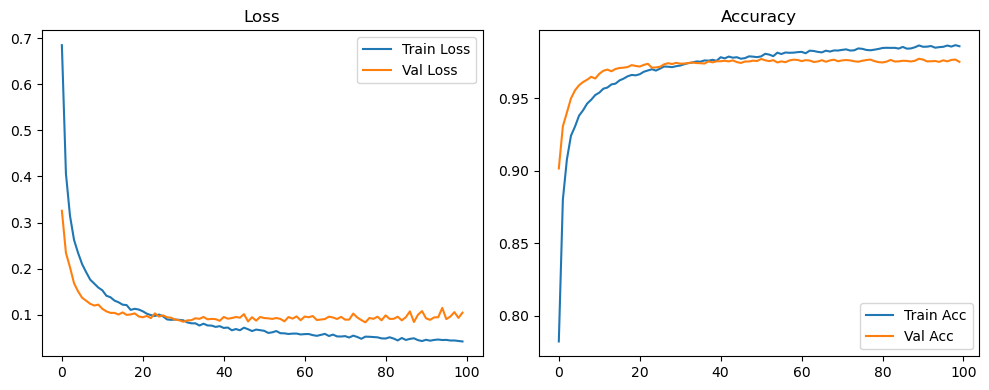

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3714, Acc: 0.8895 | Val Loss: 0.2327, Acc: 0.9297


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1688, Acc: 0.9483 | Val Loss: 0.1530, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1009, Acc: 0.9690 | Val Loss: 0.1197, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9759 | Val Loss: 0.1234, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9814 | Val Loss: 0.1262, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.1291, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.1385, Acc: 0.9650


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.1381, Acc: 0.9625


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9897 | Val Loss: 0.1323, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1394, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9918 | Val Loss: 0.1277, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1278, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1515, Acc: 0.9683


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1320, Acc: 0.9697


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.2000, Acc: 0.9560


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1353, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1475, Acc: 0.9675


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.1239, Acc: 0.9706


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1240, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1086, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1700, Acc: 0.9652


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1219, Acc: 0.9718


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1543, Acc: 0.9695


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1790, Acc: 0.9654


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1204, Acc: 0.9712


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1410, Acc: 0.9715


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1232, Acc: 0.9722


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1295, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1301, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1436, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1904, Acc: 0.9659


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1245, Acc: 0.9713


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1362, Acc: 0.9718


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1355, Acc: 0.9747


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.1590, Acc: 0.9704


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1594, Acc: 0.9719


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1439, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1558, Acc: 0.9720


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1447, Acc: 0.9738


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9738


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1538, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1260, Acc: 0.9728


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.1319, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1534, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1294, Acc: 0.9698


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1524, Acc: 0.9712


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1526, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.1587, Acc: 0.9662


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.1603, Acc: 0.9737


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1345, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1558, Acc: 0.9759


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1507, Acc: 0.9754


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1832, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1479, Acc: 0.9753


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1708, Acc: 0.9767


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1652, Acc: 0.9751


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1885, Acc: 0.9745


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1711, Acc: 0.9758


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1392, Acc: 0.9765


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1487, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1386, Acc: 0.9767


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1465, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1863, Acc: 0.9750


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1802, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1638, Acc: 0.9745


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1507, Acc: 0.9733


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1473, Acc: 0.9757


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1462, Acc: 0.9741


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1875, Acc: 0.9741


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1406, Acc: 0.9763


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1554, Acc: 0.9758


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1808, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1494, Acc: 0.9752


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1841, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1861, Acc: 0.9697


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1694, Acc: 0.9748


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1654, Acc: 0.9752


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1877, Acc: 0.9766


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1683, Acc: 0.9766


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1676, Acc: 0.9770


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1842, Acc: 0.9774


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1834, Acc: 0.9780


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1876, Acc: 0.9776


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1902, Acc: 0.9771


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1892, Acc: 0.9763


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1940, Acc: 0.9769


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1828, Acc: 0.9756


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2001, Acc: 0.9748


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2033, Acc: 0.9758


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1968, Acc: 0.9758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2148, Acc: 0.9768


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2254, Acc: 0.9753


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2104, Acc: 0.9751


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2236, Acc: 0.9768


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2081, Acc: 0.9766


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1780, Acc: 0.9751


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2107, Acc: 0.9758


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1866, Acc: 0.9766


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1929, Acc: 0.9779


Final Test Loss: 0.1717 Accuracy: 0.9790


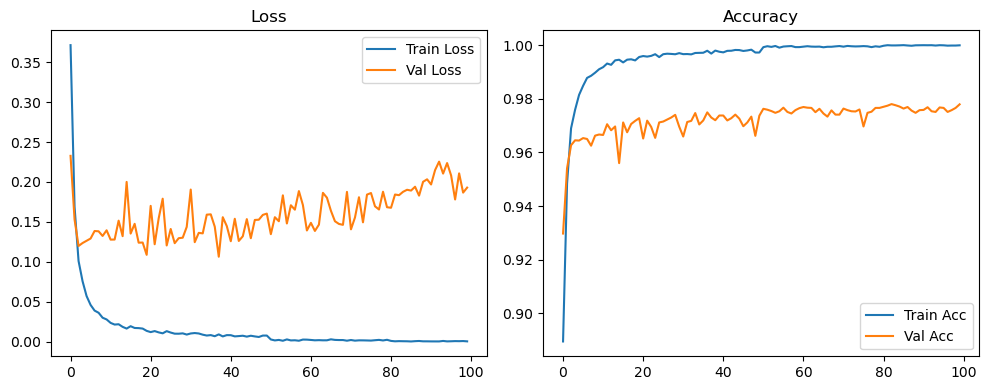

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4645, Acc: 0.8579 | Val Loss: 0.2510, Acc: 0.9256


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2577, Acc: 0.9239 | Val Loss: 0.1814, Acc: 0.9431


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1899, Acc: 0.9425 | Val Loss: 0.1664, Acc: 0.9506


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9539 | Val Loss: 0.1331, Acc: 0.9607


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9602 | Val Loss: 0.1236, Acc: 0.9633


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9660 | Val Loss: 0.1251, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9708 | Val Loss: 0.1046, Acc: 0.9701


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.1088, Acc: 0.9679


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9760 | Val Loss: 0.1121, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9767 | Val Loss: 0.1047, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 0.1042, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9812 | Val Loss: 0.1108, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9823 | Val Loss: 0.1043, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9840 | Val Loss: 0.1055, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.1093, Acc: 0.9714


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 0.0966, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.1157, Acc: 0.9726


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.1078, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0960, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1011, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.0990, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1107, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.1060, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.1027, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9897 | Val Loss: 0.1149, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.1131, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1045, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1151, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1004, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0924, Acc: 0.9767


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.1019, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.0995, Acc: 0.9775


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.1144, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1062, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0998, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1157, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1093, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1095, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1185, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1277, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1045, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1108, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1149, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1133, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.1205, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1156, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1010, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1110, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1100, Acc: 0.9786


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1091, Acc: 0.9780


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9786


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1084, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1065, Acc: 0.9781


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1211, Acc: 0.9773


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1212, Acc: 0.9788


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1065, Acc: 0.9781


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1166, Acc: 0.9785


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1149, Acc: 0.9784


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1190, Acc: 0.9786


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1059, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1175, Acc: 0.9790


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9789


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1154, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1127, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1094, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.1286, Acc: 0.9782


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1173, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1142, Acc: 0.9801


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1373, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1245, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1178, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1172, Acc: 0.9791


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1304, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1252, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1101, Acc: 0.9793


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1204, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1219, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1237, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1276, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1299, Acc: 0.9790


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1299, Acc: 0.9801


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1236, Acc: 0.9797


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1244, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1387, Acc: 0.9794


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1289, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1392, Acc: 0.9798


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1275, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1418, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1335, Acc: 0.9788


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1214, Acc: 0.9799


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1240, Acc: 0.9786


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1216, Acc: 0.9792


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1286, Acc: 0.9804


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1373, Acc: 0.9808


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1358, Acc: 0.9802


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1276, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1338, Acc: 0.9785


Final Test Loss: 0.1216 Accuracy: 0.9816


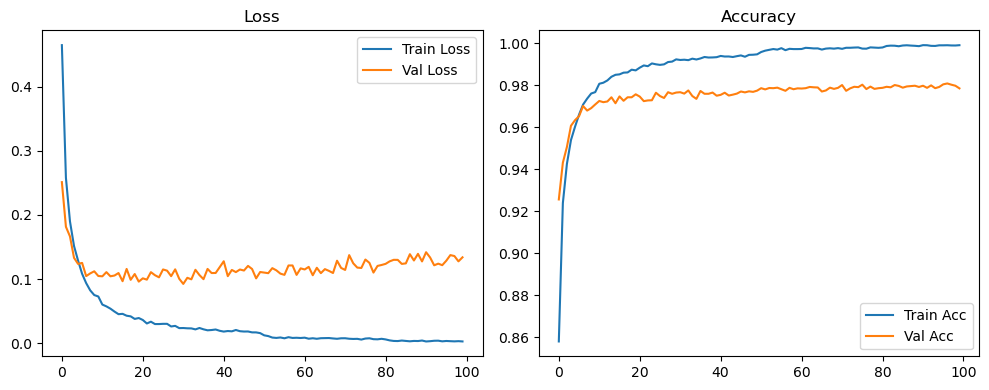

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6848, Acc: 0.7821 | Val Loss: 0.3256, Acc: 0.9016


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4065, Acc: 0.8801 | Val Loss: 0.2343, Acc: 0.9307


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3150, Acc: 0.9079 | Val Loss: 0.2033, Acc: 0.9403


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2625, Acc: 0.9242 | Val Loss: 0.1685, Acc: 0.9500


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2342, Acc: 0.9306 | Val Loss: 0.1508, Acc: 0.9556


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9381 | Val Loss: 0.1369, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1923, Acc: 0.9418 | Val Loss: 0.1304, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9464 | Val Loss: 0.1238, Acc: 0.9629


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9491 | Val Loss: 0.1200, Acc: 0.9649


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9523 | Val Loss: 0.1219, Acc: 0.9637


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1531, Acc: 0.9540 | Val Loss: 0.1129, Acc: 0.9670


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1412, Acc: 0.9567 | Val Loss: 0.1074, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9575 | Val Loss: 0.1041, Acc: 0.9699


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9597 | Val Loss: 0.1040, Acc: 0.9688


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9602 | Val Loss: 0.1005, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9624 | Val Loss: 0.1051, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9636 | Val Loss: 0.0997, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9653 | Val Loss: 0.1007, Acc: 0.9717


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1129, Acc: 0.9662 | Val Loss: 0.1030, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.0963, Acc: 0.9724


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.0945, Acc: 0.9720


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0974, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9693 | Val Loss: 0.0927, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0973, Acc: 0.9701 | Val Loss: 0.1030, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9692 | Val Loss: 0.0961, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9705 | Val Loss: 0.0988, Acc: 0.9718


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9720 | Val Loss: 0.0945, Acc: 0.9735


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9719 | Val Loss: 0.0935, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0894, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0880, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9727 | Val Loss: 0.0849, Acc: 0.9740


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9736 | Val Loss: 0.0878, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9744 | Val Loss: 0.0882, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9748 | Val Loss: 0.0923, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9755 | Val Loss: 0.0912, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9754 | Val Loss: 0.0952, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9762 | Val Loss: 0.0901, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0911, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9767 | Val Loss: 0.0905, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9760 | Val Loss: 0.0869, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.0952, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9777 | Val Loss: 0.0915, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9789 | Val Loss: 0.0928, Acc: 0.9756


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9781 | Val Loss: 0.0952, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9785 | Val Loss: 0.0936, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9774 | Val Loss: 0.1014, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9778 | Val Loss: 0.0856, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9791 | Val Loss: 0.0947, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9789 | Val Loss: 0.0873, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9814 | Val Loss: 0.0876, Acc: 0.9771


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9830 | Val Loss: 0.0873, Acc: 0.9777


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0898, Acc: 0.9774


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9837 | Val Loss: 0.0871, Acc: 0.9776


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 0.0908, Acc: 0.9771


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9848 | Val Loss: 0.0890, Acc: 0.9775


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.0920, Acc: 0.9769


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0925, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9854 | Val Loss: 0.0946, Acc: 0.9767


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.0898, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 0.0994, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9851 | Val Loss: 0.0990, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9864 | Val Loss: 0.0942, Acc: 0.9762


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.0935, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.0930, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9861 | Val Loss: 0.0961, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 0.0888, Acc: 0.9770


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.0966, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.0985, Acc: 0.9769


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9862 | Val Loss: 0.0926, Acc: 0.9759


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0937, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.0993, Acc: 0.9771


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9869 | Val Loss: 0.0971, Acc: 0.9771


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9870 | Val Loss: 0.0961, Acc: 0.9763


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9869 | Val Loss: 0.0962, Acc: 0.9766


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.0865, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.1061, Acc: 0.9767


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.0970, Acc: 0.9751


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9869 | Val Loss: 0.0969, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1006, Acc: 0.9768


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0967, Acc: 0.9770


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 0.0972, Acc: 0.9769


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0967, Acc: 0.9771


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.1018, Acc: 0.9774


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.0923, Acc: 0.9758


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0971, Acc: 0.9769


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.0942, Acc: 0.9772


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0918, Acc: 0.9772


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0970, Acc: 0.9764


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 0.0986, Acc: 0.9778


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0951, Acc: 0.9766


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.0909, Acc: 0.9763


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0922, Acc: 0.9767


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9904 | Val Loss: 0.1008, Acc: 0.9770


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.1041, Acc: 0.9760


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9902 | Val Loss: 0.1015, Acc: 0.9759


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0950, Acc: 0.9763


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0921, Acc: 0.9765


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.0941, Acc: 0.9756


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.0990, Acc: 0.9764


Final Test Loss: 0.0898 Accuracy: 0.9799


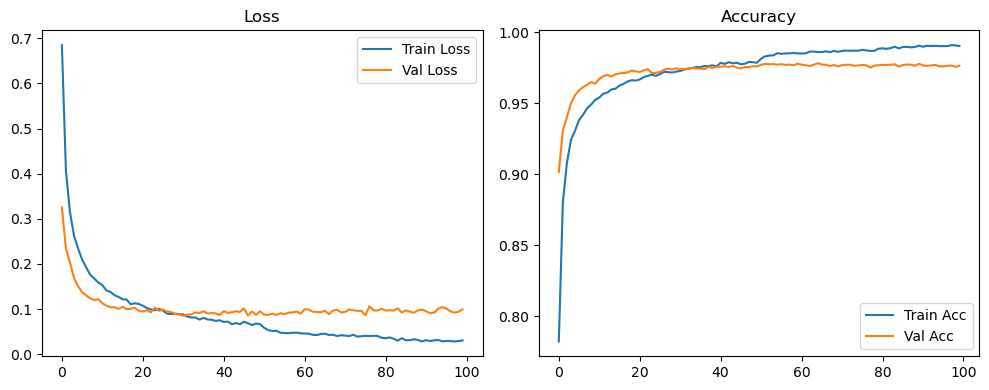

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3714, Acc: 0.8895 | Val Loss: 0.2327, Acc: 0.9297


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1688, Acc: 0.9483 | Val Loss: 0.1530, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1009, Acc: 0.9690 | Val Loss: 0.1197, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9759 | Val Loss: 0.1234, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9814 | Val Loss: 0.1262, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.1291, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.1385, Acc: 0.9650


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.1381, Acc: 0.9625


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9897 | Val Loss: 0.1323, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1394, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9918 | Val Loss: 0.1277, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1278, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1515, Acc: 0.9683


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1320, Acc: 0.9697


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.2000, Acc: 0.9560


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1353, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1475, Acc: 0.9675


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.1239, Acc: 0.9706


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1240, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1086, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1700, Acc: 0.9652


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1219, Acc: 0.9718


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1543, Acc: 0.9695


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1790, Acc: 0.9654


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1204, Acc: 0.9712


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1410, Acc: 0.9715


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1232, Acc: 0.9722


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1295, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1301, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1436, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1904, Acc: 0.9659


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1245, Acc: 0.9713


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1362, Acc: 0.9718


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1355, Acc: 0.9747


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.1590, Acc: 0.9704


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1594, Acc: 0.9719


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1439, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1558, Acc: 0.9720


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1447, Acc: 0.9738


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9738


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1538, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1260, Acc: 0.9728


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.1319, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1534, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1294, Acc: 0.9698


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1524, Acc: 0.9712


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1526, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.1587, Acc: 0.9662


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.1603, Acc: 0.9737


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1345, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1558, Acc: 0.9759


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1507, Acc: 0.9754


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1832, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1479, Acc: 0.9753


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1708, Acc: 0.9767


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1652, Acc: 0.9751


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1885, Acc: 0.9745


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1711, Acc: 0.9758


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1392, Acc: 0.9765


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1487, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1386, Acc: 0.9767


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1465, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1863, Acc: 0.9750


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1802, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1638, Acc: 0.9745


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1507, Acc: 0.9733


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1473, Acc: 0.9757


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1462, Acc: 0.9741


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1875, Acc: 0.9741


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1406, Acc: 0.9763


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1554, Acc: 0.9758


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1808, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1494, Acc: 0.9752


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1841, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1861, Acc: 0.9697


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1694, Acc: 0.9748


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1654, Acc: 0.9752


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1877, Acc: 0.9766


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1683, Acc: 0.9766


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1673, Acc: 0.9771


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1790, Acc: 0.9773


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1813, Acc: 0.9777


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1837, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1767, Acc: 0.9770


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1779, Acc: 0.9777


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1894, Acc: 0.9770


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1975, Acc: 0.9768


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2044, Acc: 0.9767


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1942, Acc: 0.9773


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1967, Acc: 0.9778


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1873, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1934, Acc: 0.9781


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2013, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2001, Acc: 0.9779


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1917, Acc: 0.9781


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1969, Acc: 0.9772


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1966, Acc: 0.9780


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1943, Acc: 0.9778


Final Test Loss: 0.1566 Accuracy: 0.9808


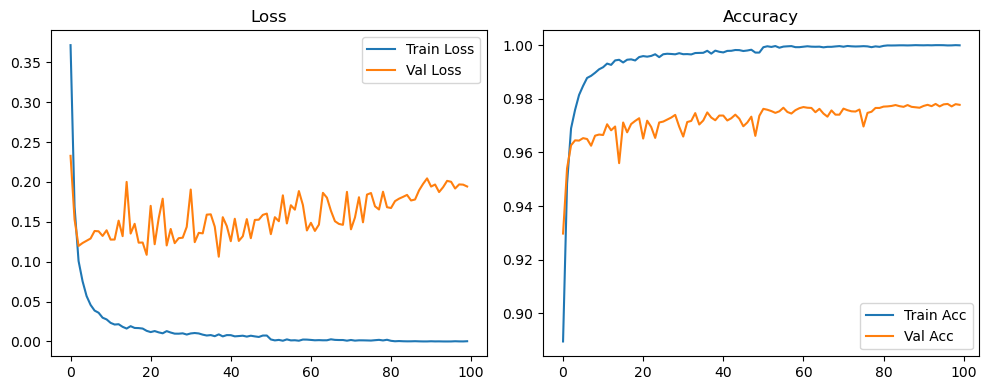

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4645, Acc: 0.8579 | Val Loss: 0.2510, Acc: 0.9256


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2577, Acc: 0.9239 | Val Loss: 0.1814, Acc: 0.9431


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1899, Acc: 0.9425 | Val Loss: 0.1664, Acc: 0.9506


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9539 | Val Loss: 0.1331, Acc: 0.9607


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9602 | Val Loss: 0.1236, Acc: 0.9633


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9660 | Val Loss: 0.1251, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9708 | Val Loss: 0.1046, Acc: 0.9701


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.1088, Acc: 0.9679


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9760 | Val Loss: 0.1121, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9767 | Val Loss: 0.1047, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 0.1042, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9812 | Val Loss: 0.1108, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9823 | Val Loss: 0.1043, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9840 | Val Loss: 0.1055, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.1093, Acc: 0.9714


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 0.0966, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.1157, Acc: 0.9726


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.1078, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0960, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1011, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.0990, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1107, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.1060, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.1027, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9897 | Val Loss: 0.1149, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.1131, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1045, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1151, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1004, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0924, Acc: 0.9767


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.1019, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.0995, Acc: 0.9775


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.1144, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1062, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0998, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1157, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1093, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1095, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1185, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1277, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1045, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1108, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1149, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1133, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.1205, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1156, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1010, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1110, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1100, Acc: 0.9786


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1091, Acc: 0.9780


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9786


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1084, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1065, Acc: 0.9781


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1211, Acc: 0.9773


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1212, Acc: 0.9788


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1065, Acc: 0.9781


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1166, Acc: 0.9785


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1149, Acc: 0.9784


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1190, Acc: 0.9786


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1059, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1175, Acc: 0.9790


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9789


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1154, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1127, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1094, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.1286, Acc: 0.9782


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1173, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1142, Acc: 0.9801


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1373, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1245, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1178, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1172, Acc: 0.9791


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1304, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1252, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1101, Acc: 0.9793


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1204, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1219, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1193, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1199, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1227, Acc: 0.9794


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1259, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1287, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1273, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1298, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1277, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1302, Acc: 0.9801


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1240, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1289, Acc: 0.9796


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1257, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1282, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1231, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1289, Acc: 0.9800


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1281, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1323, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1341, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1361, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1300, Acc: 0.9794


Final Test Loss: 0.1149 Accuracy: 0.9821


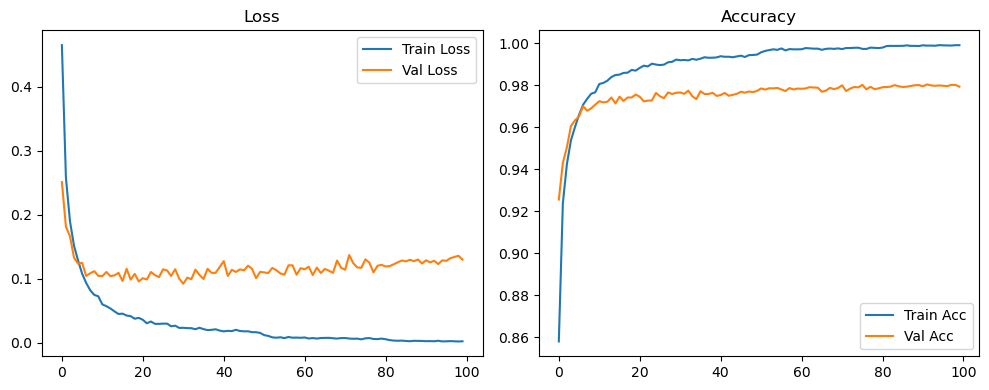

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6848, Acc: 0.7821 | Val Loss: 0.3256, Acc: 0.9016


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4065, Acc: 0.8801 | Val Loss: 0.2343, Acc: 0.9307


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3150, Acc: 0.9079 | Val Loss: 0.2033, Acc: 0.9403


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2625, Acc: 0.9242 | Val Loss: 0.1685, Acc: 0.9500


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2342, Acc: 0.9306 | Val Loss: 0.1508, Acc: 0.9556


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9381 | Val Loss: 0.1369, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1923, Acc: 0.9418 | Val Loss: 0.1304, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9464 | Val Loss: 0.1238, Acc: 0.9629


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9491 | Val Loss: 0.1200, Acc: 0.9649


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9523 | Val Loss: 0.1219, Acc: 0.9637


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1531, Acc: 0.9540 | Val Loss: 0.1129, Acc: 0.9670


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1412, Acc: 0.9567 | Val Loss: 0.1074, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9575 | Val Loss: 0.1041, Acc: 0.9699


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9597 | Val Loss: 0.1040, Acc: 0.9688


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9602 | Val Loss: 0.1005, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9624 | Val Loss: 0.1051, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9636 | Val Loss: 0.0997, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9653 | Val Loss: 0.1007, Acc: 0.9717


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1129, Acc: 0.9662 | Val Loss: 0.1030, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.0963, Acc: 0.9724


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.0945, Acc: 0.9720


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0974, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9693 | Val Loss: 0.0927, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0973, Acc: 0.9701 | Val Loss: 0.1030, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9692 | Val Loss: 0.0961, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9705 | Val Loss: 0.0988, Acc: 0.9718


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9720 | Val Loss: 0.0945, Acc: 0.9735


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9719 | Val Loss: 0.0935, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0894, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0880, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9727 | Val Loss: 0.0849, Acc: 0.9740


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9736 | Val Loss: 0.0878, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9744 | Val Loss: 0.0882, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9748 | Val Loss: 0.0923, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9755 | Val Loss: 0.0912, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9754 | Val Loss: 0.0952, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9762 | Val Loss: 0.0901, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0911, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9767 | Val Loss: 0.0905, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9760 | Val Loss: 0.0869, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.0952, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9777 | Val Loss: 0.0915, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9789 | Val Loss: 0.0928, Acc: 0.9756


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9781 | Val Loss: 0.0952, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9785 | Val Loss: 0.0936, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9774 | Val Loss: 0.1014, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9778 | Val Loss: 0.0856, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9791 | Val Loss: 0.0947, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9789 | Val Loss: 0.0873, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9814 | Val Loss: 0.0876, Acc: 0.9771


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9830 | Val Loss: 0.0873, Acc: 0.9777


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0898, Acc: 0.9774


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9837 | Val Loss: 0.0871, Acc: 0.9776


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 0.0908, Acc: 0.9771


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9848 | Val Loss: 0.0890, Acc: 0.9775


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.0920, Acc: 0.9769


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0925, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9854 | Val Loss: 0.0946, Acc: 0.9767


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.0898, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 0.0994, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9851 | Val Loss: 0.0990, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9864 | Val Loss: 0.0942, Acc: 0.9762


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.0935, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.0930, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9861 | Val Loss: 0.0961, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 0.0888, Acc: 0.9770


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.0966, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.0985, Acc: 0.9769


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9862 | Val Loss: 0.0926, Acc: 0.9759


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0937, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.0993, Acc: 0.9771


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9869 | Val Loss: 0.0971, Acc: 0.9771


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9870 | Val Loss: 0.0961, Acc: 0.9763


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9869 | Val Loss: 0.0962, Acc: 0.9766


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.0865, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.1061, Acc: 0.9767


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.0970, Acc: 0.9751


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9869 | Val Loss: 0.0969, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1006, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0950, Acc: 0.9771


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.0968, Acc: 0.9777


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0977, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9894 | Val Loss: 0.0969, Acc: 0.9775


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0947, Acc: 0.9761


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0963, Acc: 0.9770


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.0936, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.0921, Acc: 0.9774


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0958, Acc: 0.9769


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.0978, Acc: 0.9766


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0960, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0940, Acc: 0.9770


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0946, Acc: 0.9770


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.0986, Acc: 0.9766


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9905 | Val Loss: 0.0971, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9901 | Val Loss: 0.0998, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.0930, Acc: 0.9768


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9917 | Val Loss: 0.0929, Acc: 0.9774


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.0948, Acc: 0.9764


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.0951, Acc: 0.9774


Final Test Loss: 0.0897 Accuracy: 0.9802


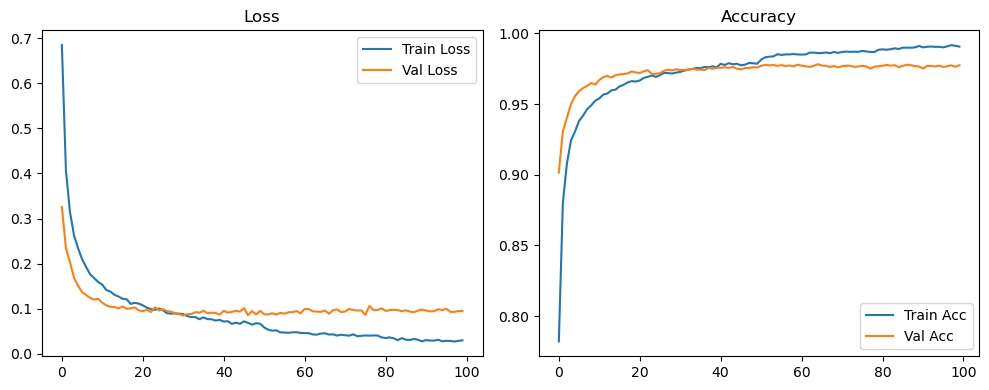

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3714, Acc: 0.8895 | Val Loss: 0.2327, Acc: 0.9297


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1688, Acc: 0.9483 | Val Loss: 0.1530, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1009, Acc: 0.9690 | Val Loss: 0.1197, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9759 | Val Loss: 0.1234, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9814 | Val Loss: 0.1262, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.1291, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.1385, Acc: 0.9650


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.1381, Acc: 0.9625


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9897 | Val Loss: 0.1323, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1394, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9918 | Val Loss: 0.1277, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1278, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.1515, Acc: 0.9683


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1320, Acc: 0.9697


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.2000, Acc: 0.9560


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1353, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1475, Acc: 0.9675


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.1239, Acc: 0.9706


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1240, Acc: 0.9718


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1086, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1700, Acc: 0.9652


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1219, Acc: 0.9718


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1543, Acc: 0.9695


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1790, Acc: 0.9654


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1204, Acc: 0.9712


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1410, Acc: 0.9715


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1232, Acc: 0.9722


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1295, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1301, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1436, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1904, Acc: 0.9659


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1245, Acc: 0.9713


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1362, Acc: 0.9718


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1355, Acc: 0.9747


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.1590, Acc: 0.9704


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1594, Acc: 0.9719


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1439, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1558, Acc: 0.9720


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1447, Acc: 0.9738


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9738


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1538, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1260, Acc: 0.9728


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.1319, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1534, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1294, Acc: 0.9698


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1524, Acc: 0.9712


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1526, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.1587, Acc: 0.9662


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.1603, Acc: 0.9737


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1384, Acc: 0.9760


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1451, Acc: 0.9767


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1540, Acc: 0.9770


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1574, Acc: 0.9769


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1529, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1669, Acc: 0.9766


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1614, Acc: 0.9760


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1807, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1769, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1882, Acc: 0.9768


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1854, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1802, Acc: 0.9755


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1783, Acc: 0.9764


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1774, Acc: 0.9767


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1840, Acc: 0.9765


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2004, Acc: 0.9772


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1691, Acc: 0.9766


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1801, Acc: 0.9762


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1914, Acc: 0.9771


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1988, Acc: 0.9755


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1940, Acc: 0.9764


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1986, Acc: 0.9762


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2029, Acc: 0.9752


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1923, Acc: 0.9758


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2031, Acc: 0.9758


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2037, Acc: 0.9761


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1723, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1813, Acc: 0.9771


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1991, Acc: 0.9761


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2044, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2063, Acc: 0.9760


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2084, Acc: 0.9759


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2080, Acc: 0.9766


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2033, Acc: 0.9773


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2047, Acc: 0.9767


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2047, Acc: 0.9771


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1957, Acc: 0.9774


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2031, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1870, Acc: 0.9780


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1901, Acc: 0.9776


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1877, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1940, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2055, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2108, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2090, Acc: 0.9770


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2076, Acc: 0.9769


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2117, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2014, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2083, Acc: 0.9770


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2140, Acc: 0.9769


Final Test Loss: 0.1789 Accuracy: 0.9803


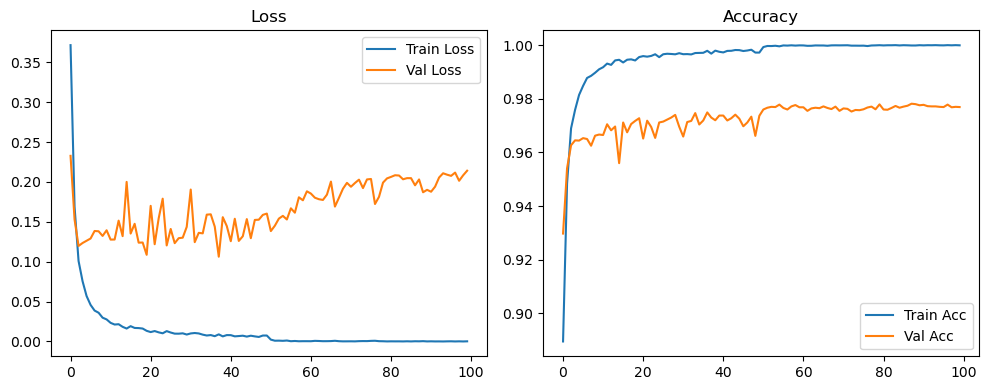

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4645, Acc: 0.8579 | Val Loss: 0.2510, Acc: 0.9256


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2577, Acc: 0.9239 | Val Loss: 0.1814, Acc: 0.9431


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1899, Acc: 0.9425 | Val Loss: 0.1664, Acc: 0.9506


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9539 | Val Loss: 0.1331, Acc: 0.9607


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9602 | Val Loss: 0.1236, Acc: 0.9633


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9660 | Val Loss: 0.1251, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9708 | Val Loss: 0.1046, Acc: 0.9701


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.1088, Acc: 0.9679


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9760 | Val Loss: 0.1121, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9767 | Val Loss: 0.1047, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 0.1042, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9812 | Val Loss: 0.1108, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9823 | Val Loss: 0.1043, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9840 | Val Loss: 0.1055, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.1093, Acc: 0.9714


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 0.0966, Acc: 0.9747


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.1157, Acc: 0.9726


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.1078, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0960, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1011, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.0990, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1107, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.1060, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.1027, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9897 | Val Loss: 0.1149, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.1131, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1045, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1151, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1004, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0924, Acc: 0.9767


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.1019, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.0995, Acc: 0.9775


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.1144, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1062, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0998, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1157, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1093, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1095, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1185, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1277, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1045, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1108, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1149, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1133, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.1205, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1156, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1010, Acc: 0.9768


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1110, Acc: 0.9774


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1041, Acc: 0.9786


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1080, Acc: 0.9790


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1080, Acc: 0.9783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1211, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1151, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1135, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1078, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1187, Acc: 0.9796


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1118, Acc: 0.9788


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1098, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1151, Acc: 0.9784


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1148, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1111, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1201, Acc: 0.9791


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1134, Acc: 0.9788


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1182, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1049, Acc: 0.9791


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1144, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1227, Acc: 0.9790


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1310, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1225, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1272, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1188, Acc: 0.9792


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1213, Acc: 0.9805


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1165, Acc: 0.9796


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1243, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1171, Acc: 0.9793


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1248, Acc: 0.9794


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1220, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1294, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1255, Acc: 0.9786


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1299, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1302, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1274, Acc: 0.9786


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1272, Acc: 0.9794


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1240, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1307, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1303, Acc: 0.9787


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1264, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1231, Acc: 0.9790


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1259, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1305, Acc: 0.9785


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1313, Acc: 0.9797


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1242, Acc: 0.9786


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1347, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1292, Acc: 0.9794


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1320, Acc: 0.9795


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1327, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1352, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1409, Acc: 0.9788


Final Test Loss: 0.1364 Accuracy: 0.9812


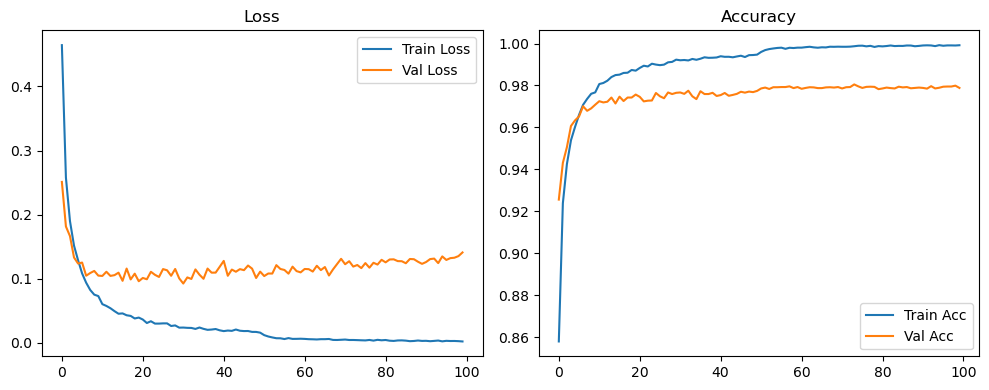

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6848, Acc: 0.7821 | Val Loss: 0.3256, Acc: 0.9016


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4065, Acc: 0.8801 | Val Loss: 0.2343, Acc: 0.9307


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3150, Acc: 0.9079 | Val Loss: 0.2033, Acc: 0.9403


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2625, Acc: 0.9242 | Val Loss: 0.1685, Acc: 0.9500


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2342, Acc: 0.9306 | Val Loss: 0.1508, Acc: 0.9556


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9381 | Val Loss: 0.1369, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1923, Acc: 0.9418 | Val Loss: 0.1304, Acc: 0.9613


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9464 | Val Loss: 0.1238, Acc: 0.9629


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9491 | Val Loss: 0.1200, Acc: 0.9649


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9523 | Val Loss: 0.1219, Acc: 0.9637


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1531, Acc: 0.9540 | Val Loss: 0.1129, Acc: 0.9670


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1412, Acc: 0.9567 | Val Loss: 0.1074, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9575 | Val Loss: 0.1041, Acc: 0.9699


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9597 | Val Loss: 0.1040, Acc: 0.9688


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9602 | Val Loss: 0.1005, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9624 | Val Loss: 0.1051, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9636 | Val Loss: 0.0997, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9653 | Val Loss: 0.1007, Acc: 0.9717


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1129, Acc: 0.9662 | Val Loss: 0.1030, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.0963, Acc: 0.9724


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.0945, Acc: 0.9720


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0974, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9693 | Val Loss: 0.0927, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0973, Acc: 0.9701 | Val Loss: 0.1030, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9692 | Val Loss: 0.0961, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9705 | Val Loss: 0.0988, Acc: 0.9718


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9720 | Val Loss: 0.0945, Acc: 0.9735


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9719 | Val Loss: 0.0935, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0894, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0880, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9727 | Val Loss: 0.0849, Acc: 0.9740


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9736 | Val Loss: 0.0878, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9744 | Val Loss: 0.0882, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9748 | Val Loss: 0.0923, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9755 | Val Loss: 0.0912, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9754 | Val Loss: 0.0952, Acc: 0.9743


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9762 | Val Loss: 0.0901, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0911, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9767 | Val Loss: 0.0905, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9760 | Val Loss: 0.0869, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.0952, Acc: 0.9757


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9777 | Val Loss: 0.0915, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9789 | Val Loss: 0.0928, Acc: 0.9756


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9781 | Val Loss: 0.0952, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9785 | Val Loss: 0.0936, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9774 | Val Loss: 0.1014, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9778 | Val Loss: 0.0856, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9791 | Val Loss: 0.0947, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9789 | Val Loss: 0.0873, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9821 | Val Loss: 0.0860, Acc: 0.9766


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9830 | Val Loss: 0.0853, Acc: 0.9768


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9840 | Val Loss: 0.0893, Acc: 0.9763


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9845 | Val Loss: 0.0873, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.0884, Acc: 0.9771


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0895, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9865 | Val Loss: 0.0904, Acc: 0.9776


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 0.0893, Acc: 0.9771


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9863 | Val Loss: 0.0896, Acc: 0.9772


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0915, Acc: 0.9771


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0931, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9863 | Val Loss: 0.0911, Acc: 0.9776


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0916, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9871 | Val Loss: 0.0917, Acc: 0.9767


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.0917, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9870 | Val Loss: 0.0916, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9885 | Val Loss: 0.0954, Acc: 0.9772


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0923, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0915, Acc: 0.9776


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.0906, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.0930, Acc: 0.9760


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.0926, Acc: 0.9767


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9883 | Val Loss: 0.0897, Acc: 0.9779


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 0.0872, Acc: 0.9762


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.0914, Acc: 0.9770


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.0913, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.0965, Acc: 0.9766


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0925, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9886 | Val Loss: 0.0932, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.0933, Acc: 0.9767


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.0944, Acc: 0.9767


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.0942, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0951, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.0974, Acc: 0.9770


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9889 | Val Loss: 0.0936, Acc: 0.9762


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 0.0952, Acc: 0.9772


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0929, Acc: 0.9770


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9895 | Val Loss: 0.0922, Acc: 0.9776


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0958, Acc: 0.9768


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0957, Acc: 0.9776


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.0914, Acc: 0.9776


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0921, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9898 | Val Loss: 0.0916, Acc: 0.9773


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9891 | Val Loss: 0.0961, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9905 | Val Loss: 0.0974, Acc: 0.9769


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0959, Acc: 0.9763


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9904 | Val Loss: 0.0941, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0954, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.0930, Acc: 0.9775


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0920, Acc: 0.9775


Final Test Loss: 0.0865 Accuracy: 0.9800


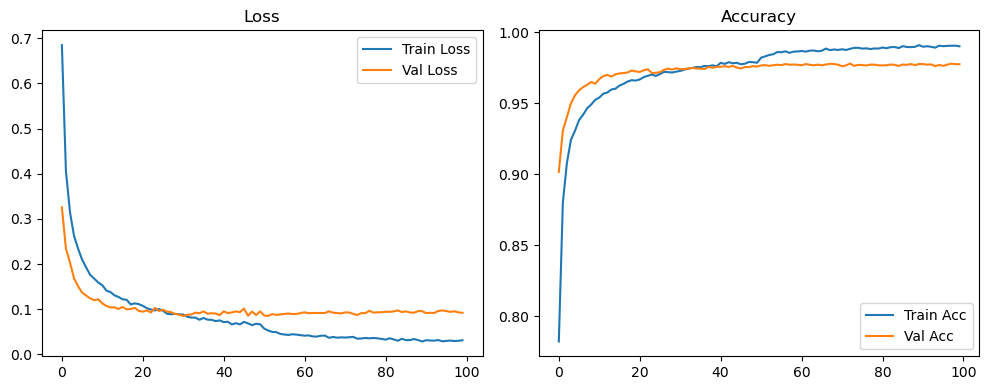

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3792, Acc: 0.8916 | Val Loss: 0.2315, Acc: 0.9284


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1637, Acc: 0.9498 | Val Loss: 0.1478, Acc: 0.9517


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0925, Acc: 0.9706 | Val Loss: 0.1157, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9791 | Val Loss: 0.1179, Acc: 0.9606


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9835 | Val Loss: 0.1131, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9867 | Val Loss: 0.1270, Acc: 0.9645


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9892 | Val Loss: 0.1494, Acc: 0.9617


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.1238, Acc: 0.9677


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1216, Acc: 0.9712


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.1246, Acc: 0.9702


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1142, Acc: 0.9717


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1157, Acc: 0.9731


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.1242, Acc: 0.9720


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1286, Acc: 0.9722


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.1611, Acc: 0.9632


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1297, Acc: 0.9720


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9944 | Val Loss: 0.1487, Acc: 0.9683


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1307, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1400, Acc: 0.9703


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1237, Acc: 0.9748


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1327, Acc: 0.9743


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1910, Acc: 0.9627


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1267, Acc: 0.9742


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.1501, Acc: 0.9737


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9723


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1468, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1336, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1389, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1343, Acc: 0.9756


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1299, Acc: 0.9723


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1573, Acc: 0.9704


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1426, Acc: 0.9729


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1647, Acc: 0.9721


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1530, Acc: 0.9726


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1318, Acc: 0.9728


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1452, Acc: 0.9734


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1422, Acc: 0.9739


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1509, Acc: 0.9726


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1377, Acc: 0.9764


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1414, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1535, Acc: 0.9723


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1308, Acc: 0.9737


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1543, Acc: 0.9748


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1506, Acc: 0.9744


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1388, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1442, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1414, Acc: 0.9720


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1244, Acc: 0.9747


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1537, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1236, Acc: 0.9762


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1351, Acc: 0.9755


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1386, Acc: 0.9750


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1484, Acc: 0.9743


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1369, Acc: 0.9776


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1321, Acc: 0.9741


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1384, Acc: 0.9741


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1524, Acc: 0.9747


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1454, Acc: 0.9749


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1400, Acc: 0.9745


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1569, Acc: 0.9722


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1336, Acc: 0.9763


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1559, Acc: 0.9732


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1285, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1574, Acc: 0.9745


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1564, Acc: 0.9752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1320, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.1537, Acc: 0.9752


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1497, Acc: 0.9747


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1594, Acc: 0.9737


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1473, Acc: 0.9757


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1648, Acc: 0.9742


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1578, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1471, Acc: 0.9747


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1492, Acc: 0.9762


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1453, Acc: 0.9761


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1694, Acc: 0.9724


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1595, Acc: 0.9751


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1844, Acc: 0.9728


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1625, Acc: 0.9765


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1407, Acc: 0.9768


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1494, Acc: 0.9748


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1416, Acc: 0.9755


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1356, Acc: 0.9775


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1289, Acc: 0.9758


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1924, Acc: 0.9709


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1583, Acc: 0.9728


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1276, Acc: 0.9737


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1536, Acc: 0.9758


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1381, Acc: 0.9757


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1303, Acc: 0.9761


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1481, Acc: 0.9745


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1406, Acc: 0.9768


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1533, Acc: 0.9733


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1527, Acc: 0.9756


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1528, Acc: 0.9757


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1295, Acc: 0.9732


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1517, Acc: 0.9758


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1306, Acc: 0.9762


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1481, Acc: 0.9766


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1221, Acc: 0.9762


Final Test Loss: 0.1203 Accuracy: 0.9772


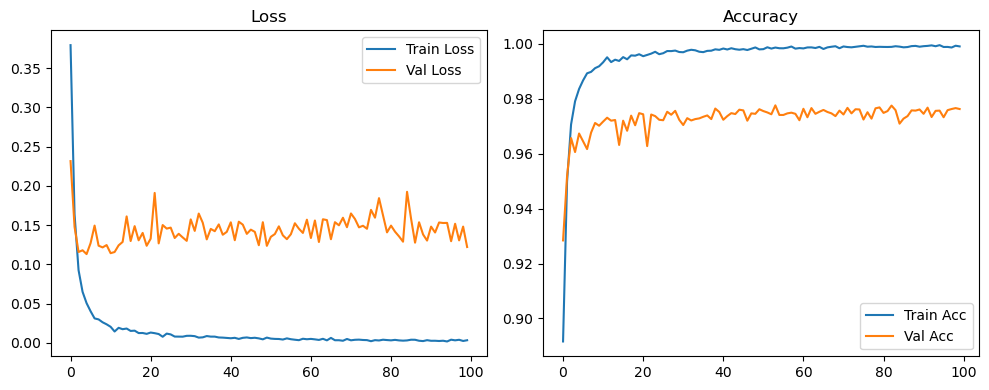

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4901, Acc: 0.8550 | Val Loss: 0.2829, Acc: 0.9162


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2897, Acc: 0.9127 | Val Loss: 0.2118, Acc: 0.9357


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2193, Acc: 0.9338 | Val Loss: 0.1838, Acc: 0.9452


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1795, Acc: 0.9455 | Val Loss: 0.1531, Acc: 0.9539


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1547, Acc: 0.9527 | Val Loss: 0.1329, Acc: 0.9601


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1335, Acc: 0.9581 | Val Loss: 0.1273, Acc: 0.9637


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1174, Acc: 0.9644 | Val Loss: 0.1204, Acc: 0.9657


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0997, Acc: 0.9686 | Val Loss: 0.1264, Acc: 0.9631


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9700 | Val Loss: 0.1137, Acc: 0.9665


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9724 | Val Loss: 0.1173, Acc: 0.9668


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0765, Acc: 0.9759 | Val Loss: 0.1131, Acc: 0.9689


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9774 | Val Loss: 0.1226, Acc: 0.9675


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9785 | Val Loss: 0.1095, Acc: 0.9715


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9801 | Val Loss: 0.1106, Acc: 0.9710


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9819 | Val Loss: 0.1244, Acc: 0.9689


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9825 | Val Loss: 0.1135, Acc: 0.9721


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1077, Acc: 0.9728


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9837 | Val Loss: 0.1073, Acc: 0.9718


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9851 | Val Loss: 0.1009, Acc: 0.9740


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9846 | Val Loss: 0.1061, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9858 | Val Loss: 0.1115, Acc: 0.9722


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9870 | Val Loss: 0.1162, Acc: 0.9727


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9866 | Val Loss: 0.1121, Acc: 0.9730


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1180, Acc: 0.9712


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9886 | Val Loss: 0.1163, Acc: 0.9729


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9867 | Val Loss: 0.1090, Acc: 0.9734


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.1046, Acc: 0.9729


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1012, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.1090, Acc: 0.9741


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1088, Acc: 0.9743


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.1120, Acc: 0.9744


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.1113, Acc: 0.9749


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9896 | Val Loss: 0.1106, Acc: 0.9749


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1095, Acc: 0.9736


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.1196, Acc: 0.9734


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.1195, Acc: 0.9744


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1225, Acc: 0.9743


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1238, Acc: 0.9755


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1254, Acc: 0.9746


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9912 | Val Loss: 0.1100, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9758


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.1193, Acc: 0.9748


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1291, Acc: 0.9727


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.1216, Acc: 0.9752


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1178, Acc: 0.9729


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9923 | Val Loss: 0.1159, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9926 | Val Loss: 0.1161, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1107, Acc: 0.9772


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9928 | Val Loss: 0.1173, Acc: 0.9762


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1166, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.1159, Acc: 0.9759


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.1231, Acc: 0.9758


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9932 | Val Loss: 0.1216, Acc: 0.9756


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1341, Acc: 0.9739


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.1133, Acc: 0.9741


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.1257, Acc: 0.9752


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1253, Acc: 0.9750


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1301, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1273, Acc: 0.9755


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1208, Acc: 0.9757


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1238, Acc: 0.9755


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9944 | Val Loss: 0.1196, Acc: 0.9762


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.1226, Acc: 0.9762


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1163, Acc: 0.9763


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1200, Acc: 0.9750


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.1141, Acc: 0.9749


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1211, Acc: 0.9749


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.1266, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1118, Acc: 0.9771


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.1287, Acc: 0.9756


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1176, Acc: 0.9771


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9952 | Val Loss: 0.1321, Acc: 0.9751


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1225, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1322, Acc: 0.9733


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.1215, Acc: 0.9761


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1239, Acc: 0.9754


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.1167, Acc: 0.9777


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1309, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1194, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1304, Acc: 0.9772


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1146, Acc: 0.9765


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.1238, Acc: 0.9763


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1202, Acc: 0.9752


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1167, Acc: 0.9783


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1191, Acc: 0.9753


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1125, Acc: 0.9772


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1192, Acc: 0.9785


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1126, Acc: 0.9782


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1145, Acc: 0.9777


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1153, Acc: 0.9758


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1354, Acc: 0.9759


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1277, Acc: 0.9762


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1332, Acc: 0.9765


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1214, Acc: 0.9762


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1258, Acc: 0.9752


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0999, Acc: 0.9761


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1284, Acc: 0.9758


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1151, Acc: 0.9770


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1151, Acc: 0.9782


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1250, Acc: 0.9772


Final Test Loss: 0.1271 Accuracy: 0.9779


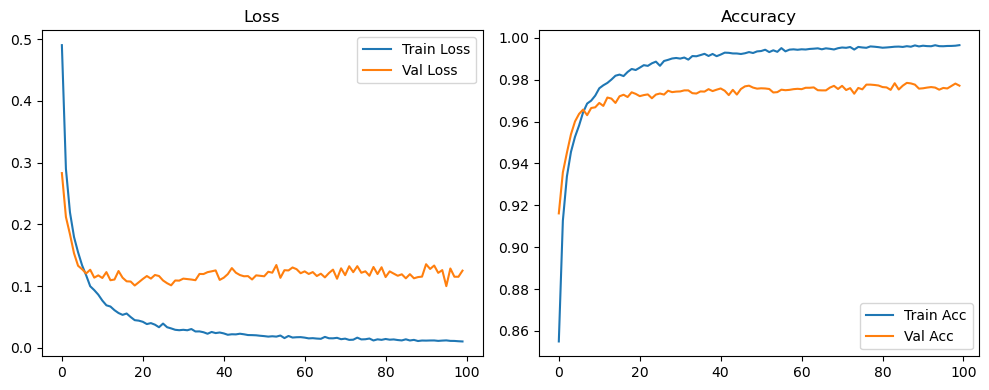

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7530, Acc: 0.7593 | Val Loss: 0.3209, Acc: 0.9045


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4591, Acc: 0.8619 | Val Loss: 0.2742, Acc: 0.9199


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3713, Acc: 0.8897 | Val Loss: 0.2416, Acc: 0.9297


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3142, Acc: 0.9064 | Val Loss: 0.1952, Acc: 0.9401


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2784, Acc: 0.9182 | Val Loss: 0.1747, Acc: 0.9480


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2489, Acc: 0.9250 | Val Loss: 0.1558, Acc: 0.9543


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2267, Acc: 0.9322 | Val Loss: 0.1464, Acc: 0.9572


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2064, Acc: 0.9391 | Val Loss: 0.1428, Acc: 0.9585


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1963, Acc: 0.9406 | Val Loss: 0.1290, Acc: 0.9613


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1861, Acc: 0.9444 | Val Loss: 0.1294, Acc: 0.9618


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1737, Acc: 0.9465 | Val Loss: 0.1260, Acc: 0.9631


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1668, Acc: 0.9500 | Val Loss: 0.1151, Acc: 0.9657


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1591, Acc: 0.9505 | Val Loss: 0.1143, Acc: 0.9666


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1508, Acc: 0.9535 | Val Loss: 0.1158, Acc: 0.9673


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1422, Acc: 0.9556 | Val Loss: 0.1109, Acc: 0.9681


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1391, Acc: 0.9567 | Val Loss: 0.1127, Acc: 0.9688


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1333, Acc: 0.9595 | Val Loss: 0.1110, Acc: 0.9688


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1278, Acc: 0.9601 | Val Loss: 0.1079, Acc: 0.9711


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1297, Acc: 0.9612 | Val Loss: 0.1066, Acc: 0.9696


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9627 | Val Loss: 0.1011, Acc: 0.9698


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1168, Acc: 0.9639 | Val Loss: 0.1014, Acc: 0.9718


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1148, Acc: 0.9649 | Val Loss: 0.0991, Acc: 0.9715


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1140, Acc: 0.9649 | Val Loss: 0.1011, Acc: 0.9718


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1106, Acc: 0.9652 | Val Loss: 0.1029, Acc: 0.9710


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.1023, Acc: 0.9717


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1069, Acc: 0.9668 | Val Loss: 0.1003, Acc: 0.9718


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1014, Acc: 0.9686 | Val Loss: 0.1022, Acc: 0.9724


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0989, Acc: 0.9692 | Val Loss: 0.0986, Acc: 0.9732


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0985, Acc: 0.9685 | Val Loss: 0.1043, Acc: 0.9720


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9702 | Val Loss: 0.0978, Acc: 0.9733


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9716 | Val Loss: 0.1003, Acc: 0.9729


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0898, Acc: 0.9710 | Val Loss: 0.0979, Acc: 0.9735


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9716 | Val Loss: 0.1013, Acc: 0.9728


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0854, Acc: 0.9725 | Val Loss: 0.0985, Acc: 0.9729


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9731 | Val Loss: 0.0995, Acc: 0.9741


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0865, Acc: 0.9733 | Val Loss: 0.0924, Acc: 0.9739


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9732 | Val Loss: 0.0970, Acc: 0.9750


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0827, Acc: 0.9737 | Val Loss: 0.0972, Acc: 0.9741


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9747 | Val Loss: 0.0989, Acc: 0.9748


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.0969, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9749 | Val Loss: 0.0946, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9759 | Val Loss: 0.0985, Acc: 0.9744


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9755 | Val Loss: 0.0974, Acc: 0.9751


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9762 | Val Loss: 0.0988, Acc: 0.9755


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0734, Acc: 0.9762 | Val Loss: 0.1013, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9771 | Val Loss: 0.0980, Acc: 0.9755


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9776 | Val Loss: 0.0913, Acc: 0.9761


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9777 | Val Loss: 0.0959, Acc: 0.9748


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9775 | Val Loss: 0.0958, Acc: 0.9760


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9775 | Val Loss: 0.0928, Acc: 0.9761


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9772 | Val Loss: 0.1016, Acc: 0.9757


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9783 | Val Loss: 0.0925, Acc: 0.9759


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0660, Acc: 0.9792 | Val Loss: 0.0981, Acc: 0.9742


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9795 | Val Loss: 0.0963, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9785 | Val Loss: 0.0945, Acc: 0.9752


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9793 | Val Loss: 0.0915, Acc: 0.9749


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9790 | Val Loss: 0.0933, Acc: 0.9745


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9799 | Val Loss: 0.0972, Acc: 0.9748


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9793 | Val Loss: 0.0989, Acc: 0.9759


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0613, Acc: 0.9803 | Val Loss: 0.0946, Acc: 0.9752


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9800 | Val Loss: 0.0984, Acc: 0.9755


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9804 | Val Loss: 0.0995, Acc: 0.9760


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9812 | Val Loss: 0.0960, Acc: 0.9756


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9811 | Val Loss: 0.0961, Acc: 0.9759


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9806 | Val Loss: 0.0997, Acc: 0.9750


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0928, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9826 | Val Loss: 0.0967, Acc: 0.9764


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9810 | Val Loss: 0.0926, Acc: 0.9760


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9819 | Val Loss: 0.0945, Acc: 0.9765


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9816 | Val Loss: 0.1015, Acc: 0.9753


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9827 | Val Loss: 0.1009, Acc: 0.9756


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.0961, Acc: 0.9759


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9830 | Val Loss: 0.0962, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9822 | Val Loss: 0.0994, Acc: 0.9760


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9829 | Val Loss: 0.1036, Acc: 0.9757


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9833 | Val Loss: 0.0965, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9827 | Val Loss: 0.0972, Acc: 0.9756


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9829 | Val Loss: 0.1027, Acc: 0.9749


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9830 | Val Loss: 0.0989, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.0989, Acc: 0.9756


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.1022, Acc: 0.9744


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 0.0979, Acc: 0.9757


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9834 | Val Loss: 0.1028, Acc: 0.9762


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9841 | Val Loss: 0.1059, Acc: 0.9752


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9832 | Val Loss: 0.1057, Acc: 0.9746


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9846 | Val Loss: 0.1017, Acc: 0.9751


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9844 | Val Loss: 0.1036, Acc: 0.9767


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9838 | Val Loss: 0.1018, Acc: 0.9758


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9832 | Val Loss: 0.0954, Acc: 0.9759


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9849 | Val Loss: 0.0973, Acc: 0.9760


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.0947, Acc: 0.9762


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9848 | Val Loss: 0.0922, Acc: 0.9763


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9847 | Val Loss: 0.0980, Acc: 0.9750


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0913, Acc: 0.9762


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9852 | Val Loss: 0.1007, Acc: 0.9765


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9848 | Val Loss: 0.1050, Acc: 0.9762


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9841 | Val Loss: 0.0969, Acc: 0.9761


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 0.0998, Acc: 0.9768


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.1037, Acc: 0.9761


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.0985, Acc: 0.9762


Final Test Loss: 0.0875 Accuracy: 0.9788


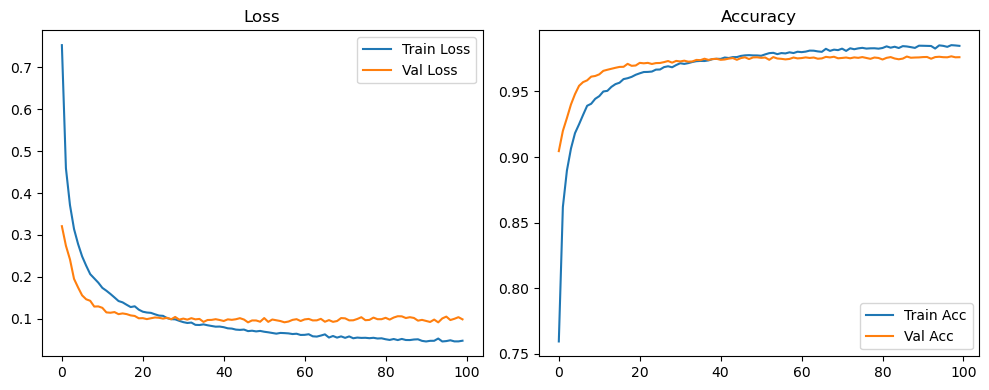

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3792, Acc: 0.8916 | Val Loss: 0.2315, Acc: 0.9284


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1637, Acc: 0.9498 | Val Loss: 0.1478, Acc: 0.9517


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0925, Acc: 0.9706 | Val Loss: 0.1157, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9791 | Val Loss: 0.1179, Acc: 0.9606


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9835 | Val Loss: 0.1131, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9867 | Val Loss: 0.1270, Acc: 0.9645


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9892 | Val Loss: 0.1494, Acc: 0.9617


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.1238, Acc: 0.9677


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1216, Acc: 0.9712


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.1246, Acc: 0.9702


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1142, Acc: 0.9717


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1157, Acc: 0.9731


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.1242, Acc: 0.9720


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1286, Acc: 0.9722


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.1611, Acc: 0.9632


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1297, Acc: 0.9720


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9944 | Val Loss: 0.1487, Acc: 0.9683


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1307, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1400, Acc: 0.9703


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1237, Acc: 0.9748


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1327, Acc: 0.9743


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1910, Acc: 0.9627


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1267, Acc: 0.9742


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.1501, Acc: 0.9737


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9723


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1468, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1336, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1389, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1343, Acc: 0.9756


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1299, Acc: 0.9723


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1573, Acc: 0.9704


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1426, Acc: 0.9729


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1647, Acc: 0.9721


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1530, Acc: 0.9726


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1318, Acc: 0.9728


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1452, Acc: 0.9734


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1422, Acc: 0.9739


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1509, Acc: 0.9726


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1377, Acc: 0.9764


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1414, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1535, Acc: 0.9723


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1308, Acc: 0.9737


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1543, Acc: 0.9748


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1506, Acc: 0.9744


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1388, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1442, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1414, Acc: 0.9720


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1244, Acc: 0.9747


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1537, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1236, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1213, Acc: 0.9784


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1260, Acc: 0.9788


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1376, Acc: 0.9784


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1391, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1353, Acc: 0.9786


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1376, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1532, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1454, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1452, Acc: 0.9788


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1420, Acc: 0.9794


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1466, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1393, Acc: 0.9774


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1380, Acc: 0.9793


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1342, Acc: 0.9792


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1422, Acc: 0.9797


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1524, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1638, Acc: 0.9762


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1517, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1455, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1394, Acc: 0.9785


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1424, Acc: 0.9776


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1394, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1500, Acc: 0.9784


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1511, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1565, Acc: 0.9785


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1703, Acc: 0.9755


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1578, Acc: 0.9771


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1703, Acc: 0.9764


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1630, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1715, Acc: 0.9771


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1601, Acc: 0.9791


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1603, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1595, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1620, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1729, Acc: 0.9781


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1676, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1739, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1755, Acc: 0.9785


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1883, Acc: 0.9768


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1769, Acc: 0.9785


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1759, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1764, Acc: 0.9783


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1729, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1769, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1747, Acc: 0.9785


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1761, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1703, Acc: 0.9790


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1702, Acc: 0.9791


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1726, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1734, Acc: 0.9788


Final Test Loss: 0.1692 Accuracy: 0.9809


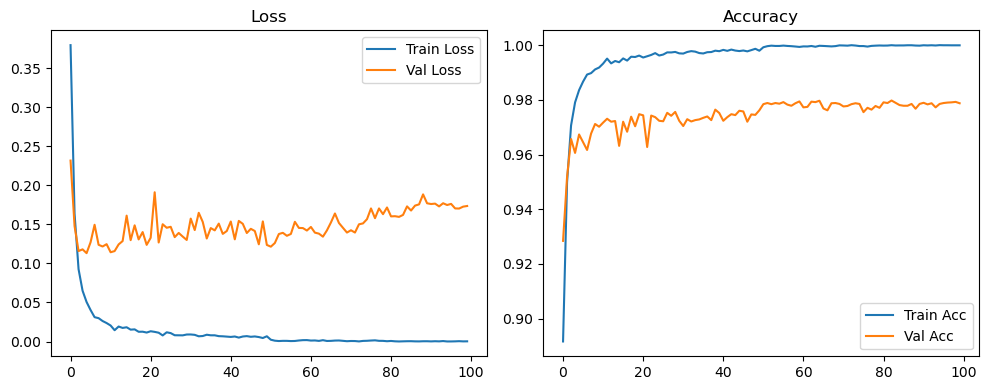

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4901, Acc: 0.8550 | Val Loss: 0.2829, Acc: 0.9162


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2897, Acc: 0.9127 | Val Loss: 0.2118, Acc: 0.9357


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2193, Acc: 0.9338 | Val Loss: 0.1838, Acc: 0.9452


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1795, Acc: 0.9455 | Val Loss: 0.1531, Acc: 0.9539


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1547, Acc: 0.9527 | Val Loss: 0.1329, Acc: 0.9601


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1335, Acc: 0.9581 | Val Loss: 0.1273, Acc: 0.9637


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1174, Acc: 0.9644 | Val Loss: 0.1204, Acc: 0.9657


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0997, Acc: 0.9686 | Val Loss: 0.1264, Acc: 0.9631


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9700 | Val Loss: 0.1137, Acc: 0.9665


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9724 | Val Loss: 0.1173, Acc: 0.9668


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0765, Acc: 0.9759 | Val Loss: 0.1131, Acc: 0.9689


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9774 | Val Loss: 0.1226, Acc: 0.9675


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9785 | Val Loss: 0.1095, Acc: 0.9715


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9801 | Val Loss: 0.1106, Acc: 0.9710


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9819 | Val Loss: 0.1244, Acc: 0.9689


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9825 | Val Loss: 0.1135, Acc: 0.9721


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1077, Acc: 0.9728


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9837 | Val Loss: 0.1073, Acc: 0.9718


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9851 | Val Loss: 0.1009, Acc: 0.9740


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9846 | Val Loss: 0.1061, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9858 | Val Loss: 0.1115, Acc: 0.9722


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9870 | Val Loss: 0.1162, Acc: 0.9727


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9866 | Val Loss: 0.1121, Acc: 0.9730


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1180, Acc: 0.9712


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9886 | Val Loss: 0.1163, Acc: 0.9729


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9867 | Val Loss: 0.1090, Acc: 0.9734


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.1046, Acc: 0.9729


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1012, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.1090, Acc: 0.9741


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1088, Acc: 0.9743


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.1120, Acc: 0.9744


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.1113, Acc: 0.9749


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9896 | Val Loss: 0.1106, Acc: 0.9749


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1095, Acc: 0.9736


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.1196, Acc: 0.9734


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.1195, Acc: 0.9744


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1225, Acc: 0.9743


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1238, Acc: 0.9755


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1254, Acc: 0.9746


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9912 | Val Loss: 0.1100, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9758


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.1193, Acc: 0.9748


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1291, Acc: 0.9727


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.1216, Acc: 0.9752


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1178, Acc: 0.9729


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9923 | Val Loss: 0.1159, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9926 | Val Loss: 0.1161, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1107, Acc: 0.9772


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9928 | Val Loss: 0.1173, Acc: 0.9762


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1166, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1183, Acc: 0.9775


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1209, Acc: 0.9774


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1234, Acc: 0.9773


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1292, Acc: 0.9767


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1220, Acc: 0.9782


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1221, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1197, Acc: 0.9777


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1247, Acc: 0.9779


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1210, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1232, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1324, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1312, Acc: 0.9782


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1316, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1308, Acc: 0.9767


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1330, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1286, Acc: 0.9780


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1358, Acc: 0.9771


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1366, Acc: 0.9777


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1291, Acc: 0.9772


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1322, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1315, Acc: 0.9789


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1265, Acc: 0.9771


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1240, Acc: 0.9772


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.1331, Acc: 0.9773


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1274, Acc: 0.9791


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1342, Acc: 0.9769


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1294, Acc: 0.9778


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1282, Acc: 0.9774


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.1322, Acc: 0.9776


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1307, Acc: 0.9780


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1262, Acc: 0.9786


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1362, Acc: 0.9778


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1360, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1328, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1391, Acc: 0.9781


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1361, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1393, Acc: 0.9780


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1359, Acc: 0.9783


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1365, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1313, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1363, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1326, Acc: 0.9771


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1283, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1390, Acc: 0.9773


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1397, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1343, Acc: 0.9776


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1360, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1305, Acc: 0.9787


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1372, Acc: 0.9782


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1349, Acc: 0.9780


Final Test Loss: 0.1324 Accuracy: 0.9796


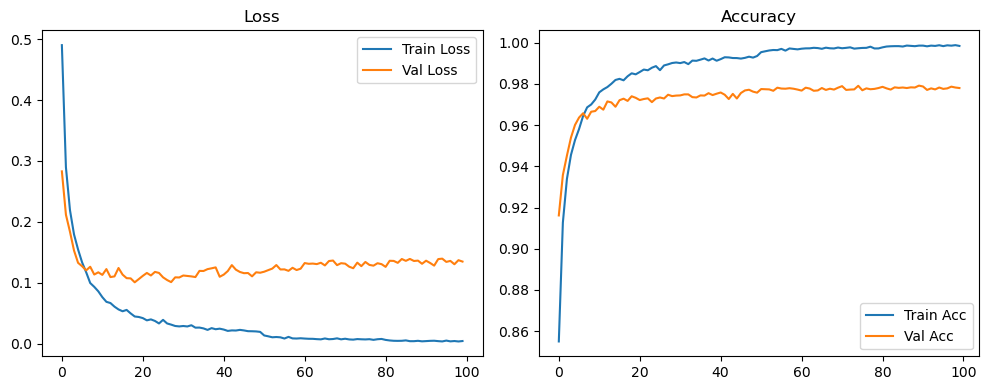

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7530, Acc: 0.7593 | Val Loss: 0.3209, Acc: 0.9045


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4591, Acc: 0.8619 | Val Loss: 0.2742, Acc: 0.9199


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3713, Acc: 0.8897 | Val Loss: 0.2416, Acc: 0.9297


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3142, Acc: 0.9064 | Val Loss: 0.1952, Acc: 0.9401


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2784, Acc: 0.9182 | Val Loss: 0.1747, Acc: 0.9480


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2489, Acc: 0.9250 | Val Loss: 0.1558, Acc: 0.9543


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2267, Acc: 0.9322 | Val Loss: 0.1464, Acc: 0.9572


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2064, Acc: 0.9391 | Val Loss: 0.1428, Acc: 0.9585


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1963, Acc: 0.9406 | Val Loss: 0.1290, Acc: 0.9613


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1861, Acc: 0.9444 | Val Loss: 0.1294, Acc: 0.9618


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1737, Acc: 0.9465 | Val Loss: 0.1260, Acc: 0.9631


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1668, Acc: 0.9500 | Val Loss: 0.1151, Acc: 0.9657


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1591, Acc: 0.9505 | Val Loss: 0.1143, Acc: 0.9666


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1508, Acc: 0.9535 | Val Loss: 0.1158, Acc: 0.9673


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1422, Acc: 0.9556 | Val Loss: 0.1109, Acc: 0.9681


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1391, Acc: 0.9567 | Val Loss: 0.1127, Acc: 0.9688


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1333, Acc: 0.9595 | Val Loss: 0.1110, Acc: 0.9688


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1278, Acc: 0.9601 | Val Loss: 0.1079, Acc: 0.9711


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1297, Acc: 0.9612 | Val Loss: 0.1066, Acc: 0.9696


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9627 | Val Loss: 0.1011, Acc: 0.9698


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1168, Acc: 0.9639 | Val Loss: 0.1014, Acc: 0.9718


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1148, Acc: 0.9649 | Val Loss: 0.0991, Acc: 0.9715


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1140, Acc: 0.9649 | Val Loss: 0.1011, Acc: 0.9718


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1106, Acc: 0.9652 | Val Loss: 0.1029, Acc: 0.9710


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.1023, Acc: 0.9717


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1069, Acc: 0.9668 | Val Loss: 0.1003, Acc: 0.9718


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1014, Acc: 0.9686 | Val Loss: 0.1022, Acc: 0.9724


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0989, Acc: 0.9692 | Val Loss: 0.0986, Acc: 0.9732


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0985, Acc: 0.9685 | Val Loss: 0.1043, Acc: 0.9720


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9702 | Val Loss: 0.0978, Acc: 0.9733


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9716 | Val Loss: 0.1003, Acc: 0.9729


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0898, Acc: 0.9710 | Val Loss: 0.0979, Acc: 0.9735


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9716 | Val Loss: 0.1013, Acc: 0.9728


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0854, Acc: 0.9725 | Val Loss: 0.0985, Acc: 0.9729


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9731 | Val Loss: 0.0995, Acc: 0.9741


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0865, Acc: 0.9733 | Val Loss: 0.0924, Acc: 0.9739


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9732 | Val Loss: 0.0970, Acc: 0.9750


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0827, Acc: 0.9737 | Val Loss: 0.0972, Acc: 0.9741


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9747 | Val Loss: 0.0989, Acc: 0.9748


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.0969, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9749 | Val Loss: 0.0946, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9759 | Val Loss: 0.0985, Acc: 0.9744


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9755 | Val Loss: 0.0974, Acc: 0.9751


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9762 | Val Loss: 0.0988, Acc: 0.9755


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0734, Acc: 0.9762 | Val Loss: 0.1013, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9771 | Val Loss: 0.0980, Acc: 0.9755


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9776 | Val Loss: 0.0913, Acc: 0.9761


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9777 | Val Loss: 0.0959, Acc: 0.9748


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9775 | Val Loss: 0.0958, Acc: 0.9760


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9775 | Val Loss: 0.0928, Acc: 0.9761


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9796 | Val Loss: 0.0958, Acc: 0.9757


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0580, Acc: 0.9810 | Val Loss: 0.0948, Acc: 0.9766


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9826 | Val Loss: 0.0936, Acc: 0.9764


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.0953, Acc: 0.9774


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.0985, Acc: 0.9768


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9827 | Val Loss: 0.0908, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.0969, Acc: 0.9758


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 0.0926, Acc: 0.9764


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9837 | Val Loss: 0.1002, Acc: 0.9753


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9842 | Val Loss: 0.0977, Acc: 0.9762


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.0962, Acc: 0.9759


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9853 | Val Loss: 0.0952, Acc: 0.9759


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9856 | Val Loss: 0.0999, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9856 | Val Loss: 0.1002, Acc: 0.9757


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 0.1020, Acc: 0.9760


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9846 | Val Loss: 0.0991, Acc: 0.9760


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.1002, Acc: 0.9770


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0942, Acc: 0.9761


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9854 | Val Loss: 0.1000, Acc: 0.9774


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9853 | Val Loss: 0.1016, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.1043, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9856 | Val Loss: 0.1013, Acc: 0.9761


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9867 | Val Loss: 0.0959, Acc: 0.9770


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9854 | Val Loss: 0.1038, Acc: 0.9763


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.0991, Acc: 0.9765


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 0.0998, Acc: 0.9770


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9858 | Val Loss: 0.1003, Acc: 0.9764


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.1051, Acc: 0.9760


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.1042, Acc: 0.9762


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.1002, Acc: 0.9761


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.1041, Acc: 0.9767


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.1053, Acc: 0.9773


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.1037, Acc: 0.9765


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1040, Acc: 0.9762


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.1056, Acc: 0.9771


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.1070, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 0.1069, Acc: 0.9763


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.1053, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9883 | Val Loss: 0.1032, Acc: 0.9772


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.1032, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.1042, Acc: 0.9771


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.1014, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9889 | Val Loss: 0.1053, Acc: 0.9768


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.1009, Acc: 0.9773


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.1050, Acc: 0.9775


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9890 | Val Loss: 0.1055, Acc: 0.9765


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 0.1053, Acc: 0.9770


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.1045, Acc: 0.9765


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1042, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.1053, Acc: 0.9768


Final Test Loss: 0.0948 Accuracy: 0.9804


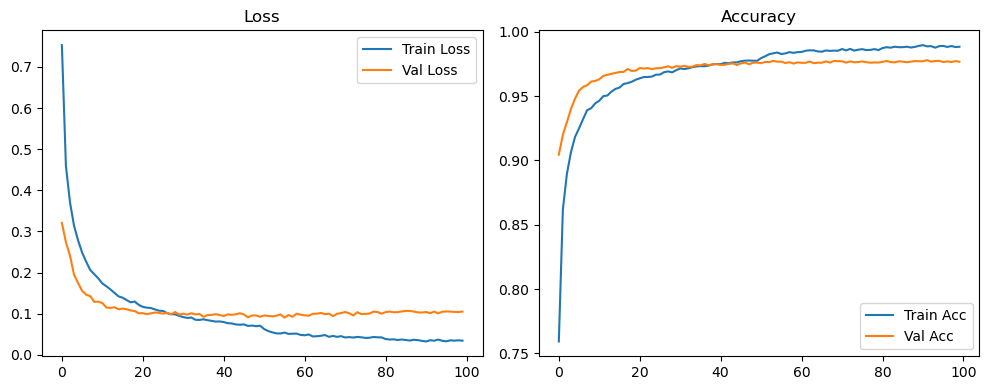

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4281, Acc: 0.8899 | Val Loss: 0.2671, Acc: 0.9213


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1646, Acc: 0.9508 | Val Loss: 0.1316, Acc: 0.9587


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0867, Acc: 0.9736 | Val Loss: 0.1075, Acc: 0.9660


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9821 | Val Loss: 0.1079, Acc: 0.9653


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9869 | Val Loss: 0.1068, Acc: 0.9674


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.0983, Acc: 0.9704


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.1125, Acc: 0.9701


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1110, Acc: 0.9692


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1116, Acc: 0.9700


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9939 | Val Loss: 0.1119, Acc: 0.9723


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1187, Acc: 0.9707


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.1222, Acc: 0.9698


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1262, Acc: 0.9718


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1113, Acc: 0.9739


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1193, Acc: 0.9718


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1255, Acc: 0.9710


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1239, Acc: 0.9734


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1165, Acc: 0.9742


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1287, Acc: 0.9707


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1204, Acc: 0.9740


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.1638, Acc: 0.9666


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1309, Acc: 0.9725


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1301, Acc: 0.9728


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1176, Acc: 0.9738


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1261, Acc: 0.9732


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1295, Acc: 0.9740


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1315, Acc: 0.9735


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1429, Acc: 0.9726


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1368, Acc: 0.9718


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1248, Acc: 0.9742


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1341, Acc: 0.9737


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1490, Acc: 0.9718


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1289, Acc: 0.9736


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1408, Acc: 0.9728


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1302, Acc: 0.9768


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1231, Acc: 0.9753


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1223, Acc: 0.9758


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1442, Acc: 0.9734


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1355, Acc: 0.9752


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1378, Acc: 0.9752


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1325, Acc: 0.9747


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1303, Acc: 0.9764


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1333, Acc: 0.9755


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1475, Acc: 0.9741


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1385, Acc: 0.9748


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1302, Acc: 0.9760


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1537, Acc: 0.9751


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1389, Acc: 0.9739


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1376, Acc: 0.9742


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1243, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1418, Acc: 0.9746


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1334, Acc: 0.9772


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1370, Acc: 0.9749


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1423, Acc: 0.9761


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1353, Acc: 0.9752


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1357, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1432, Acc: 0.9762


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1334, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1407, Acc: 0.9752


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1389, Acc: 0.9739


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1641, Acc: 0.9745


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1413, Acc: 0.9761


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1464, Acc: 0.9756


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1448, Acc: 0.9767


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1455, Acc: 0.9767


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1451, Acc: 0.9753


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1495, Acc: 0.9747


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1401, Acc: 0.9760


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1355, Acc: 0.9755


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1499, Acc: 0.9757


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1361, Acc: 0.9765


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1571, Acc: 0.9758


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1566, Acc: 0.9734


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1446, Acc: 0.9766


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.1395, Acc: 0.9758


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1424, Acc: 0.9762


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.1487, Acc: 0.9748


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1517, Acc: 0.9762


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1427, Acc: 0.9760


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1411, Acc: 0.9766


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1392, Acc: 0.9768


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1465, Acc: 0.9761


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1409, Acc: 0.9778


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1579, Acc: 0.9754


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1798, Acc: 0.9728


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1602, Acc: 0.9741


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1517, Acc: 0.9760


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1546, Acc: 0.9738


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1489, Acc: 0.9765


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1554, Acc: 0.9745


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1674, Acc: 0.9752


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1596, Acc: 0.9738


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1645, Acc: 0.9758


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1446, Acc: 0.9759


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1637, Acc: 0.9758


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1703, Acc: 0.9739


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1517, Acc: 0.9745


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1489, Acc: 0.9754


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1358, Acc: 0.9777


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1451, Acc: 0.9774


Final Test Loss: 0.1366 Accuracy: 0.9774


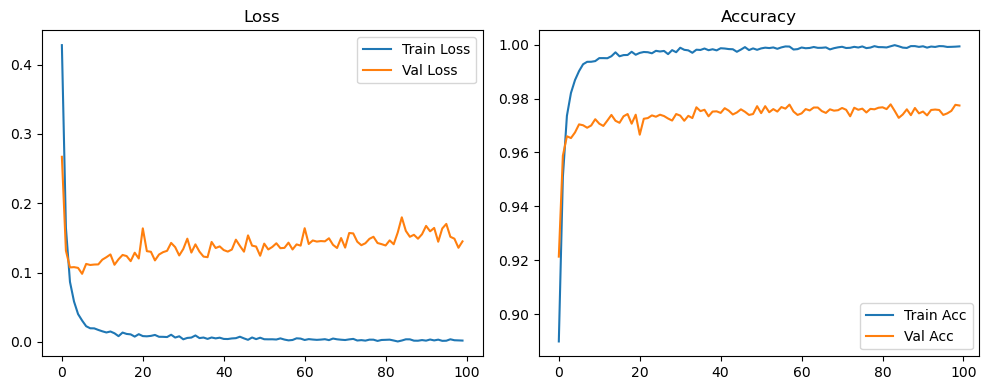

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5654, Acc: 0.8471 | Val Loss: 0.3100, Acc: 0.9080


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3255, Acc: 0.9015 | Val Loss: 0.2295, Acc: 0.9308


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2545, Acc: 0.9224 | Val Loss: 0.1969, Acc: 0.9399


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2136, Acc: 0.9366 | Val Loss: 0.1667, Acc: 0.9491


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1908, Acc: 0.9417 | Val Loss: 0.1554, Acc: 0.9537


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1677, Acc: 0.9478 | Val Loss: 0.1425, Acc: 0.9576


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1482, Acc: 0.9538 | Val Loss: 0.1384, Acc: 0.9603


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1316, Acc: 0.9593 | Val Loss: 0.1385, Acc: 0.9592


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1222, Acc: 0.9614 | Val Loss: 0.1266, Acc: 0.9634


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1199, Acc: 0.9615 | Val Loss: 0.1266, Acc: 0.9631


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1104, Acc: 0.9640 | Val Loss: 0.1323, Acc: 0.9624


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1003, Acc: 0.9669 | Val Loss: 0.1213, Acc: 0.9680


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0925, Acc: 0.9700 | Val Loss: 0.1196, Acc: 0.9675


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0864, Acc: 0.9721 | Val Loss: 0.1195, Acc: 0.9670


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0840, Acc: 0.9728 | Val Loss: 0.1339, Acc: 0.9629


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0760, Acc: 0.9754 | Val Loss: 0.1240, Acc: 0.9659


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0787, Acc: 0.9745 | Val Loss: 0.1185, Acc: 0.9682


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0711, Acc: 0.9767 | Val Loss: 0.1195, Acc: 0.9673


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9773 | Val Loss: 0.1209, Acc: 0.9681


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9790 | Val Loss: 0.1200, Acc: 0.9703


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9795 | Val Loss: 0.1231, Acc: 0.9687


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9794 | Val Loss: 0.1149, Acc: 0.9689


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9810 | Val Loss: 0.1168, Acc: 0.9700


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9825 | Val Loss: 0.1192, Acc: 0.9695


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9820 | Val Loss: 0.1202, Acc: 0.9688


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9822 | Val Loss: 0.1218, Acc: 0.9702


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9828 | Val Loss: 0.1209, Acc: 0.9705


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.1167, Acc: 0.9710


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1201, Acc: 0.9692


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.1183, Acc: 0.9727


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.1173, Acc: 0.9723


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9848 | Val Loss: 0.1235, Acc: 0.9702


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9862 | Val Loss: 0.1268, Acc: 0.9694


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 0.1277, Acc: 0.9712


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9867 | Val Loss: 0.1241, Acc: 0.9698


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.1217, Acc: 0.9715


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9878 | Val Loss: 0.1254, Acc: 0.9708


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9877 | Val Loss: 0.1283, Acc: 0.9707


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.1248, Acc: 0.9718


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9873 | Val Loss: 0.1265, Acc: 0.9718


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9883 | Val Loss: 0.1250, Acc: 0.9719


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9889 | Val Loss: 0.1265, Acc: 0.9705


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9892 | Val Loss: 0.1273, Acc: 0.9702


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9883 | Val Loss: 0.1238, Acc: 0.9723


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.1431, Acc: 0.9702


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.1278, Acc: 0.9712


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.1341, Acc: 0.9717


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1291, Acc: 0.9716


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.1228, Acc: 0.9722


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.1261, Acc: 0.9722


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.1269, Acc: 0.9727


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.1296, Acc: 0.9729


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.1321, Acc: 0.9731


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.1293, Acc: 0.9722


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9904 | Val Loss: 0.1267, Acc: 0.9719


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9911 | Val Loss: 0.1312, Acc: 0.9720


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.1388, Acc: 0.9725


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.1329, Acc: 0.9717


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.1361, Acc: 0.9711


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9908 | Val Loss: 0.1324, Acc: 0.9726


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9911 | Val Loss: 0.1327, Acc: 0.9717


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.1305, Acc: 0.9732


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.1292, Acc: 0.9726


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9914 | Val Loss: 0.1283, Acc: 0.9732


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1305, Acc: 0.9723


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.1311, Acc: 0.9738


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1283, Acc: 0.9723


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.1356, Acc: 0.9729


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.1341, Acc: 0.9729


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.1269, Acc: 0.9734


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.1339, Acc: 0.9729


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.1337, Acc: 0.9728


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.1281, Acc: 0.9738


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1346, Acc: 0.9733


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1330, Acc: 0.9736


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.1271, Acc: 0.9746


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1401, Acc: 0.9721


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9929 | Val Loss: 0.1382, Acc: 0.9730


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9925 | Val Loss: 0.1388, Acc: 0.9723


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1306, Acc: 0.9742


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1277, Acc: 0.9738


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.1312, Acc: 0.9726


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9933 | Val Loss: 0.1422, Acc: 0.9730


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.1331, Acc: 0.9735


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.1354, Acc: 0.9734


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9933 | Val Loss: 0.1377, Acc: 0.9737


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.1345, Acc: 0.9730


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.1355, Acc: 0.9728


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1339, Acc: 0.9743


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.1372, Acc: 0.9730


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1396, Acc: 0.9729


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1417, Acc: 0.9734


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1380, Acc: 0.9740


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.1354, Acc: 0.9724


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9938 | Val Loss: 0.1375, Acc: 0.9730


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.1402, Acc: 0.9742


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1332, Acc: 0.9738


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1352, Acc: 0.9742


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1352, Acc: 0.9736


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1390, Acc: 0.9738


Final Test Loss: 0.1309 Accuracy: 0.9756


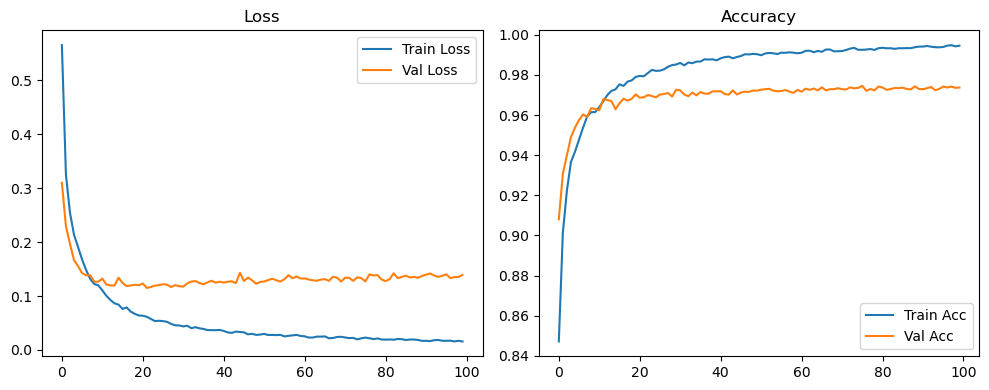

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.9187, Acc: 0.7113 | Val Loss: 0.3620, Acc: 0.8929


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.5354, Acc: 0.8374 | Val Loss: 0.3161, Acc: 0.9053


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.4454, Acc: 0.8682 | Val Loss: 0.2812, Acc: 0.9168


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3952, Acc: 0.8821 | Val Loss: 0.2541, Acc: 0.9232


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3625, Acc: 0.8903 | Val Loss: 0.2350, Acc: 0.9286


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3271, Acc: 0.9024 | Val Loss: 0.2172, Acc: 0.9347


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.3011, Acc: 0.9112 | Val Loss: 0.1965, Acc: 0.9426


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2744, Acc: 0.9177 | Val Loss: 0.1916, Acc: 0.9433


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2635, Acc: 0.9210 | Val Loss: 0.1763, Acc: 0.9469


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2485, Acc: 0.9253 | Val Loss: 0.1735, Acc: 0.9493


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2319, Acc: 0.9298 | Val Loss: 0.1625, Acc: 0.9522


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.2218, Acc: 0.9329 | Val Loss: 0.1498, Acc: 0.9554


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.2111, Acc: 0.9365 | Val Loss: 0.1503, Acc: 0.9551


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.2022, Acc: 0.9384 | Val Loss: 0.1459, Acc: 0.9569


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1940, Acc: 0.9411 | Val Loss: 0.1411, Acc: 0.9587


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1845, Acc: 0.9450 | Val Loss: 0.1366, Acc: 0.9617


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1770, Acc: 0.9457 | Val Loss: 0.1304, Acc: 0.9628


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1737, Acc: 0.9466 | Val Loss: 0.1306, Acc: 0.9629


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1690, Acc: 0.9493 | Val Loss: 0.1257, Acc: 0.9646


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1633, Acc: 0.9494 | Val Loss: 0.1244, Acc: 0.9645


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1553, Acc: 0.9539 | Val Loss: 0.1220, Acc: 0.9649


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1472, Acc: 0.9547 | Val Loss: 0.1226, Acc: 0.9653


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1459, Acc: 0.9539 | Val Loss: 0.1219, Acc: 0.9665


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1439, Acc: 0.9555 | Val Loss: 0.1226, Acc: 0.9656


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1400, Acc: 0.9569 | Val Loss: 0.1227, Acc: 0.9659


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1387, Acc: 0.9580 | Val Loss: 0.1138, Acc: 0.9677


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1378, Acc: 0.9581 | Val Loss: 0.1171, Acc: 0.9670


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1273, Acc: 0.9597 | Val Loss: 0.1110, Acc: 0.9680


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1292, Acc: 0.9608 | Val Loss: 0.1131, Acc: 0.9673


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1264, Acc: 0.9612 | Val Loss: 0.1109, Acc: 0.9700


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1232, Acc: 0.9631 | Val Loss: 0.1084, Acc: 0.9687


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1230, Acc: 0.9621 | Val Loss: 0.1126, Acc: 0.9683


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1166, Acc: 0.9636 | Val Loss: 0.1121, Acc: 0.9685


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1164, Acc: 0.9633 | Val Loss: 0.1121, Acc: 0.9694


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1138, Acc: 0.9637 | Val Loss: 0.1116, Acc: 0.9693


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1130, Acc: 0.9642 | Val Loss: 0.1072, Acc: 0.9711


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.1077, Acc: 0.9660 | Val Loss: 0.1084, Acc: 0.9711


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.1079, Acc: 0.9664 | Val Loss: 0.1098, Acc: 0.9690


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.1057, Acc: 0.9667 | Val Loss: 0.1113, Acc: 0.9702


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.1063, Acc: 0.9669 | Val Loss: 0.1066, Acc: 0.9709


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.1029, Acc: 0.9676 | Val Loss: 0.1115, Acc: 0.9693


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.1000, Acc: 0.9677 | Val Loss: 0.1054, Acc: 0.9701


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0930, Acc: 0.9704 | Val Loss: 0.1099, Acc: 0.9700


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0971, Acc: 0.9687 | Val Loss: 0.1067, Acc: 0.9707


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0990, Acc: 0.9691 | Val Loss: 0.1074, Acc: 0.9721


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0920, Acc: 0.9713 | Val Loss: 0.1090, Acc: 0.9709


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0981, Acc: 0.9689 | Val Loss: 0.1020, Acc: 0.9712


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0906, Acc: 0.9712 | Val Loss: 0.1104, Acc: 0.9700


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0941, Acc: 0.9697 | Val Loss: 0.1060, Acc: 0.9712


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0882, Acc: 0.9728 | Val Loss: 0.1070, Acc: 0.9708


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0906, Acc: 0.9712 | Val Loss: 0.1048, Acc: 0.9713


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0892, Acc: 0.9709 | Val Loss: 0.1039, Acc: 0.9716


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0878, Acc: 0.9724 | Val Loss: 0.1060, Acc: 0.9712


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0860, Acc: 0.9729 | Val Loss: 0.1079, Acc: 0.9706


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0836, Acc: 0.9738 | Val Loss: 0.1071, Acc: 0.9721


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0838, Acc: 0.9732 | Val Loss: 0.1071, Acc: 0.9718


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0810, Acc: 0.9742 | Val Loss: 0.1050, Acc: 0.9726


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0819, Acc: 0.9735 | Val Loss: 0.1044, Acc: 0.9718


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9731 | Val Loss: 0.1043, Acc: 0.9728


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0817, Acc: 0.9740 | Val Loss: 0.1066, Acc: 0.9712


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0757, Acc: 0.9750 | Val Loss: 0.1063, Acc: 0.9718


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0772, Acc: 0.9753 | Val Loss: 0.1012, Acc: 0.9722


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9760 | Val Loss: 0.1005, Acc: 0.9732


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9755 | Val Loss: 0.1042, Acc: 0.9734


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9754 | Val Loss: 0.1044, Acc: 0.9728


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0775, Acc: 0.9755 | Val Loss: 0.1000, Acc: 0.9732


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0736, Acc: 0.9762 | Val Loss: 0.1118, Acc: 0.9727


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9758 | Val Loss: 0.1030, Acc: 0.9729


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0711, Acc: 0.9766 | Val Loss: 0.1053, Acc: 0.9722


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0732, Acc: 0.9764 | Val Loss: 0.1021, Acc: 0.9742


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0734, Acc: 0.9765 | Val Loss: 0.1049, Acc: 0.9720


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0692, Acc: 0.9782 | Val Loss: 0.1047, Acc: 0.9720


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9778 | Val Loss: 0.1073, Acc: 0.9716


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0710, Acc: 0.9777 | Val Loss: 0.1081, Acc: 0.9721


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0702, Acc: 0.9767 | Val Loss: 0.1020, Acc: 0.9725


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0705, Acc: 0.9774 | Val Loss: 0.1025, Acc: 0.9736


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0710, Acc: 0.9771 | Val Loss: 0.1021, Acc: 0.9724


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0687, Acc: 0.9778 | Val Loss: 0.1026, Acc: 0.9733


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9782 | Val Loss: 0.1036, Acc: 0.9731


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0667, Acc: 0.9786 | Val Loss: 0.1025, Acc: 0.9734


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9786 | Val Loss: 0.1003, Acc: 0.9739


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.1065, Acc: 0.9725


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0656, Acc: 0.9795 | Val Loss: 0.1067, Acc: 0.9723


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9793 | Val Loss: 0.1047, Acc: 0.9732


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9801 | Val Loss: 0.1068, Acc: 0.9728


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9796 | Val Loss: 0.1057, Acc: 0.9718


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9791 | Val Loss: 0.1047, Acc: 0.9719


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9790 | Val Loss: 0.1074, Acc: 0.9736


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.1048, Acc: 0.9733


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9806 | Val Loss: 0.1004, Acc: 0.9737


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9809 | Val Loss: 0.1069, Acc: 0.9735


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9793 | Val Loss: 0.1053, Acc: 0.9736


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9811 | Val Loss: 0.1039, Acc: 0.9741


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9797 | Val Loss: 0.1044, Acc: 0.9732


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9814 | Val Loss: 0.1055, Acc: 0.9743


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9803 | Val Loss: 0.0994, Acc: 0.9748


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9815 | Val Loss: 0.1037, Acc: 0.9733


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9809 | Val Loss: 0.1018, Acc: 0.9732


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9806 | Val Loss: 0.1008, Acc: 0.9730


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.1027, Acc: 0.9728


Final Test Loss: 0.0885 Accuracy: 0.9779


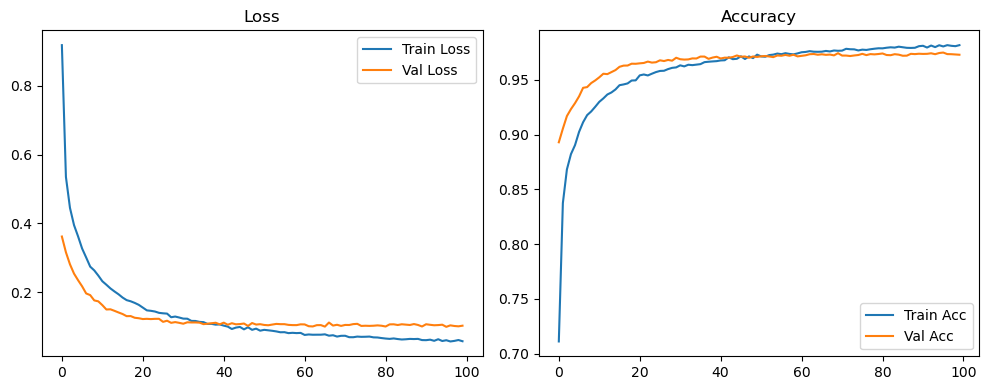

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5120, Acc: 0.8844 | Val Loss: 0.3076, Acc: 0.9116


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1868, Acc: 0.9464 | Val Loss: 0.1402, Acc: 0.9565


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0920, Acc: 0.9733 | Val Loss: 0.1164, Acc: 0.9641


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0592, Acc: 0.9822 | Val Loss: 0.1011, Acc: 0.9687


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9879 | Val Loss: 0.0953, Acc: 0.9700


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9922 | Val Loss: 0.1002, Acc: 0.9704


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9942 | Val Loss: 0.1126, Acc: 0.9671


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9951 | Val Loss: 0.1179, Acc: 0.9660


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1013, Acc: 0.9732


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1056, Acc: 0.9708


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1133, Acc: 0.9699


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1003, Acc: 0.9733


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1150, Acc: 0.9712


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1118, Acc: 0.9728


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1395, Acc: 0.9665


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1334, Acc: 0.9703


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1311, Acc: 0.9688


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1233, Acc: 0.9695


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1253, Acc: 0.9703


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1215, Acc: 0.9726


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1369, Acc: 0.9685


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1249, Acc: 0.9740


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1155, Acc: 0.9747


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1177, Acc: 0.9728


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1260, Acc: 0.9722


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1465, Acc: 0.9692


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1179, Acc: 0.9753


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9981 | Val Loss: 0.1212, Acc: 0.9730


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1231, Acc: 0.9742


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1492, Acc: 0.9694


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1278, Acc: 0.9744


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1147, Acc: 0.9753


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1302, Acc: 0.9736


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1269, Acc: 0.9752


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1345, Acc: 0.9738


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1234, Acc: 0.9728


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1420, Acc: 0.9738


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1491, Acc: 0.9692


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1275, Acc: 0.9737


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1331, Acc: 0.9733


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1344, Acc: 0.9722


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1182, Acc: 0.9765


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1269, Acc: 0.9752


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1257, Acc: 0.9743


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1386, Acc: 0.9732


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1211, Acc: 0.9758


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1292, Acc: 0.9754


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1446, Acc: 0.9733


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1402, Acc: 0.9722


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1204, Acc: 0.9757


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1170, Acc: 0.9770


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1416, Acc: 0.9739


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1247, Acc: 0.9761


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1276, Acc: 0.9748


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1475, Acc: 0.9700


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1446, Acc: 0.9738


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1311, Acc: 0.9751


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1199, Acc: 0.9768


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1293, Acc: 0.9766


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1428, Acc: 0.9738


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1477, Acc: 0.9721


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1297, Acc: 0.9766


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1257, Acc: 0.9772


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1337, Acc: 0.9763


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1362, Acc: 0.9768


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1328, Acc: 0.9753


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1358, Acc: 0.9752


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1440, Acc: 0.9755


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1462, Acc: 0.9733


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1349, Acc: 0.9747


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1299, Acc: 0.9745


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1447, Acc: 0.9736


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1389, Acc: 0.9756


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1376, Acc: 0.9760


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1271, Acc: 0.9782


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1378, Acc: 0.9752


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1333, Acc: 0.9769


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1474, Acc: 0.9742


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1379, Acc: 0.9747


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1353, Acc: 0.9749


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1260, Acc: 0.9775


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1427, Acc: 0.9750


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1417, Acc: 0.9757


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1442, Acc: 0.9756


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1440, Acc: 0.9751


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1421, Acc: 0.9748


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1353, Acc: 0.9753


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1308, Acc: 0.9774


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1297, Acc: 0.9764


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1455, Acc: 0.9759


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1565, Acc: 0.9737


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1285, Acc: 0.9776


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1447, Acc: 0.9744


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1423, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1303, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1418, Acc: 0.9758


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1375, Acc: 0.9753


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1573, Acc: 0.9737


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1419, Acc: 0.9756


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1415, Acc: 0.9778


Final Test Loss: 0.1177 Accuracy: 0.9775


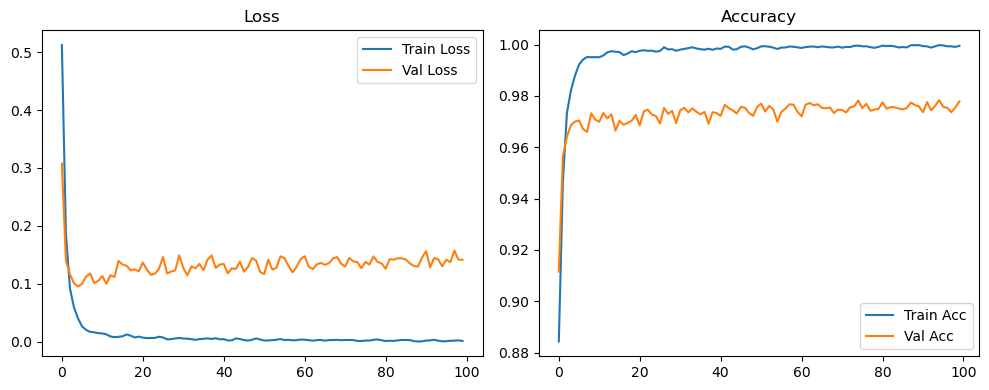

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6856, Acc: 0.8323 | Val Loss: 0.3426, Acc: 0.9015


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3604, Acc: 0.8929 | Val Loss: 0.2537, Acc: 0.9230


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2816, Acc: 0.9153 | Val Loss: 0.2066, Acc: 0.9385


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2363, Acc: 0.9287 | Val Loss: 0.1744, Acc: 0.9458


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2128, Acc: 0.9347 | Val Loss: 0.1585, Acc: 0.9509


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1880, Acc: 0.9421 | Val Loss: 0.1464, Acc: 0.9553


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1676, Acc: 0.9478 | Val Loss: 0.1409, Acc: 0.9582


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1525, Acc: 0.9524 | Val Loss: 0.1394, Acc: 0.9580


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1427, Acc: 0.9547 | Val Loss: 0.1319, Acc: 0.9608


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1367, Acc: 0.9572 | Val Loss: 0.1319, Acc: 0.9604


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1323, Acc: 0.9582 | Val Loss: 0.1312, Acc: 0.9623


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1175, Acc: 0.9633 | Val Loss: 0.1220, Acc: 0.9651


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1119, Acc: 0.9642 | Val Loss: 0.1242, Acc: 0.9651


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1029, Acc: 0.9666 | Val Loss: 0.1185, Acc: 0.9662


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1000, Acc: 0.9669 | Val Loss: 0.1256, Acc: 0.9643


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0939, Acc: 0.9704 | Val Loss: 0.1161, Acc: 0.9673


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0951, Acc: 0.9694 | Val Loss: 0.1158, Acc: 0.9688


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0879, Acc: 0.9713 | Val Loss: 0.1207, Acc: 0.9668


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0835, Acc: 0.9726 | Val Loss: 0.1194, Acc: 0.9671


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0810, Acc: 0.9736 | Val Loss: 0.1185, Acc: 0.9677


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9747 | Val Loss: 0.1163, Acc: 0.9690


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0758, Acc: 0.9754 | Val Loss: 0.1182, Acc: 0.9688


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0725, Acc: 0.9759 | Val Loss: 0.1128, Acc: 0.9673


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0674, Acc: 0.9775 | Val Loss: 0.1197, Acc: 0.9673


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9781 | Val Loss: 0.1167, Acc: 0.9692


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0657, Acc: 0.9789 | Val Loss: 0.1186, Acc: 0.9689


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0621, Acc: 0.9802 | Val Loss: 0.1234, Acc: 0.9688


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9802 | Val Loss: 0.1187, Acc: 0.9689


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0578, Acc: 0.9806 | Val Loss: 0.1196, Acc: 0.9708


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9812 | Val Loss: 0.1175, Acc: 0.9698


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9819 | Val Loss: 0.1263, Acc: 0.9692


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9814 | Val Loss: 0.1204, Acc: 0.9683


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9831 | Val Loss: 0.1215, Acc: 0.9688


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9834 | Val Loss: 0.1209, Acc: 0.9698


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9834 | Val Loss: 0.1240, Acc: 0.9693


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9836 | Val Loss: 0.1228, Acc: 0.9698


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9850 | Val Loss: 0.1214, Acc: 0.9715


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9841 | Val Loss: 0.1261, Acc: 0.9692


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9845 | Val Loss: 0.1262, Acc: 0.9701


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9847 | Val Loss: 0.1273, Acc: 0.9702


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9864 | Val Loss: 0.1179, Acc: 0.9712


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9859 | Val Loss: 0.1192, Acc: 0.9702


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.1236, Acc: 0.9702


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9863 | Val Loss: 0.1236, Acc: 0.9699


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9868 | Val Loss: 0.1306, Acc: 0.9707


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9869 | Val Loss: 0.1233, Acc: 0.9720


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9875 | Val Loss: 0.1286, Acc: 0.9694


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.1239, Acc: 0.9711


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9870 | Val Loss: 0.1274, Acc: 0.9710


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9874 | Val Loss: 0.1265, Acc: 0.9704


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.1247, Acc: 0.9703


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.1280, Acc: 0.9709


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9879 | Val Loss: 0.1262, Acc: 0.9712


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9881 | Val Loss: 0.1336, Acc: 0.9706


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9880 | Val Loss: 0.1269, Acc: 0.9715


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.1295, Acc: 0.9708


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1304, Acc: 0.9715


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9891 | Val Loss: 0.1280, Acc: 0.9703


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.1347, Acc: 0.9697


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9895 | Val Loss: 0.1274, Acc: 0.9712


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9902 | Val Loss: 0.1347, Acc: 0.9705


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.1233, Acc: 0.9721


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.1238, Acc: 0.9732


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9901 | Val Loss: 0.1321, Acc: 0.9710


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.1316, Acc: 0.9715


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.1296, Acc: 0.9724


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9906 | Val Loss: 0.1351, Acc: 0.9720


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.1256, Acc: 0.9722


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.1333, Acc: 0.9729


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.1318, Acc: 0.9718


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.1297, Acc: 0.9715


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1403, Acc: 0.9710


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.1330, Acc: 0.9722


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.1314, Acc: 0.9715


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.1355, Acc: 0.9717


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9901 | Val Loss: 0.1317, Acc: 0.9718


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.1371, Acc: 0.9708


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1402, Acc: 0.9711


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.1373, Acc: 0.9715


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.1369, Acc: 0.9718


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.1354, Acc: 0.9718


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9916 | Val Loss: 0.1421, Acc: 0.9720


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1402, Acc: 0.9718


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9910 | Val Loss: 0.1371, Acc: 0.9714


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1399, Acc: 0.9724


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1402, Acc: 0.9729


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1382, Acc: 0.9725


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1379, Acc: 0.9719


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1357, Acc: 0.9732


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.1318, Acc: 0.9716


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.1412, Acc: 0.9704


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1402, Acc: 0.9716


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.1371, Acc: 0.9712


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.1426, Acc: 0.9732


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.1388, Acc: 0.9718


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1356, Acc: 0.9725


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1389, Acc: 0.9719


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1356, Acc: 0.9736


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1369, Acc: 0.9727


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1454, Acc: 0.9728


Final Test Loss: 0.1222 Accuracy: 0.9744


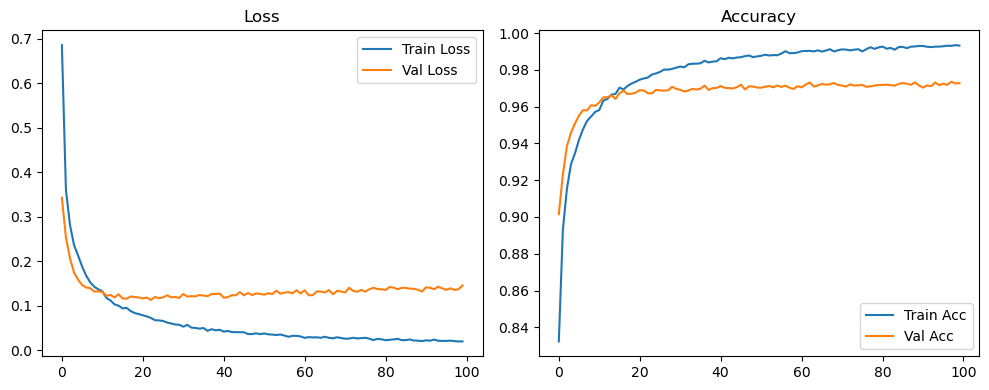

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.1191, Acc: 0.6566 | Val Loss: 0.4441, Acc: 0.8859


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.6251, Acc: 0.8086 | Val Loss: 0.3473, Acc: 0.8990


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.5149, Acc: 0.8470 | Val Loss: 0.3153, Acc: 0.9073


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.4626, Acc: 0.8612 | Val Loss: 0.2924, Acc: 0.9133


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.4287, Acc: 0.8711 | Val Loss: 0.2719, Acc: 0.9179


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.3935, Acc: 0.8840 | Val Loss: 0.2593, Acc: 0.9219


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.3660, Acc: 0.8917 | Val Loss: 0.2433, Acc: 0.9272


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3434, Acc: 0.8989 | Val Loss: 0.2359, Acc: 0.9282


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.3306, Acc: 0.9011 | Val Loss: 0.2242, Acc: 0.9323


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.3136, Acc: 0.9075 | Val Loss: 0.2179, Acc: 0.9346


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.3007, Acc: 0.9107 | Val Loss: 0.2084, Acc: 0.9370


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.2900, Acc: 0.9139 | Val Loss: 0.1937, Acc: 0.9403


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2761, Acc: 0.9171 | Val Loss: 0.1933, Acc: 0.9435


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2630, Acc: 0.9219 | Val Loss: 0.1882, Acc: 0.9443


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2557, Acc: 0.9240 | Val Loss: 0.1830, Acc: 0.9456


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2458, Acc: 0.9269 | Val Loss: 0.1764, Acc: 0.9483


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.2343, Acc: 0.9294 | Val Loss: 0.1694, Acc: 0.9494


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.2258, Acc: 0.9319 | Val Loss: 0.1654, Acc: 0.9510


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.2215, Acc: 0.9338 | Val Loss: 0.1635, Acc: 0.9518


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.2145, Acc: 0.9347 | Val Loss: 0.1567, Acc: 0.9540


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.2048, Acc: 0.9385 | Val Loss: 0.1572, Acc: 0.9549


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.2013, Acc: 0.9388 | Val Loss: 0.1521, Acc: 0.9553


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1973, Acc: 0.9397 | Val Loss: 0.1528, Acc: 0.9540


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1917, Acc: 0.9425 | Val Loss: 0.1497, Acc: 0.9560


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1855, Acc: 0.9432 | Val Loss: 0.1495, Acc: 0.9567


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1843, Acc: 0.9453 | Val Loss: 0.1401, Acc: 0.9585


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1794, Acc: 0.9461 | Val Loss: 0.1450, Acc: 0.9588


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1707, Acc: 0.9472 | Val Loss: 0.1380, Acc: 0.9601


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1670, Acc: 0.9496 | Val Loss: 0.1390, Acc: 0.9600


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1666, Acc: 0.9502 | Val Loss: 0.1356, Acc: 0.9617


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1610, Acc: 0.9515 | Val Loss: 0.1339, Acc: 0.9625


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1593, Acc: 0.9516 | Val Loss: 0.1332, Acc: 0.9623


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1542, Acc: 0.9529 | Val Loss: 0.1332, Acc: 0.9617


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1495, Acc: 0.9545 | Val Loss: 0.1280, Acc: 0.9631


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1489, Acc: 0.9542 | Val Loss: 0.1320, Acc: 0.9627


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1484, Acc: 0.9542 | Val Loss: 0.1284, Acc: 0.9633


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1428, Acc: 0.9563 | Val Loss: 0.1281, Acc: 0.9647


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1447, Acc: 0.9556 | Val Loss: 0.1286, Acc: 0.9639


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1372, Acc: 0.9569 | Val Loss: 0.1306, Acc: 0.9636


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1373, Acc: 0.9573 | Val Loss: 0.1263, Acc: 0.9648


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1362, Acc: 0.9571 | Val Loss: 0.1290, Acc: 0.9647


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1297, Acc: 0.9605 | Val Loss: 0.1262, Acc: 0.9637


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1243, Acc: 0.9614 | Val Loss: 0.1255, Acc: 0.9657


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1283, Acc: 0.9603 | Val Loss: 0.1219, Acc: 0.9672


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1280, Acc: 0.9602 | Val Loss: 0.1240, Acc: 0.9665


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1241, Acc: 0.9613 | Val Loss: 0.1249, Acc: 0.9661


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1256, Acc: 0.9606 | Val Loss: 0.1205, Acc: 0.9681


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1203, Acc: 0.9627 | Val Loss: 0.1194, Acc: 0.9678


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1216, Acc: 0.9615 | Val Loss: 0.1189, Acc: 0.9673


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.1178, Acc: 0.9627 | Val Loss: 0.1210, Acc: 0.9677


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1160, Acc: 0.9638 | Val Loss: 0.1179, Acc: 0.9682


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.1155, Acc: 0.9630 | Val Loss: 0.1205, Acc: 0.9667


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.1144, Acc: 0.9629 | Val Loss: 0.1187, Acc: 0.9685


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.1126, Acc: 0.9649 | Val Loss: 0.1210, Acc: 0.9676


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.1113, Acc: 0.9649 | Val Loss: 0.1222, Acc: 0.9673


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.1101, Acc: 0.9656 | Val Loss: 0.1164, Acc: 0.9689


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.1069, Acc: 0.9663 | Val Loss: 0.1177, Acc: 0.9678


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.1092, Acc: 0.9653 | Val Loss: 0.1156, Acc: 0.9697


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.1066, Acc: 0.9668 | Val Loss: 0.1160, Acc: 0.9682


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.1052, Acc: 0.9670 | Val Loss: 0.1163, Acc: 0.9679


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.1038, Acc: 0.9668 | Val Loss: 0.1231, Acc: 0.9674


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0994, Acc: 0.9677 | Val Loss: 0.1154, Acc: 0.9689


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0984, Acc: 0.9694 | Val Loss: 0.1157, Acc: 0.9689


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.1009, Acc: 0.9686 | Val Loss: 0.1146, Acc: 0.9702


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0984, Acc: 0.9679 | Val Loss: 0.1210, Acc: 0.9680


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0993, Acc: 0.9685 | Val Loss: 0.1192, Acc: 0.9684


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9702 | Val Loss: 0.1216, Acc: 0.9683


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0965, Acc: 0.9687 | Val Loss: 0.1153, Acc: 0.9692


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0965, Acc: 0.9694 | Val Loss: 0.1175, Acc: 0.9682


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0957, Acc: 0.9698 | Val Loss: 0.1151, Acc: 0.9697


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0945, Acc: 0.9700 | Val Loss: 0.1188, Acc: 0.9690


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0932, Acc: 0.9695 | Val Loss: 0.1148, Acc: 0.9693


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0898, Acc: 0.9714 | Val Loss: 0.1139, Acc: 0.9690


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0939, Acc: 0.9711 | Val Loss: 0.1131, Acc: 0.9695


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0926, Acc: 0.9696 | Val Loss: 0.1152, Acc: 0.9686


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0899, Acc: 0.9706 | Val Loss: 0.1108, Acc: 0.9713


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9721 | Val Loss: 0.1150, Acc: 0.9694


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0878, Acc: 0.9723 | Val Loss: 0.1185, Acc: 0.9690


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0886, Acc: 0.9714 | Val Loss: 0.1155, Acc: 0.9706


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0837, Acc: 0.9730 | Val Loss: 0.1121, Acc: 0.9708


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0860, Acc: 0.9723 | Val Loss: 0.1157, Acc: 0.9702


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0855, Acc: 0.9727 | Val Loss: 0.1168, Acc: 0.9703


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9735 | Val Loss: 0.1152, Acc: 0.9704


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9747 | Val Loss: 0.1186, Acc: 0.9706


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0841, Acc: 0.9730 | Val Loss: 0.1218, Acc: 0.9685


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0799, Acc: 0.9748 | Val Loss: 0.1177, Acc: 0.9688


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.1169, Acc: 0.9704


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0828, Acc: 0.9730 | Val Loss: 0.1175, Acc: 0.9700


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9741 | Val Loss: 0.1162, Acc: 0.9692


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0780, Acc: 0.9758 | Val Loss: 0.1105, Acc: 0.9698


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9754 | Val Loss: 0.1139, Acc: 0.9699


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0793, Acc: 0.9755 | Val Loss: 0.1117, Acc: 0.9708


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0815, Acc: 0.9732 | Val Loss: 0.1134, Acc: 0.9693


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0803, Acc: 0.9737 | Val Loss: 0.1142, Acc: 0.9702


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9756 | Val Loss: 0.1154, Acc: 0.9714


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0757, Acc: 0.9756 | Val Loss: 0.1137, Acc: 0.9700


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0754, Acc: 0.9759 | Val Loss: 0.1155, Acc: 0.9705


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9759 | Val Loss: 0.1140, Acc: 0.9708


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0779, Acc: 0.9753 | Val Loss: 0.1154, Acc: 0.9699


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0744, Acc: 0.9759 | Val Loss: 0.1133, Acc: 0.9705


Final Test Loss: 0.1020 Accuracy: 0.9737


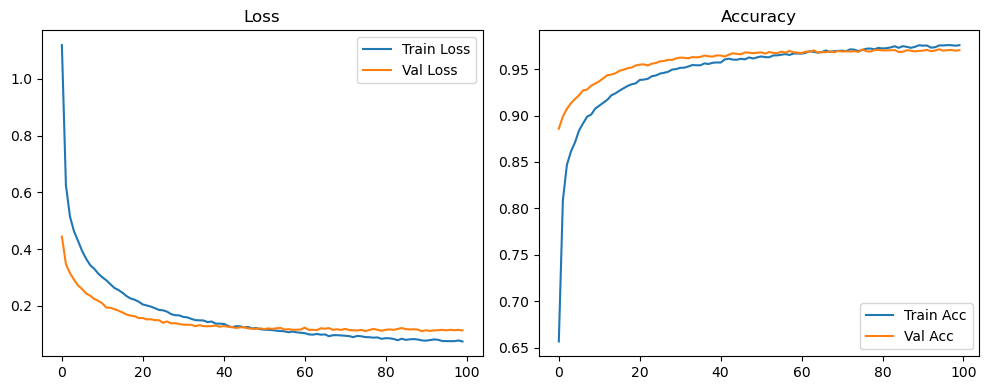

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3852, Acc: 0.8873 | Val Loss: 0.2820, Acc: 0.9119


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1941, Acc: 0.9417 | Val Loss: 0.1793, Acc: 0.9440


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1159, Acc: 0.9632 | Val Loss: 0.1444, Acc: 0.9566


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9756 | Val Loss: 0.1342, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9819 | Val Loss: 0.1390, Acc: 0.9621


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 0.1525, Acc: 0.9603


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9882 | Val Loss: 0.1346, Acc: 0.9641


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.1267, Acc: 0.9675


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9907 | Val Loss: 0.1418, Acc: 0.9655


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.1308, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.1241, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.1318, Acc: 0.9692


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.1625, Acc: 0.9642


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1543, Acc: 0.9659


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9957 | Val Loss: 0.1645, Acc: 0.9646


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1936, Acc: 0.9614


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1323, Acc: 0.9683


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1375, Acc: 0.9698


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1504, Acc: 0.9666


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1415, Acc: 0.9693


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1356, Acc: 0.9684


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1794, Acc: 0.9653


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1509, Acc: 0.9696


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1531, Acc: 0.9666


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1361, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1795, Acc: 0.9683


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1792, Acc: 0.9664


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1554, Acc: 0.9722


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1554, Acc: 0.9718


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1597, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1912, Acc: 0.9678


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1591, Acc: 0.9696


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1529, Acc: 0.9719


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1385, Acc: 0.9716


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1702, Acc: 0.9683


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1287, Acc: 0.9722


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1846, Acc: 0.9667


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1562, Acc: 0.9728


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1449, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1657, Acc: 0.9692


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9714


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1387, Acc: 0.9725


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1494, Acc: 0.9721


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1275, Acc: 0.9711


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1734, Acc: 0.9718


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1546, Acc: 0.9715


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1411, Acc: 0.9712


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2130, Acc: 0.9672


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1834, Acc: 0.9675


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1402, Acc: 0.9705


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1446, Acc: 0.9740


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1336, Acc: 0.9718


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1298, Acc: 0.9728


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1480, Acc: 0.9733


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1746, Acc: 0.9720


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1610, Acc: 0.9743


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1647, Acc: 0.9722


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1866, Acc: 0.9697


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1448, Acc: 0.9720


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2328, Acc: 0.9598


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1722, Acc: 0.9731


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1754, Acc: 0.9752


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1695, Acc: 0.9722


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1844, Acc: 0.9744


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1237, Acc: 0.9745


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.2153, Acc: 0.9678


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1512, Acc: 0.9738


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1838, Acc: 0.9708


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1962, Acc: 0.9667


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1558, Acc: 0.9745


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1419, Acc: 0.9720


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1376, Acc: 0.9739


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1653, Acc: 0.9731


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1630, Acc: 0.9732


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1569, Acc: 0.9731


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1584, Acc: 0.9754


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1769, Acc: 0.9742


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1455, Acc: 0.9747


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1655, Acc: 0.9712


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1486, Acc: 0.9746


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2008, Acc: 0.9715


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2139, Acc: 0.9713


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1358, Acc: 0.9715


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1823, Acc: 0.9702


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1526, Acc: 0.9712


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1609, Acc: 0.9740


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1478, Acc: 0.9759


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1598, Acc: 0.9764


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1755, Acc: 0.9741


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1553, Acc: 0.9741


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1604, Acc: 0.9748


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1528, Acc: 0.9757


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1498, Acc: 0.9706


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1715, Acc: 0.9725


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1391, Acc: 0.9742


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1509, Acc: 0.9755


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1799, Acc: 0.9739


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1561, Acc: 0.9732


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1746, Acc: 0.9752


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1769, Acc: 0.9732


Final Test Loss: 0.1597 Accuracy: 0.9762


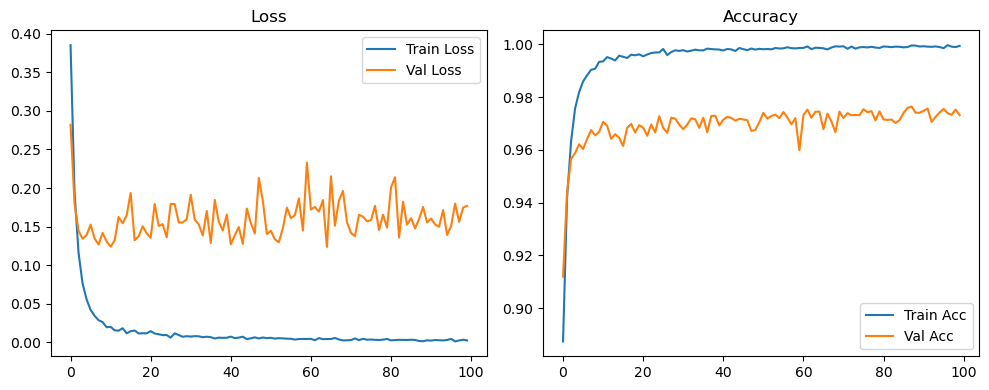

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4901, Acc: 0.8508 | Val Loss: 0.2810, Acc: 0.9157


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2769, Acc: 0.9168 | Val Loss: 0.2185, Acc: 0.9333


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1985, Acc: 0.9399 | Val Loss: 0.1849, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9543 | Val Loss: 0.1343, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9597 | Val Loss: 0.1292, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9675 | Val Loss: 0.1183, Acc: 0.9660


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9711 | Val Loss: 0.1171, Acc: 0.9668


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9742 | Val Loss: 0.1180, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9770 | Val Loss: 0.1117, Acc: 0.9684


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9787 | Val Loss: 0.1068, Acc: 0.9709


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9826 | Val Loss: 0.1059, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9847 | Val Loss: 0.1094, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.1167, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9859 | Val Loss: 0.1126, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0986, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.1058, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1186, Acc: 0.9722


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.1070, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.1054, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9892 | Val Loss: 0.1090, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1190, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1120, Acc: 0.9733


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1096, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9910 | Val Loss: 0.1099, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.1091, Acc: 0.9737


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1143, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.1258, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9921 | Val Loss: 0.1151, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1102, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1242, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1200, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1151, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1095, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1113, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1182, Acc: 0.9739


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1206, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1255, Acc: 0.9752


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1193, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1093, Acc: 0.9770


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1224, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1267, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1135, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1172, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1098, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1262, Acc: 0.9750


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1199, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1246, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1276, Acc: 0.9743


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1114, Acc: 0.9761


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9763


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1277, Acc: 0.9748


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1361, Acc: 0.9767


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1280, Acc: 0.9771


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1072, Acc: 0.9749


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9956 | Val Loss: 0.1317, Acc: 0.9763


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1269, Acc: 0.9755


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9959 | Val Loss: 0.1371, Acc: 0.9755


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1355, Acc: 0.9751


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1121, Acc: 0.9770


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1237, Acc: 0.9760


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1203, Acc: 0.9763


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1194, Acc: 0.9776


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1322, Acc: 0.9771


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1365, Acc: 0.9769


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1261, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1179, Acc: 0.9772


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1272, Acc: 0.9762


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1303, Acc: 0.9773


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1150, Acc: 0.9762


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1087, Acc: 0.9757


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9963 | Val Loss: 0.1444, Acc: 0.9766


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1169, Acc: 0.9769


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1422, Acc: 0.9752


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1159, Acc: 0.9762


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1152, Acc: 0.9769


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1324, Acc: 0.9776


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1210, Acc: 0.9776


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1309, Acc: 0.9774


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1180, Acc: 0.9783


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1073, Acc: 0.9764


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1187, Acc: 0.9787


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1184, Acc: 0.9783


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1283, Acc: 0.9771


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1203, Acc: 0.9756


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1230, Acc: 0.9765


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1196, Acc: 0.9766


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1294, Acc: 0.9766


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1397, Acc: 0.9765


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1257, Acc: 0.9770


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1199, Acc: 0.9775


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1132, Acc: 0.9778


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1307, Acc: 0.9782


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1189, Acc: 0.9785


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1147, Acc: 0.9776


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1300, Acc: 0.9762


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1271, Acc: 0.9781


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1592, Acc: 0.9770


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1140, Acc: 0.9778


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1240, Acc: 0.9772


Final Test Loss: 0.1136 Accuracy: 0.9775


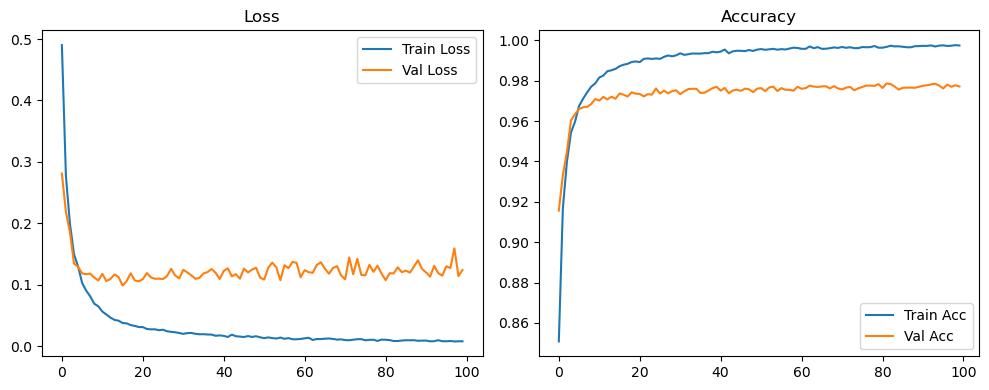

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7556, Acc: 0.7556 | Val Loss: 0.3281, Acc: 0.9027


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4313, Acc: 0.8692 | Val Loss: 0.2622, Acc: 0.9217


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3476, Acc: 0.8978 | Val Loss: 0.2311, Acc: 0.9323


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2849, Acc: 0.9163 | Val Loss: 0.1804, Acc: 0.9448


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2449, Acc: 0.9274 | Val Loss: 0.1625, Acc: 0.9512


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2166, Acc: 0.9359 | Val Loss: 0.1486, Acc: 0.9561


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1992, Acc: 0.9414 | Val Loss: 0.1428, Acc: 0.9582


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1824, Acc: 0.9452 | Val Loss: 0.1360, Acc: 0.9614


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1712, Acc: 0.9479 | Val Loss: 0.1283, Acc: 0.9627


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9524 | Val Loss: 0.1242, Acc: 0.9637


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1501, Acc: 0.9546 | Val Loss: 0.1214, Acc: 0.9649


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9565 | Val Loss: 0.1180, Acc: 0.9666


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9585 | Val Loss: 0.1122, Acc: 0.9662


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9600 | Val Loss: 0.1144, Acc: 0.9670


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9616 | Val Loss: 0.1108, Acc: 0.9698


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1224, Acc: 0.9626 | Val Loss: 0.1112, Acc: 0.9684


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9634 | Val Loss: 0.1033, Acc: 0.9700


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9652 | Val Loss: 0.1061, Acc: 0.9700


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9679 | Val Loss: 0.1057, Acc: 0.9686


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9682 | Val Loss: 0.1068, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9683 | Val Loss: 0.1035, Acc: 0.9715


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9687 | Val Loss: 0.1027, Acc: 0.9697


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9690 | Val Loss: 0.1027, Acc: 0.9706


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0997, Acc: 0.9706


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9717 | Val Loss: 0.1008, Acc: 0.9723


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9716 | Val Loss: 0.1020, Acc: 0.9724


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9734 | Val Loss: 0.1002, Acc: 0.9721


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9741 | Val Loss: 0.1044, Acc: 0.9728


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9753 | Val Loss: 0.1050, Acc: 0.9720


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9755 | Val Loss: 0.0977, Acc: 0.9743


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9757 | Val Loss: 0.0977, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9753 | Val Loss: 0.0984, Acc: 0.9726


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9760 | Val Loss: 0.0977, Acc: 0.9745


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9778 | Val Loss: 0.0996, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9771 | Val Loss: 0.1007, Acc: 0.9730


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9768 | Val Loss: 0.0973, Acc: 0.9736


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9770 | Val Loss: 0.0966, Acc: 0.9725


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0995, Acc: 0.9735


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9741


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9788 | Val Loss: 0.0946, Acc: 0.9753


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9784 | Val Loss: 0.0965, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.1009, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9804 | Val Loss: 0.0950, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9795 | Val Loss: 0.1013, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0967, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9794 | Val Loss: 0.0939, Acc: 0.9748


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9799 | Val Loss: 0.0975, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9819 | Val Loss: 0.1045, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9812 | Val Loss: 0.0997, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9809 | Val Loss: 0.0925, Acc: 0.9748


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9826 | Val Loss: 0.0988, Acc: 0.9756


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9815 | Val Loss: 0.0952, Acc: 0.9754


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9827 | Val Loss: 0.1017, Acc: 0.9744


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9821 | Val Loss: 0.0902, Acc: 0.9759


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9819 | Val Loss: 0.0984, Acc: 0.9754


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9823 | Val Loss: 0.0924, Acc: 0.9745


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9816 | Val Loss: 0.1032, Acc: 0.9739


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9836 | Val Loss: 0.1058, Acc: 0.9750


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9830 | Val Loss: 0.0973, Acc: 0.9745


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9828 | Val Loss: 0.0987, Acc: 0.9742


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9838 | Val Loss: 0.1037, Acc: 0.9752


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9829 | Val Loss: 0.1009, Acc: 0.9752


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9846 | Val Loss: 0.0977, Acc: 0.9755


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9846 | Val Loss: 0.1072, Acc: 0.9763


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9847 | Val Loss: 0.1074, Acc: 0.9742


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9847 | Val Loss: 0.0964, Acc: 0.9758


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9844 | Val Loss: 0.1046, Acc: 0.9749


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.1039, Acc: 0.9748


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9845 | Val Loss: 0.1112, Acc: 0.9754


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.1017, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0960, Acc: 0.9765


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9859 | Val Loss: 0.1039, Acc: 0.9752


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.1031, Acc: 0.9751


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9852 | Val Loss: 0.0973, Acc: 0.9761


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1023, Acc: 0.9744


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.1010, Acc: 0.9751


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 0.0938, Acc: 0.9754


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 0.0993, Acc: 0.9755


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9851 | Val Loss: 0.1026, Acc: 0.9748


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9850 | Val Loss: 0.1023, Acc: 0.9752


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9855 | Val Loss: 0.1056, Acc: 0.9750


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.1018, Acc: 0.9752


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9862 | Val Loss: 0.1024, Acc: 0.9750


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.0974, Acc: 0.9752


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.1074, Acc: 0.9749


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.1082, Acc: 0.9744


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9859 | Val Loss: 0.1145, Acc: 0.9748


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0996, Acc: 0.9757


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9876 | Val Loss: 0.0998, Acc: 0.9751


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9875 | Val Loss: 0.1021, Acc: 0.9766


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9874 | Val Loss: 0.0960, Acc: 0.9755


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.0932, Acc: 0.9761


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.0928, Acc: 0.9762


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.0996, Acc: 0.9742


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9876 | Val Loss: 0.0934, Acc: 0.9760


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.1145, Acc: 0.9759


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9867 | Val Loss: 0.1059, Acc: 0.9768


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.1074, Acc: 0.9752


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.1038, Acc: 0.9748


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.1047, Acc: 0.9758


Final Test Loss: 0.0922 Accuracy: 0.9795


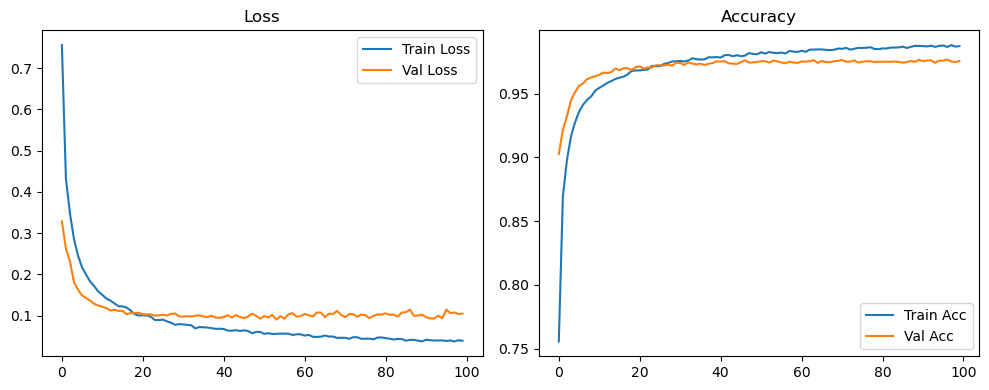

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3852, Acc: 0.8873 | Val Loss: 0.2820, Acc: 0.9119


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1941, Acc: 0.9417 | Val Loss: 0.1793, Acc: 0.9440


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1159, Acc: 0.9632 | Val Loss: 0.1444, Acc: 0.9566


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9756 | Val Loss: 0.1342, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9819 | Val Loss: 0.1390, Acc: 0.9621


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 0.1525, Acc: 0.9603


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9882 | Val Loss: 0.1346, Acc: 0.9641


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.1267, Acc: 0.9675


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9907 | Val Loss: 0.1418, Acc: 0.9655


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.1308, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.1241, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.1318, Acc: 0.9692


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.1625, Acc: 0.9642


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1543, Acc: 0.9659


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9957 | Val Loss: 0.1645, Acc: 0.9646


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1936, Acc: 0.9614


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1323, Acc: 0.9683


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1375, Acc: 0.9698


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1504, Acc: 0.9666


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1415, Acc: 0.9693


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1356, Acc: 0.9684


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1794, Acc: 0.9653


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1509, Acc: 0.9696


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1531, Acc: 0.9666


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1361, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1795, Acc: 0.9683


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1792, Acc: 0.9664


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1554, Acc: 0.9722


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1554, Acc: 0.9718


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1597, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1912, Acc: 0.9678


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1591, Acc: 0.9696


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1529, Acc: 0.9719


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1385, Acc: 0.9716


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1702, Acc: 0.9683


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1287, Acc: 0.9722


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1846, Acc: 0.9667


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1562, Acc: 0.9728


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1449, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1657, Acc: 0.9692


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9714


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1387, Acc: 0.9725


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1494, Acc: 0.9721


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1275, Acc: 0.9711


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1734, Acc: 0.9718


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1546, Acc: 0.9715


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1411, Acc: 0.9712


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2130, Acc: 0.9672


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1834, Acc: 0.9675


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1402, Acc: 0.9705


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1487, Acc: 0.9744


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1725, Acc: 0.9740


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1723, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1768, Acc: 0.9745


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1813, Acc: 0.9746


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1796, Acc: 0.9746


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1672, Acc: 0.9744


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1676, Acc: 0.9742


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1619, Acc: 0.9748


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1657, Acc: 0.9732


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1758, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9995 | Val Loss: 0.1968, Acc: 0.9748


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1835, Acc: 0.9747


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1649, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1712, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1635, Acc: 0.9749


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1668, Acc: 0.9758


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1853, Acc: 0.9747


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2112, Acc: 0.9718


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1756, Acc: 0.9751


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1818, Acc: 0.9741


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1685, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1758, Acc: 0.9748


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1805, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1907, Acc: 0.9744


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1799, Acc: 0.9742


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1783, Acc: 0.9742


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1549, Acc: 0.9746


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1811, Acc: 0.9753


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1746, Acc: 0.9762


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1686, Acc: 0.9766


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1769, Acc: 0.9753


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1698, Acc: 0.9764


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1842, Acc: 0.9753


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1875, Acc: 0.9756


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1732, Acc: 0.9760


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1729, Acc: 0.9756


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1727, Acc: 0.9766


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1775, Acc: 0.9759


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1791, Acc: 0.9766


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1889, Acc: 0.9765


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1840, Acc: 0.9774


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1872, Acc: 0.9763


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1883, Acc: 0.9776


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1851, Acc: 0.9767


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1956, Acc: 0.9766


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2028, Acc: 0.9759


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1823, Acc: 0.9768


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1941, Acc: 0.9763


Final Test Loss: 0.1844 Accuracy: 0.9777


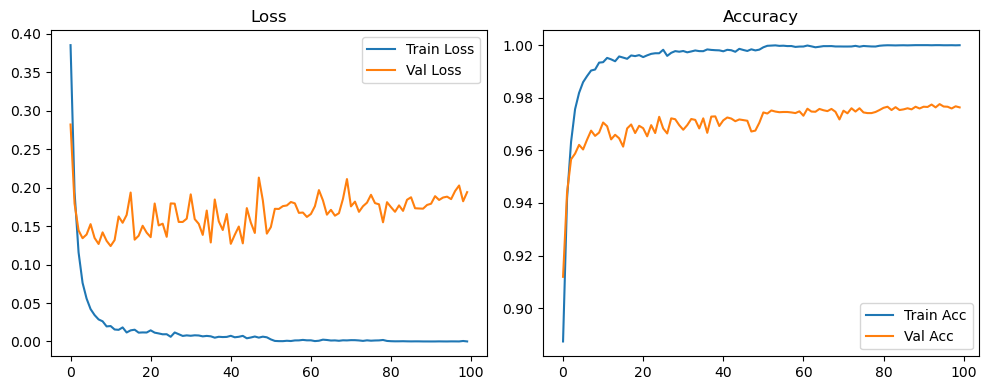

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4901, Acc: 0.8508 | Val Loss: 0.2810, Acc: 0.9157


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2769, Acc: 0.9168 | Val Loss: 0.2185, Acc: 0.9333


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1985, Acc: 0.9399 | Val Loss: 0.1849, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9543 | Val Loss: 0.1343, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9597 | Val Loss: 0.1292, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9675 | Val Loss: 0.1183, Acc: 0.9660


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9711 | Val Loss: 0.1171, Acc: 0.9668


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9742 | Val Loss: 0.1180, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9770 | Val Loss: 0.1117, Acc: 0.9684


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9787 | Val Loss: 0.1068, Acc: 0.9709


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9826 | Val Loss: 0.1059, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9847 | Val Loss: 0.1094, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.1167, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9859 | Val Loss: 0.1126, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0986, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.1058, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1186, Acc: 0.9722


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.1070, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.1054, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9892 | Val Loss: 0.1090, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1190, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1120, Acc: 0.9733


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1096, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9910 | Val Loss: 0.1099, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.1091, Acc: 0.9737


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1143, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.1258, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9921 | Val Loss: 0.1151, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1102, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1242, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1200, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1151, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1095, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1113, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1182, Acc: 0.9739


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1206, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1255, Acc: 0.9752


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1193, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1093, Acc: 0.9770


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1224, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1267, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1135, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1172, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1098, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1262, Acc: 0.9750


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1199, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1246, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1276, Acc: 0.9743


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1114, Acc: 0.9761


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1215, Acc: 0.9775


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1183, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1294, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1253, Acc: 0.9783


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1287, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1305, Acc: 0.9777


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.1316, Acc: 0.9787


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1305, Acc: 0.9783


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1301, Acc: 0.9767


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1277, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1301, Acc: 0.9763


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1288, Acc: 0.9767


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1219, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1310, Acc: 0.9783


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1248, Acc: 0.9775


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1318, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1310, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1372, Acc: 0.9779


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1442, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1333, Acc: 0.9778


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1254, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1223, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1375, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1194, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1395, Acc: 0.9779


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1428, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1302, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1390, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1203, Acc: 0.9774


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1403, Acc: 0.9785


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1300, Acc: 0.9784


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1358, Acc: 0.9795


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1386, Acc: 0.9785


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1379, Acc: 0.9786


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1365, Acc: 0.9785


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1426, Acc: 0.9786


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1408, Acc: 0.9788


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1375, Acc: 0.9791


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1363, Acc: 0.9786


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1372, Acc: 0.9791


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1379, Acc: 0.9797


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1448, Acc: 0.9793


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1499, Acc: 0.9788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1442, Acc: 0.9797


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1395, Acc: 0.9792


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1422, Acc: 0.9795


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1504, Acc: 0.9784


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1487, Acc: 0.9791


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1509, Acc: 0.9792


Final Test Loss: 0.1443 Accuracy: 0.9814


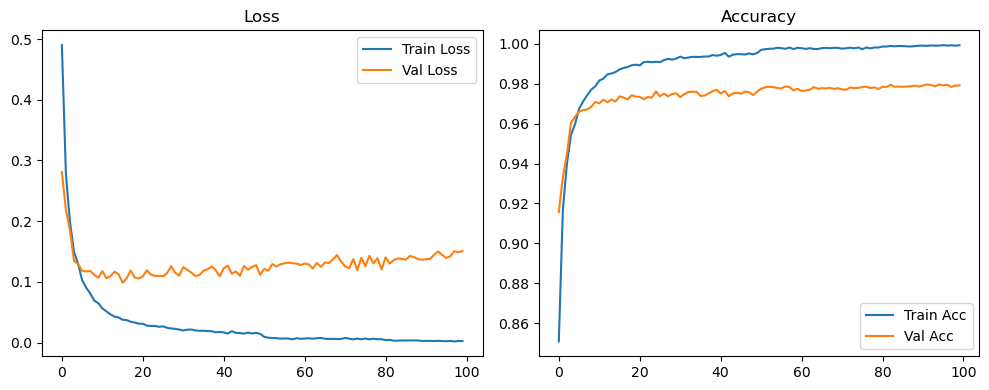

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7556, Acc: 0.7556 | Val Loss: 0.3281, Acc: 0.9027


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4313, Acc: 0.8692 | Val Loss: 0.2622, Acc: 0.9217


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3476, Acc: 0.8978 | Val Loss: 0.2311, Acc: 0.9323


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2849, Acc: 0.9163 | Val Loss: 0.1804, Acc: 0.9448


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2449, Acc: 0.9274 | Val Loss: 0.1625, Acc: 0.9512


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2166, Acc: 0.9359 | Val Loss: 0.1486, Acc: 0.9561


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1992, Acc: 0.9414 | Val Loss: 0.1428, Acc: 0.9582


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1824, Acc: 0.9452 | Val Loss: 0.1360, Acc: 0.9614


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1712, Acc: 0.9479 | Val Loss: 0.1283, Acc: 0.9627


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9524 | Val Loss: 0.1242, Acc: 0.9637


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1501, Acc: 0.9546 | Val Loss: 0.1214, Acc: 0.9649


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9565 | Val Loss: 0.1180, Acc: 0.9666


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9585 | Val Loss: 0.1122, Acc: 0.9662


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9600 | Val Loss: 0.1144, Acc: 0.9670


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9616 | Val Loss: 0.1108, Acc: 0.9698


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1224, Acc: 0.9626 | Val Loss: 0.1112, Acc: 0.9684


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9634 | Val Loss: 0.1033, Acc: 0.9700


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9652 | Val Loss: 0.1061, Acc: 0.9700


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9679 | Val Loss: 0.1057, Acc: 0.9686


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9682 | Val Loss: 0.1068, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9683 | Val Loss: 0.1035, Acc: 0.9715


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9687 | Val Loss: 0.1027, Acc: 0.9697


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9690 | Val Loss: 0.1027, Acc: 0.9706


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0997, Acc: 0.9706


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9717 | Val Loss: 0.1008, Acc: 0.9723


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9716 | Val Loss: 0.1020, Acc: 0.9724


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9734 | Val Loss: 0.1002, Acc: 0.9721


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9741 | Val Loss: 0.1044, Acc: 0.9728


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9753 | Val Loss: 0.1050, Acc: 0.9720


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9755 | Val Loss: 0.0977, Acc: 0.9743


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9757 | Val Loss: 0.0977, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9753 | Val Loss: 0.0984, Acc: 0.9726


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9760 | Val Loss: 0.0977, Acc: 0.9745


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9778 | Val Loss: 0.0996, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9771 | Val Loss: 0.1007, Acc: 0.9730


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9768 | Val Loss: 0.0973, Acc: 0.9736


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9770 | Val Loss: 0.0966, Acc: 0.9725


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0995, Acc: 0.9735


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9741


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9788 | Val Loss: 0.0946, Acc: 0.9753


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9784 | Val Loss: 0.0965, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.1009, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9804 | Val Loss: 0.0950, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9795 | Val Loss: 0.1013, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0967, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9794 | Val Loss: 0.0939, Acc: 0.9748


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9799 | Val Loss: 0.0975, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9819 | Val Loss: 0.1045, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9812 | Val Loss: 0.0997, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9809 | Val Loss: 0.0925, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9838 | Val Loss: 0.0979, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9847 | Val Loss: 0.0995, Acc: 0.9760


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.0955, Acc: 0.9763


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.0966, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 0.1005, Acc: 0.9761


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9863 | Val Loss: 0.0955, Acc: 0.9760


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9861 | Val Loss: 0.1053, Acc: 0.9757


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.1056, Acc: 0.9755


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1023, Acc: 0.9753


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 0.1017, Acc: 0.9746


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1137, Acc: 0.9738


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9869 | Val Loss: 0.1059, Acc: 0.9747


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9871 | Val Loss: 0.1025, Acc: 0.9759


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9882 | Val Loss: 0.1086, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.1128, Acc: 0.9755


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.0990, Acc: 0.9758


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.1064, Acc: 0.9744


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9871 | Val Loss: 0.0987, Acc: 0.9761


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9879 | Val Loss: 0.1098, Acc: 0.9751


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9881 | Val Loss: 0.1056, Acc: 0.9752


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.1046, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.1047, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 0.1085, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0984, Acc: 0.9754


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.1089, Acc: 0.9744


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.1069, Acc: 0.9754


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1029, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9885 | Val Loss: 0.1041, Acc: 0.9746


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.1041, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.1043, Acc: 0.9751


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1050, Acc: 0.9759


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 0.1035, Acc: 0.9763


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1082, Acc: 0.9751


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.1089, Acc: 0.9764


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.1083, Acc: 0.9756


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.1069, Acc: 0.9758


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.1081, Acc: 0.9762


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9907 | Val Loss: 0.1060, Acc: 0.9766


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1073, Acc: 0.9754


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.1054, Acc: 0.9763


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1036, Acc: 0.9758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.1065, Acc: 0.9762


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1092, Acc: 0.9764


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.1090, Acc: 0.9761


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1069, Acc: 0.9762


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.1079, Acc: 0.9758


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9910 | Val Loss: 0.1096, Acc: 0.9759


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.1120, Acc: 0.9753


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.1111, Acc: 0.9756


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1110, Acc: 0.9761


Final Test Loss: 0.0971 Accuracy: 0.9797


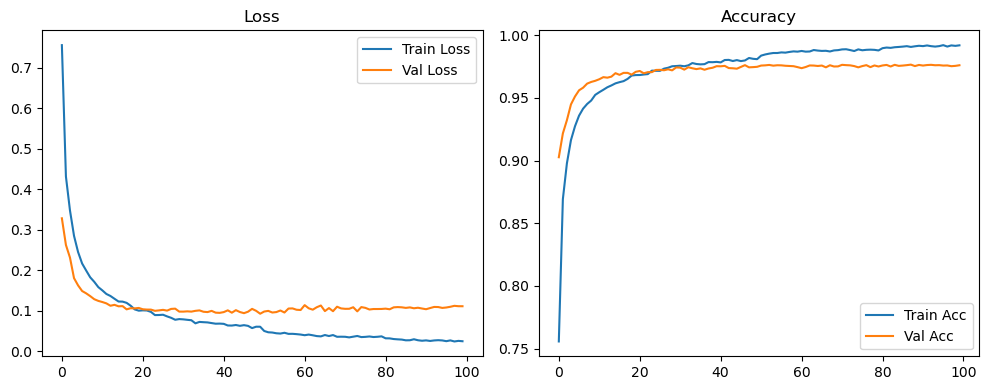

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3852, Acc: 0.8873 | Val Loss: 0.2820, Acc: 0.9119


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1941, Acc: 0.9417 | Val Loss: 0.1793, Acc: 0.9440


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1159, Acc: 0.9632 | Val Loss: 0.1444, Acc: 0.9566


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9756 | Val Loss: 0.1342, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9819 | Val Loss: 0.1390, Acc: 0.9621


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 0.1525, Acc: 0.9603


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9882 | Val Loss: 0.1346, Acc: 0.9641


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.1267, Acc: 0.9675


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9907 | Val Loss: 0.1418, Acc: 0.9655


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.1308, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.1241, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.1318, Acc: 0.9692


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.1625, Acc: 0.9642


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1543, Acc: 0.9659


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9957 | Val Loss: 0.1645, Acc: 0.9646


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1936, Acc: 0.9614


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1323, Acc: 0.9683


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1375, Acc: 0.9698


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1504, Acc: 0.9666


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1415, Acc: 0.9693


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1356, Acc: 0.9684


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1794, Acc: 0.9653


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1509, Acc: 0.9696


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1531, Acc: 0.9666


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1361, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1795, Acc: 0.9683


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1792, Acc: 0.9664


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1554, Acc: 0.9722


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1554, Acc: 0.9718


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1597, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1912, Acc: 0.9678


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1591, Acc: 0.9696


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1529, Acc: 0.9719


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1385, Acc: 0.9716


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1702, Acc: 0.9683


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1287, Acc: 0.9722


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1846, Acc: 0.9667


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1562, Acc: 0.9728


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1449, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1657, Acc: 0.9692


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9714


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1387, Acc: 0.9725


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1494, Acc: 0.9721


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1275, Acc: 0.9711


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1734, Acc: 0.9718


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1546, Acc: 0.9715


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1411, Acc: 0.9712


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2130, Acc: 0.9672


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1834, Acc: 0.9675


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1402, Acc: 0.9705


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1487, Acc: 0.9744


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1725, Acc: 0.9740


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1723, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1768, Acc: 0.9745


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1813, Acc: 0.9746


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1796, Acc: 0.9746


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1672, Acc: 0.9744


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1676, Acc: 0.9742


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1619, Acc: 0.9748


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1657, Acc: 0.9732


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1758, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9995 | Val Loss: 0.1968, Acc: 0.9748


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1835, Acc: 0.9747


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1649, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1712, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1635, Acc: 0.9749


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1668, Acc: 0.9758


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1853, Acc: 0.9747


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2112, Acc: 0.9718


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1756, Acc: 0.9751


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1818, Acc: 0.9741


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1685, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1758, Acc: 0.9748


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1805, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1907, Acc: 0.9744


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1799, Acc: 0.9742


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1783, Acc: 0.9742


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1549, Acc: 0.9746


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1811, Acc: 0.9753


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1775, Acc: 0.9761


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1700, Acc: 0.9761


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1740, Acc: 0.9757


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1709, Acc: 0.9753


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1768, Acc: 0.9759


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1818, Acc: 0.9759


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1755, Acc: 0.9760


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1819, Acc: 0.9756


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1821, Acc: 0.9754


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1828, Acc: 0.9752


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1882, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1853, Acc: 0.9767


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1885, Acc: 0.9768


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1884, Acc: 0.9760


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1924, Acc: 0.9761


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1943, Acc: 0.9752


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1957, Acc: 0.9764


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1986, Acc: 0.9755


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1995, Acc: 0.9752


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1984, Acc: 0.9754


Final Test Loss: 0.1901 Accuracy: 0.9790


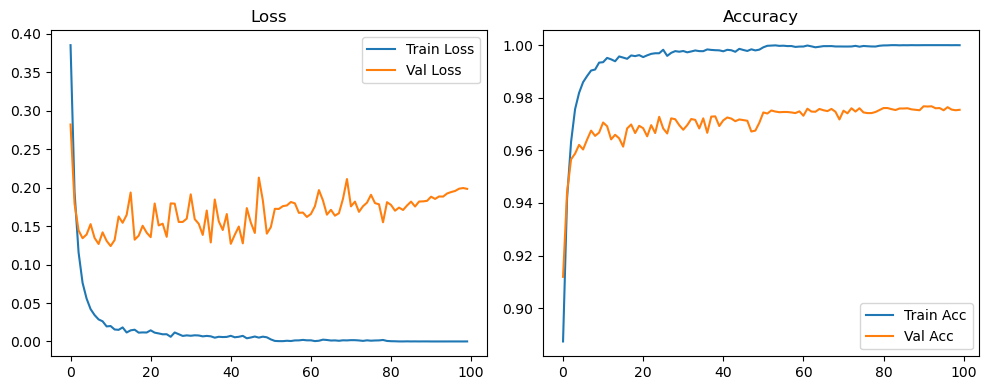

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4901, Acc: 0.8508 | Val Loss: 0.2810, Acc: 0.9157


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2769, Acc: 0.9168 | Val Loss: 0.2185, Acc: 0.9333


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1985, Acc: 0.9399 | Val Loss: 0.1849, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9543 | Val Loss: 0.1343, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9597 | Val Loss: 0.1292, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9675 | Val Loss: 0.1183, Acc: 0.9660


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9711 | Val Loss: 0.1171, Acc: 0.9668


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9742 | Val Loss: 0.1180, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9770 | Val Loss: 0.1117, Acc: 0.9684


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9787 | Val Loss: 0.1068, Acc: 0.9709


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9826 | Val Loss: 0.1059, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9847 | Val Loss: 0.1094, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.1167, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9859 | Val Loss: 0.1126, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0986, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.1058, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1186, Acc: 0.9722


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.1070, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.1054, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9892 | Val Loss: 0.1090, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1190, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1120, Acc: 0.9733


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1096, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9910 | Val Loss: 0.1099, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.1091, Acc: 0.9737


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1143, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.1258, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9921 | Val Loss: 0.1151, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1102, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1242, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1200, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1151, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1095, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1113, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1182, Acc: 0.9739


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1206, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1255, Acc: 0.9752


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1193, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1093, Acc: 0.9770


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1224, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1267, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1135, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1172, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1098, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1262, Acc: 0.9750


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1199, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1246, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1276, Acc: 0.9743


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1114, Acc: 0.9761


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1215, Acc: 0.9775


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1183, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1294, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1253, Acc: 0.9783


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1287, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1305, Acc: 0.9777


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.1316, Acc: 0.9787


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1305, Acc: 0.9783


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1301, Acc: 0.9767


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1277, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1301, Acc: 0.9763


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1288, Acc: 0.9767


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1219, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1310, Acc: 0.9783


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1248, Acc: 0.9775


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1318, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1310, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1372, Acc: 0.9779


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1442, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1333, Acc: 0.9778


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1254, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1223, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1375, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1194, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1395, Acc: 0.9779


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1428, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1302, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1390, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1203, Acc: 0.9774


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.1316, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1309, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1366, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1353, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1360, Acc: 0.9784


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1341, Acc: 0.9789


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1435, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1378, Acc: 0.9786


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1400, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1379, Acc: 0.9795


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1341, Acc: 0.9797


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1369, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1434, Acc: 0.9793


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1507, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1494, Acc: 0.9786


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1446, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1457, Acc: 0.9795


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1494, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1493, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1506, Acc: 0.9791


Final Test Loss: 0.1401 Accuracy: 0.9812


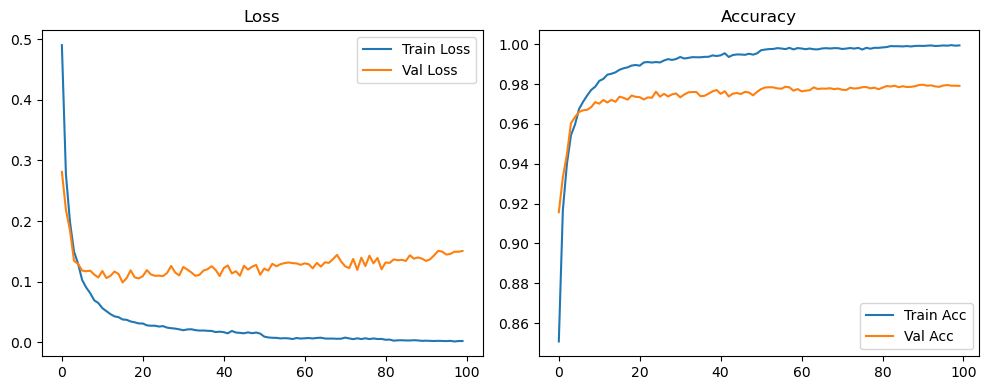

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7556, Acc: 0.7556 | Val Loss: 0.3281, Acc: 0.9027


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4312, Acc: 0.8690 | Val Loss: 0.2657, Acc: 0.9213


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3474, Acc: 0.8972 | Val Loss: 0.2312, Acc: 0.9324


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2847, Acc: 0.9157 | Val Loss: 0.1804, Acc: 0.9458


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2461, Acc: 0.9270 | Val Loss: 0.1611, Acc: 0.9514


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2170, Acc: 0.9352 | Val Loss: 0.1482, Acc: 0.9571


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2003, Acc: 0.9410 | Val Loss: 0.1430, Acc: 0.9579


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1824, Acc: 0.9454 | Val Loss: 0.1358, Acc: 0.9609


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1718, Acc: 0.9487 | Val Loss: 0.1282, Acc: 0.9637


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1585, Acc: 0.9523 | Val Loss: 0.1228, Acc: 0.9636


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1522, Acc: 0.9539 | Val Loss: 0.1205, Acc: 0.9647


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1403, Acc: 0.9575 | Val Loss: 0.1141, Acc: 0.9660


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1374, Acc: 0.9582 | Val Loss: 0.1111, Acc: 0.9667


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1300, Acc: 0.9601 | Val Loss: 0.1134, Acc: 0.9675


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9610 | Val Loss: 0.1122, Acc: 0.9687


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1204, Acc: 0.9627 | Val Loss: 0.1124, Acc: 0.9680


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9640 | Val Loss: 0.1032, Acc: 0.9713


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1129, Acc: 0.9654 | Val Loss: 0.1060, Acc: 0.9694


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1051, Acc: 0.9683 | Val Loss: 0.1045, Acc: 0.9693


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1006, Acc: 0.9680 | Val Loss: 0.1076, Acc: 0.9713


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1006, Acc: 0.9682 | Val Loss: 0.1054, Acc: 0.9714


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9665 | Val Loss: 0.1020, Acc: 0.9697


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9695 | Val Loss: 0.1025, Acc: 0.9702


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9714 | Val Loss: 0.0983, Acc: 0.9709


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0914, Acc: 0.9706 | Val Loss: 0.1077, Acc: 0.9718


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9721 | Val Loss: 0.1020, Acc: 0.9719


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9734 | Val Loss: 0.1021, Acc: 0.9722


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0807, Acc: 0.9747 | Val Loss: 0.1020, Acc: 0.9716


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9744 | Val Loss: 0.1050, Acc: 0.9715


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9754 | Val Loss: 0.1019, Acc: 0.9723


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9749 | Val Loss: 0.0953, Acc: 0.9739


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9758 | Val Loss: 0.0980, Acc: 0.9730


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9765 | Val Loss: 0.0981, Acc: 0.9728


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9772 | Val Loss: 0.1022, Acc: 0.9730


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9774 | Val Loss: 0.1015, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9770 | Val Loss: 0.0996, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9767 | Val Loss: 0.0988, Acc: 0.9729


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9785 | Val Loss: 0.1000, Acc: 0.9742


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9786 | Val Loss: 0.1008, Acc: 0.9734


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9788 | Val Loss: 0.0981, Acc: 0.9752


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9777 | Val Loss: 0.1085, Acc: 0.9728


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9790 | Val Loss: 0.1051, Acc: 0.9729


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9794 | Val Loss: 0.0980, Acc: 0.9730


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9793 | Val Loss: 0.1006, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9791 | Val Loss: 0.0945, Acc: 0.9741


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9805 | Val Loss: 0.0978, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9792 | Val Loss: 0.0984, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9811 | Val Loss: 0.1041, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9804 | Val Loss: 0.1026, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9811 | Val Loss: 0.0980, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9829 | Val Loss: 0.0972, Acc: 0.9757


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.0973, Acc: 0.9767


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9852 | Val Loss: 0.0947, Acc: 0.9758


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.0985, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9855 | Val Loss: 0.1005, Acc: 0.9759


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1020, Acc: 0.9749


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9861 | Val Loss: 0.1028, Acc: 0.9759


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.1035, Acc: 0.9758


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9877 | Val Loss: 0.0998, Acc: 0.9758


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.1020, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.1035, Acc: 0.9757


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9870 | Val Loss: 0.1015, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9872 | Val Loss: 0.1007, Acc: 0.9757


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.1036, Acc: 0.9756


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.1077, Acc: 0.9752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.1014, Acc: 0.9757


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.1059, Acc: 0.9756


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.1000, Acc: 0.9759


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1087, Acc: 0.9751


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.1050, Acc: 0.9758


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.1022, Acc: 0.9758


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.1090, Acc: 0.9752


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1053, Acc: 0.9758


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.1049, Acc: 0.9752


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.1073, Acc: 0.9761


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1056, Acc: 0.9756


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.1082, Acc: 0.9753


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.1041, Acc: 0.9760


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.1015, Acc: 0.9753


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.1036, Acc: 0.9747


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9893 | Val Loss: 0.1099, Acc: 0.9752


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.1119, Acc: 0.9755


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9900 | Val Loss: 0.1117, Acc: 0.9758


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.1081, Acc: 0.9760


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.1093, Acc: 0.9756


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.1116, Acc: 0.9756


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1094, Acc: 0.9762


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.1079, Acc: 0.9759


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.1120, Acc: 0.9758


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.1088, Acc: 0.9759


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.1096, Acc: 0.9756


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.1105, Acc: 0.9761


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1125, Acc: 0.9755


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1100, Acc: 0.9764


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.1055, Acc: 0.9761


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.1103, Acc: 0.9765


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.1094, Acc: 0.9767


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.1094, Acc: 0.9756


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.1102, Acc: 0.9760


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1113, Acc: 0.9759


Final Test Loss: 0.0943 Accuracy: 0.9812


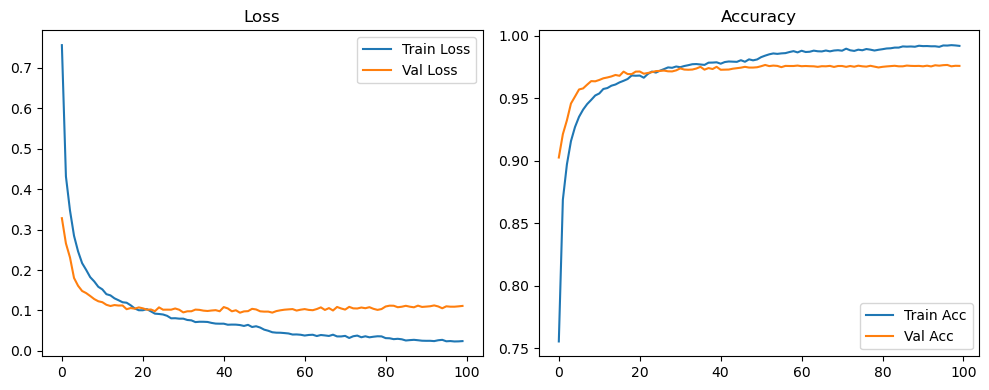

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3860, Acc: 0.8869 | Val Loss: 0.3049, Acc: 0.9059


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1944, Acc: 0.9410 | Val Loss: 0.1803, Acc: 0.9442


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9642 | Val Loss: 0.1385, Acc: 0.9590


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9759 | Val Loss: 0.1485, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9815 | Val Loss: 0.1281, Acc: 0.9636


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9855 | Val Loss: 0.1303, Acc: 0.9660


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9890 | Val Loss: 0.1285, Acc: 0.9671


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.1172, Acc: 0.9686


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.1346, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.1380, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.1484, Acc: 0.9683


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9937 | Val Loss: 0.1517, Acc: 0.9653


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9952 | Val Loss: 0.1505, Acc: 0.9683


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.1431, Acc: 0.9700


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1385, Acc: 0.9697


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1659, Acc: 0.9644


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1441, Acc: 0.9710


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1427, Acc: 0.9706


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1366, Acc: 0.9712


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1579, Acc: 0.9687


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1444, Acc: 0.9716


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1451, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1700, Acc: 0.9663


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1503, Acc: 0.9697


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1639, Acc: 0.9718


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1704, Acc: 0.9684


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1538, Acc: 0.9692


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1599, Acc: 0.9687


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.2037, Acc: 0.9660


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1732, Acc: 0.9699


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1675, Acc: 0.9697


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1657, Acc: 0.9713


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1583, Acc: 0.9728


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1528, Acc: 0.9703


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1452, Acc: 0.9704


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1470, Acc: 0.9737


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1368, Acc: 0.9737


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1417, Acc: 0.9717


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1621, Acc: 0.9722


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1500, Acc: 0.9726


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1794, Acc: 0.9701


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1596, Acc: 0.9718


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1757, Acc: 0.9709


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1507, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1513, Acc: 0.9739


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1546, Acc: 0.9722


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1462, Acc: 0.9721


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1498, Acc: 0.9734


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1769, Acc: 0.9720


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1759, Acc: 0.9699


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1346, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1441, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1446, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1525, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1521, Acc: 0.9774


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1527, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1539, Acc: 0.9780


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1565, Acc: 0.9780


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1597, Acc: 0.9776


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1627, Acc: 0.9775


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1650, Acc: 0.9771


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1738, Acc: 0.9764


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1681, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1715, Acc: 0.9776


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1748, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1731, Acc: 0.9761


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1722, Acc: 0.9764


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1796, Acc: 0.9758


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1777, Acc: 0.9763


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1774, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1773, Acc: 0.9774


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1819, Acc: 0.9767


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1802, Acc: 0.9769


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1831, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1853, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1678, Acc: 0.9765


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1666, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1792, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1858, Acc: 0.9767


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1824, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1806, Acc: 0.9771


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1833, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1848, Acc: 0.9766


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1877, Acc: 0.9766


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1852, Acc: 0.9771


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1868, Acc: 0.9769


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1901, Acc: 0.9769


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1902, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1976, Acc: 0.9768


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1936, Acc: 0.9774


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1959, Acc: 0.9772


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1954, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1998, Acc: 0.9780


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1978, Acc: 0.9776


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1997, Acc: 0.9778


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2028, Acc: 0.9773


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2056, Acc: 0.9781


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1992, Acc: 0.9780


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2015, Acc: 0.9771


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2071, Acc: 0.9768


Final Test Loss: 0.1849 Accuracy: 0.9794


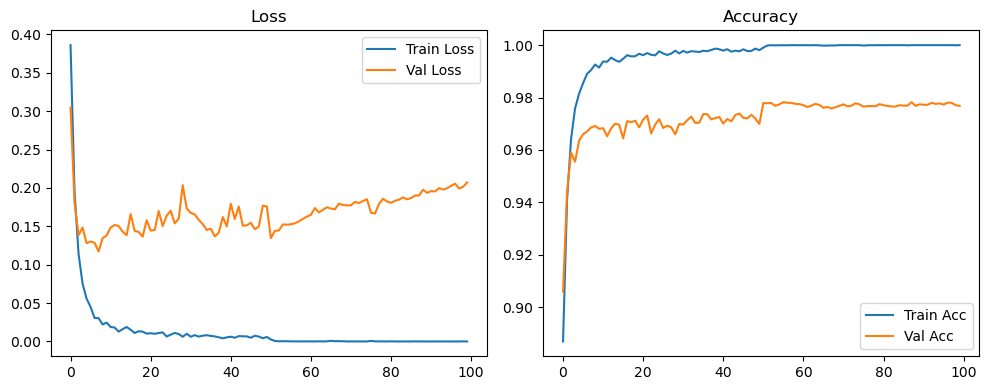

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4901, Acc: 0.8508 | Val Loss: 0.2810, Acc: 0.9157


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2769, Acc: 0.9168 | Val Loss: 0.2185, Acc: 0.9333


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1985, Acc: 0.9399 | Val Loss: 0.1849, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9543 | Val Loss: 0.1343, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9597 | Val Loss: 0.1292, Acc: 0.9634


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9675 | Val Loss: 0.1183, Acc: 0.9660


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9711 | Val Loss: 0.1171, Acc: 0.9668


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9742 | Val Loss: 0.1180, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9770 | Val Loss: 0.1117, Acc: 0.9684


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9787 | Val Loss: 0.1068, Acc: 0.9709


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9826 | Val Loss: 0.1059, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9847 | Val Loss: 0.1094, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9852 | Val Loss: 0.1167, Acc: 0.9721


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9859 | Val Loss: 0.1126, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0986, Acc: 0.9737


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.1058, Acc: 0.9731


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1186, Acc: 0.9722


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.1070, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.1054, Acc: 0.9736


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9892 | Val Loss: 0.1090, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1190, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1120, Acc: 0.9733


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1096, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9910 | Val Loss: 0.1099, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.1091, Acc: 0.9737


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1143, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.1258, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9921 | Val Loss: 0.1151, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1102, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1242, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1200, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1151, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1095, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1113, Acc: 0.9760


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1182, Acc: 0.9739


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1206, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1255, Acc: 0.9752


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1193, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1093, Acc: 0.9770


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1224, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1267, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1135, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1172, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1098, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1262, Acc: 0.9750


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1199, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1246, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1276, Acc: 0.9743


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1114, Acc: 0.9761


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1182, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1232, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1256, Acc: 0.9788


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1275, Acc: 0.9782


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1242, Acc: 0.9789


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1246, Acc: 0.9785


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1291, Acc: 0.9795


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1272, Acc: 0.9792


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1295, Acc: 0.9788


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1330, Acc: 0.9784


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1283, Acc: 0.9784


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1335, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1269, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1296, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1350, Acc: 0.9789


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1352, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.1422, Acc: 0.9778


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1427, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1387, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1421, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1425, Acc: 0.9787


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1392, Acc: 0.9784


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1389, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1438, Acc: 0.9780


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1420, Acc: 0.9792


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1364, Acc: 0.9795


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1407, Acc: 0.9785


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1421, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1406, Acc: 0.9791


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1405, Acc: 0.9789


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1418, Acc: 0.9789


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1437, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1482, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1431, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1369, Acc: 0.9789


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1420, Acc: 0.9786


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1475, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1458, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1449, Acc: 0.9784


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1428, Acc: 0.9785


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1391, Acc: 0.9790


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1424, Acc: 0.9790


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1483, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1552, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1490, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1439, Acc: 0.9787


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1466, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1513, Acc: 0.9790


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1456, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1476, Acc: 0.9788


Final Test Loss: 0.1313 Accuracy: 0.9813


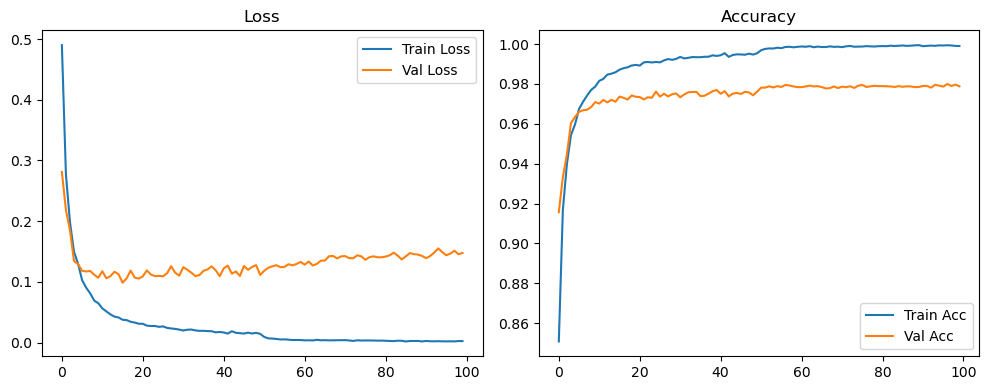

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7556, Acc: 0.7556 | Val Loss: 0.3281, Acc: 0.9027


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4313, Acc: 0.8692 | Val Loss: 0.2622, Acc: 0.9217


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3476, Acc: 0.8978 | Val Loss: 0.2311, Acc: 0.9323


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2849, Acc: 0.9163 | Val Loss: 0.1804, Acc: 0.9448


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2449, Acc: 0.9274 | Val Loss: 0.1625, Acc: 0.9512


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2166, Acc: 0.9359 | Val Loss: 0.1486, Acc: 0.9561


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1992, Acc: 0.9414 | Val Loss: 0.1428, Acc: 0.9582


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1824, Acc: 0.9452 | Val Loss: 0.1360, Acc: 0.9614


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1712, Acc: 0.9479 | Val Loss: 0.1283, Acc: 0.9627


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9524 | Val Loss: 0.1242, Acc: 0.9637


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1501, Acc: 0.9546 | Val Loss: 0.1214, Acc: 0.9649


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9565 | Val Loss: 0.1180, Acc: 0.9666


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9585 | Val Loss: 0.1122, Acc: 0.9662


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9600 | Val Loss: 0.1144, Acc: 0.9670


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9616 | Val Loss: 0.1108, Acc: 0.9698


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1224, Acc: 0.9626 | Val Loss: 0.1112, Acc: 0.9684


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9634 | Val Loss: 0.1033, Acc: 0.9700


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9652 | Val Loss: 0.1061, Acc: 0.9700


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9679 | Val Loss: 0.1057, Acc: 0.9686


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9682 | Val Loss: 0.1068, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9683 | Val Loss: 0.1035, Acc: 0.9715


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9687 | Val Loss: 0.1027, Acc: 0.9697


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9690 | Val Loss: 0.1027, Acc: 0.9706


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0997, Acc: 0.9706


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9717 | Val Loss: 0.1008, Acc: 0.9723


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9716 | Val Loss: 0.1020, Acc: 0.9724


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9734 | Val Loss: 0.1002, Acc: 0.9721


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9741 | Val Loss: 0.1044, Acc: 0.9728


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9753 | Val Loss: 0.1050, Acc: 0.9720


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9755 | Val Loss: 0.0977, Acc: 0.9743


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9757 | Val Loss: 0.0977, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9753 | Val Loss: 0.0984, Acc: 0.9726


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9760 | Val Loss: 0.0977, Acc: 0.9745


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9778 | Val Loss: 0.0996, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9771 | Val Loss: 0.1007, Acc: 0.9730


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9768 | Val Loss: 0.0973, Acc: 0.9736


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9770 | Val Loss: 0.0966, Acc: 0.9725


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0995, Acc: 0.9735


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9741


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9788 | Val Loss: 0.0946, Acc: 0.9753


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9784 | Val Loss: 0.0965, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.1009, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9804 | Val Loss: 0.0950, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9795 | Val Loss: 0.1013, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0967, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9794 | Val Loss: 0.0939, Acc: 0.9748


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9799 | Val Loss: 0.0975, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9819 | Val Loss: 0.1045, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9812 | Val Loss: 0.0997, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9809 | Val Loss: 0.0925, Acc: 0.9748


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.0966, Acc: 0.9756


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9851 | Val Loss: 0.0979, Acc: 0.9751


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9856 | Val Loss: 0.0970, Acc: 0.9767


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 0.0973, Acc: 0.9759


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.0974, Acc: 0.9762


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9872 | Val Loss: 0.0933, Acc: 0.9772


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.0978, Acc: 0.9769


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1007, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9880 | Val Loss: 0.0998, Acc: 0.9761


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0973, Acc: 0.9761


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.1021, Acc: 0.9766


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9883 | Val Loss: 0.0994, Acc: 0.9761


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.0992, Acc: 0.9765


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.1036, Acc: 0.9764


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9889 | Val Loss: 0.1084, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1020, Acc: 0.9763


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9898 | Val Loss: 0.1060, Acc: 0.9766


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.1008, Acc: 0.9762


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9891 | Val Loss: 0.1051, Acc: 0.9761


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.1046, Acc: 0.9763


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.1072, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.1024, Acc: 0.9756


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.1014, Acc: 0.9762


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.1018, Acc: 0.9764


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9767


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.1021, Acc: 0.9766


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9895 | Val Loss: 0.1009, Acc: 0.9769


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9897 | Val Loss: 0.1056, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.1038, Acc: 0.9759


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9891 | Val Loss: 0.1035, Acc: 0.9755


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1021, Acc: 0.9767


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.1038, Acc: 0.9767


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1057, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.1063, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.1047, Acc: 0.9766


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.1064, Acc: 0.9764


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.1045, Acc: 0.9761


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9910 | Val Loss: 0.1027, Acc: 0.9763


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1067, Acc: 0.9763


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.1025, Acc: 0.9767


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1048, Acc: 0.9766


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.1053, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.1065, Acc: 0.9766


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1060, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.1050, Acc: 0.9761


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.1072, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1071, Acc: 0.9765


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.1072, Acc: 0.9764


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1097, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.1075, Acc: 0.9758


Final Test Loss: 0.0939 Accuracy: 0.9796


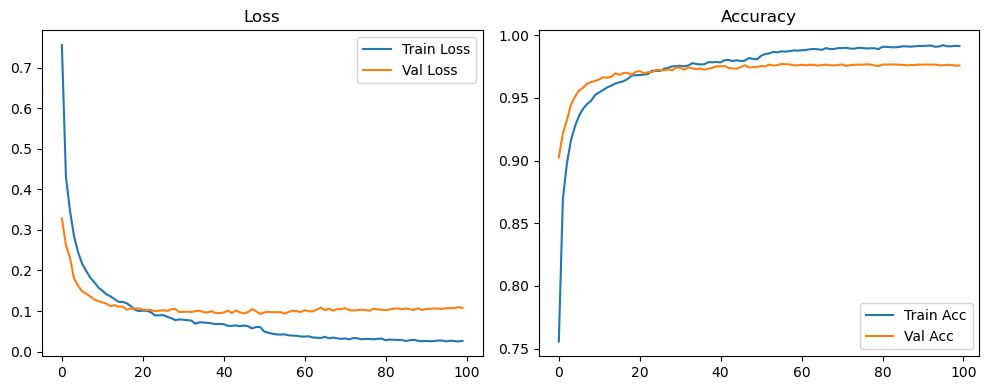

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4056, Acc: 0.8896 | Val Loss: 0.2914, Acc: 0.9119


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2123, Acc: 0.9357 | Val Loss: 0.1942, Acc: 0.9395


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1214, Acc: 0.9619 | Val Loss: 0.1484, Acc: 0.9541


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9756 | Val Loss: 0.1292, Acc: 0.9590


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9833 | Val Loss: 0.1400, Acc: 0.9606


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.1145, Acc: 0.9675


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.1654, Acc: 0.9558


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.1352, Acc: 0.9643


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1183, Acc: 0.9697


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1225, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1361, Acc: 0.9636


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1152, Acc: 0.9710


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9953 | Val Loss: 0.1362, Acc: 0.9674


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1239, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1377, Acc: 0.9705


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1308, Acc: 0.9706


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1267, Acc: 0.9717


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1516, Acc: 0.9684


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1458, Acc: 0.9703


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1476, Acc: 0.9689


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1343, Acc: 0.9756


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1798, Acc: 0.9639


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1415, Acc: 0.9697


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1365, Acc: 0.9733


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1411, Acc: 0.9728


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1672, Acc: 0.9673


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1448, Acc: 0.9733


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1496, Acc: 0.9709


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1466, Acc: 0.9731


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1551, Acc: 0.9709


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1537, Acc: 0.9710


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1660, Acc: 0.9702


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1658, Acc: 0.9704


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1728, Acc: 0.9712


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1493, Acc: 0.9742


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1925, Acc: 0.9683


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9712


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1863, Acc: 0.9657


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1397, Acc: 0.9747


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1490, Acc: 0.9731


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1492, Acc: 0.9734


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1503, Acc: 0.9747


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1516, Acc: 0.9739


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1838, Acc: 0.9690


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1585, Acc: 0.9716


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1592, Acc: 0.9705


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1464, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1527, Acc: 0.9742


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1489, Acc: 0.9734


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1664, Acc: 0.9722


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1449, Acc: 0.9745


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1590, Acc: 0.9740


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1606, Acc: 0.9725


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1744, Acc: 0.9711


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1654, Acc: 0.9688


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1729, Acc: 0.9690


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1559, Acc: 0.9732


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1533, Acc: 0.9750


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1826, Acc: 0.9730


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1966, Acc: 0.9688


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1509, Acc: 0.9737


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1736, Acc: 0.9737


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1689, Acc: 0.9749


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1856, Acc: 0.9728


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1542, Acc: 0.9753


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1749, Acc: 0.9740


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1417, Acc: 0.9748


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1599, Acc: 0.9738


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1815, Acc: 0.9738


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1737, Acc: 0.9712


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1679, Acc: 0.9732


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1726, Acc: 0.9738


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1688, Acc: 0.9756


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2255, Acc: 0.9694


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1707, Acc: 0.9744


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1573, Acc: 0.9758


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1703, Acc: 0.9755


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1942, Acc: 0.9735


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1706, Acc: 0.9733


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1698, Acc: 0.9742


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1557, Acc: 0.9738


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1935, Acc: 0.9707


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1659, Acc: 0.9758


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1561, Acc: 0.9758


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1633, Acc: 0.9750


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1639, Acc: 0.9748


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1634, Acc: 0.9732


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1829, Acc: 0.9747


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1567, Acc: 0.9741


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1673, Acc: 0.9745


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1831, Acc: 0.9742


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1752, Acc: 0.9735


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1585, Acc: 0.9743


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1670, Acc: 0.9746


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1791, Acc: 0.9713


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2144, Acc: 0.9713


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1591, Acc: 0.9751


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1604, Acc: 0.9739


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1525, Acc: 0.9755


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2384, Acc: 0.9698


Final Test Loss: 0.2005 Accuracy: 0.9696


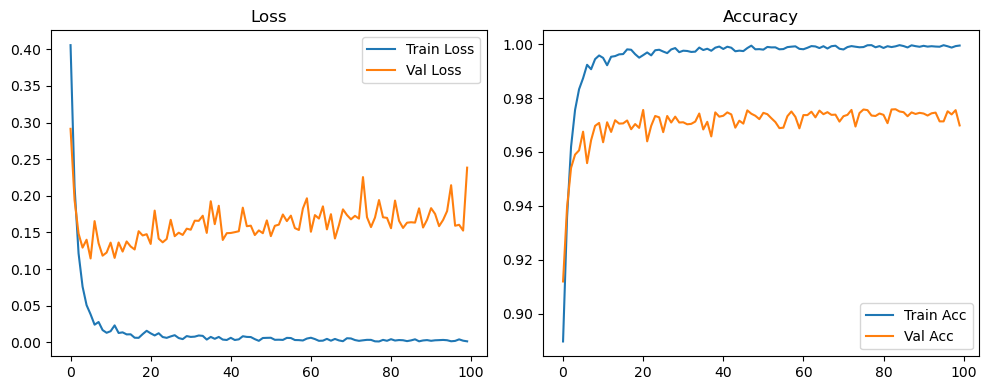

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5307, Acc: 0.8471 | Val Loss: 0.3058, Acc: 0.9073


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3118, Acc: 0.9061 | Val Loss: 0.2420, Acc: 0.9267


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2388, Acc: 0.9281 | Val Loss: 0.2033, Acc: 0.9377


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1841, Acc: 0.9439 | Val Loss: 0.1568, Acc: 0.9520


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1565, Acc: 0.9515 | Val Loss: 0.1398, Acc: 0.9583


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1320, Acc: 0.9589 | Val Loss: 0.1309, Acc: 0.9608


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1156, Acc: 0.9640 | Val Loss: 0.1296, Acc: 0.9627


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1006, Acc: 0.9691 | Val Loss: 0.1315, Acc: 0.9619


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0855, Acc: 0.9723 | Val Loss: 0.1286, Acc: 0.9644


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9744 | Val Loss: 0.1222, Acc: 0.9663


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9770 | Val Loss: 0.1110, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9784 | Val Loss: 0.1210, Acc: 0.9682


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9813 | Val Loss: 0.1230, Acc: 0.9685


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1135, Acc: 0.9694


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9832 | Val Loss: 0.1158, Acc: 0.9685


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9844 | Val Loss: 0.1152, Acc: 0.9702


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9847 | Val Loss: 0.1169, Acc: 0.9713


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9858 | Val Loss: 0.1141, Acc: 0.9702


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.1148, Acc: 0.9712


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9867 | Val Loss: 0.1094, Acc: 0.9730


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.1136, Acc: 0.9737


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9881 | Val Loss: 0.1175, Acc: 0.9715


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9892 | Val Loss: 0.1104, Acc: 0.9737


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1090, Acc: 0.9731


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.1235, Acc: 0.9722


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.1111, Acc: 0.9741


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.1218, Acc: 0.9732


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9914 | Val Loss: 0.1299, Acc: 0.9720


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.1306, Acc: 0.9726


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.1199, Acc: 0.9734


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1195, Acc: 0.9732


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1313, Acc: 0.9723


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.1206, Acc: 0.9740


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.1252, Acc: 0.9737


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1189, Acc: 0.9742


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1224, Acc: 0.9734


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9918 | Val Loss: 0.1224, Acc: 0.9742


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.1228, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.1213, Acc: 0.9742


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1301, Acc: 0.9740


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.1391, Acc: 0.9749


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.1239, Acc: 0.9732


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.1240, Acc: 0.9749


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1204, Acc: 0.9752


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1281, Acc: 0.9747


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.1206, Acc: 0.9743


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1219, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1257, Acc: 0.9743


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.1223, Acc: 0.9750


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1326, Acc: 0.9746


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.1271, Acc: 0.9752


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1257, Acc: 0.9753


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1298, Acc: 0.9755


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1321, Acc: 0.9771


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1273, Acc: 0.9758


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1283, Acc: 0.9746


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1323, Acc: 0.9749


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1198, Acc: 0.9761


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9953 | Val Loss: 0.1354, Acc: 0.9750


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1223, Acc: 0.9739


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.1298, Acc: 0.9755


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1308, Acc: 0.9756


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1268, Acc: 0.9758


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.1276, Acc: 0.9762


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1440, Acc: 0.9759


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.1350, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1293, Acc: 0.9766


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1354, Acc: 0.9750


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.1238, Acc: 0.9765


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1263, Acc: 0.9766


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1339, Acc: 0.9760


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.1319, Acc: 0.9764


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1255, Acc: 0.9752


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1405, Acc: 0.9748


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1288, Acc: 0.9757


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1239, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1256, Acc: 0.9771


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1347, Acc: 0.9751


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1351, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1343, Acc: 0.9757


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1364, Acc: 0.9758


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1336, Acc: 0.9761


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1397, Acc: 0.9758


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1247, Acc: 0.9748


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1378, Acc: 0.9750


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.1346, Acc: 0.9746


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1348, Acc: 0.9751


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1366, Acc: 0.9761


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1187, Acc: 0.9769


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1217, Acc: 0.9777


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1294, Acc: 0.9751


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1327, Acc: 0.9752


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1333, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.1378, Acc: 0.9761


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1366, Acc: 0.9763


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1401, Acc: 0.9749


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1281, Acc: 0.9772


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1481, Acc: 0.9761


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1249, Acc: 0.9758


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1443, Acc: 0.9743


Final Test Loss: 0.1406 Accuracy: 0.9776


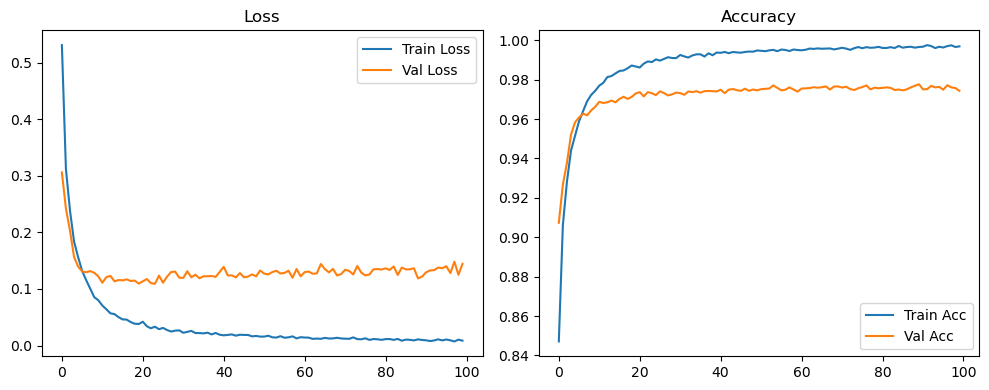

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.8481, Acc: 0.7299 | Val Loss: 0.3613, Acc: 0.8944


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4971, Acc: 0.8483 | Val Loss: 0.3002, Acc: 0.9119


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.4136, Acc: 0.8776 | Val Loss: 0.2659, Acc: 0.9226


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3477, Acc: 0.8959 | Val Loss: 0.2208, Acc: 0.9339


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.3056, Acc: 0.9095 | Val Loss: 0.1992, Acc: 0.9411


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2708, Acc: 0.9191 | Val Loss: 0.1778, Acc: 0.9479


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2471, Acc: 0.9262 | Val Loss: 0.1673, Acc: 0.9506


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2210, Acc: 0.9340 | Val Loss: 0.1570, Acc: 0.9544


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.2083, Acc: 0.9371 | Val Loss: 0.1505, Acc: 0.9558


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1916, Acc: 0.9430 | Val Loss: 0.1379, Acc: 0.9590


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1821, Acc: 0.9450 | Val Loss: 0.1394, Acc: 0.9597


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1716, Acc: 0.9494 | Val Loss: 0.1283, Acc: 0.9642


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1645, Acc: 0.9500 | Val Loss: 0.1272, Acc: 0.9620


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1584, Acc: 0.9511 | Val Loss: 0.1270, Acc: 0.9635


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1492, Acc: 0.9539 | Val Loss: 0.1182, Acc: 0.9658


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1431, Acc: 0.9553 | Val Loss: 0.1200, Acc: 0.9655


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1381, Acc: 0.9568 | Val Loss: 0.1143, Acc: 0.9673


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1301, Acc: 0.9598 | Val Loss: 0.1156, Acc: 0.9671


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1263, Acc: 0.9611 | Val Loss: 0.1168, Acc: 0.9677


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1213, Acc: 0.9621 | Val Loss: 0.1101, Acc: 0.9686


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1208, Acc: 0.9616 | Val Loss: 0.1093, Acc: 0.9692


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1171, Acc: 0.9643 | Val Loss: 0.1051, Acc: 0.9701


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9657 | Val Loss: 0.1037, Acc: 0.9709


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1059, Acc: 0.9666 | Val Loss: 0.1086, Acc: 0.9690


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1059, Acc: 0.9666 | Val Loss: 0.1083, Acc: 0.9708


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1097, Acc: 0.9657 | Val Loss: 0.1035, Acc: 0.9702


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1000, Acc: 0.9680 | Val Loss: 0.1081, Acc: 0.9696


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0929, Acc: 0.9712 | Val Loss: 0.1090, Acc: 0.9698


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0976, Acc: 0.9694 | Val Loss: 0.1078, Acc: 0.9700


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0929, Acc: 0.9710 | Val Loss: 0.1039, Acc: 0.9719


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9707 | Val Loss: 0.1012, Acc: 0.9720


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9720 | Val Loss: 0.1002, Acc: 0.9718


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9739 | Val Loss: 0.1010, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9739 | Val Loss: 0.1054, Acc: 0.9715


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0825, Acc: 0.9745 | Val Loss: 0.1042, Acc: 0.9712


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9742 | Val Loss: 0.1025, Acc: 0.9717


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9748 | Val Loss: 0.1023, Acc: 0.9714


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9741 | Val Loss: 0.1030, Acc: 0.9716


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9756 | Val Loss: 0.1038, Acc: 0.9727


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9765 | Val Loss: 0.1104, Acc: 0.9728


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.1015, Acc: 0.9728


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9766 | Val Loss: 0.1082, Acc: 0.9718


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9769 | Val Loss: 0.1034, Acc: 0.9723


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9776 | Val Loss: 0.1010, Acc: 0.9735


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9763 | Val Loss: 0.1007, Acc: 0.9732


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9771 | Val Loss: 0.1032, Acc: 0.9733


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9776 | Val Loss: 0.0998, Acc: 0.9740


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9776 | Val Loss: 0.1062, Acc: 0.9738


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9787 | Val Loss: 0.1020, Acc: 0.9737


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9790 | Val Loss: 0.1024, Acc: 0.9738


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9805 | Val Loss: 0.1010, Acc: 0.9748


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9783 | Val Loss: 0.1025, Acc: 0.9743


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9796 | Val Loss: 0.1011, Acc: 0.9738


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9805 | Val Loss: 0.1020, Acc: 0.9750


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9803 | Val Loss: 0.1046, Acc: 0.9746


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9799 | Val Loss: 0.0940, Acc: 0.9753


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9795 | Val Loss: 0.1003, Acc: 0.9747


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9812 | Val Loss: 0.0998, Acc: 0.9738


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9810 | Val Loss: 0.1058, Acc: 0.9732


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.0991, Acc: 0.9740


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9813 | Val Loss: 0.1029, Acc: 0.9742


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9809 | Val Loss: 0.1040, Acc: 0.9735


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9815 | Val Loss: 0.1001, Acc: 0.9752


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9820 | Val Loss: 0.1030, Acc: 0.9742


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9821 | Val Loss: 0.1064, Acc: 0.9742


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.1056, Acc: 0.9748


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9835 | Val Loss: 0.1013, Acc: 0.9745


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 0.1016, Acc: 0.9753


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9826 | Val Loss: 0.0984, Acc: 0.9756


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.1012, Acc: 0.9738


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9833 | Val Loss: 0.1079, Acc: 0.9748


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9838 | Val Loss: 0.1084, Acc: 0.9736


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9832 | Val Loss: 0.0985, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9832 | Val Loss: 0.1087, Acc: 0.9739


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.1053, Acc: 0.9750


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9844 | Val Loss: 0.1045, Acc: 0.9748


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.1036, Acc: 0.9751


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9846 | Val Loss: 0.1079, Acc: 0.9743


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9841 | Val Loss: 0.1056, Acc: 0.9743


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9834 | Val Loss: 0.1025, Acc: 0.9745


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9848 | Val Loss: 0.0997, Acc: 0.9764


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9844 | Val Loss: 0.1028, Acc: 0.9755


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9847 | Val Loss: 0.1004, Acc: 0.9754


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9847 | Val Loss: 0.0996, Acc: 0.9751


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9844 | Val Loss: 0.0986, Acc: 0.9751


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9859 | Val Loss: 0.1050, Acc: 0.9752


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9850 | Val Loss: 0.1076, Acc: 0.9737


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 0.1060, Acc: 0.9754


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9853 | Val Loss: 0.1005, Acc: 0.9748


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9859 | Val Loss: 0.1028, Acc: 0.9755


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9868 | Val Loss: 0.1067, Acc: 0.9758


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9867 | Val Loss: 0.1111, Acc: 0.9749


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.0995, Acc: 0.9762


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9858 | Val Loss: 0.0999, Acc: 0.9758


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.1031, Acc: 0.9751


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9866 | Val Loss: 0.1054, Acc: 0.9748


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9858 | Val Loss: 0.1020, Acc: 0.9755


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1064, Acc: 0.9752


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9867 | Val Loss: 0.1065, Acc: 0.9741


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1067, Acc: 0.9752


Final Test Loss: 0.0991 Accuracy: 0.9777


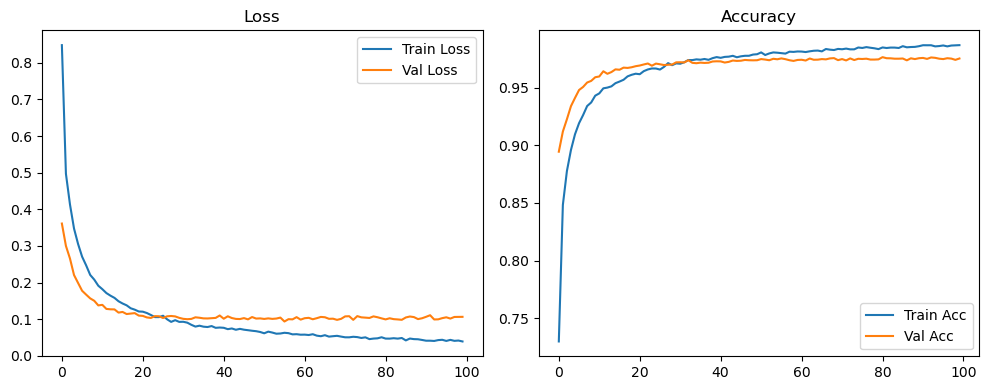

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4056, Acc: 0.8896 | Val Loss: 0.2914, Acc: 0.9119


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2123, Acc: 0.9357 | Val Loss: 0.1942, Acc: 0.9395


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1214, Acc: 0.9619 | Val Loss: 0.1484, Acc: 0.9541


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9756 | Val Loss: 0.1292, Acc: 0.9590


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9833 | Val Loss: 0.1400, Acc: 0.9606


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.1145, Acc: 0.9675


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.1654, Acc: 0.9558


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.1352, Acc: 0.9643


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1183, Acc: 0.9697


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1225, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1361, Acc: 0.9636


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1152, Acc: 0.9710


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9953 | Val Loss: 0.1362, Acc: 0.9674


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1239, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1377, Acc: 0.9705


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1308, Acc: 0.9706


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1267, Acc: 0.9717


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1516, Acc: 0.9684


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1458, Acc: 0.9703


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1476, Acc: 0.9689


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1343, Acc: 0.9756


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1798, Acc: 0.9639


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1415, Acc: 0.9697


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1365, Acc: 0.9733


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1411, Acc: 0.9728


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1672, Acc: 0.9673


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1448, Acc: 0.9733


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1496, Acc: 0.9709


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1466, Acc: 0.9731


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1551, Acc: 0.9709


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1537, Acc: 0.9710


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1660, Acc: 0.9702


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1658, Acc: 0.9704


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1728, Acc: 0.9712


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1493, Acc: 0.9742


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1925, Acc: 0.9683


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9712


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1863, Acc: 0.9657


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1397, Acc: 0.9747


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1490, Acc: 0.9731


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1492, Acc: 0.9734


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1503, Acc: 0.9747


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1516, Acc: 0.9739


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1838, Acc: 0.9690


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1585, Acc: 0.9716


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1592, Acc: 0.9705


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1464, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1527, Acc: 0.9742


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1489, Acc: 0.9734


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1664, Acc: 0.9722


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1395, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1414, Acc: 0.9774


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1474, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1471, Acc: 0.9777


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1477, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1473, Acc: 0.9783


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1496, Acc: 0.9785


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1528, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1478, Acc: 0.9782


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1527, Acc: 0.9783


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1514, Acc: 0.9783


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1525, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1498, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1473, Acc: 0.9779


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1496, Acc: 0.9780


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1510, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1505, Acc: 0.9789


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1524, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1631, Acc: 0.9789


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1579, Acc: 0.9752


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1702, Acc: 0.9751


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1553, Acc: 0.9766


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1710, Acc: 0.9759


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1696, Acc: 0.9749


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1626, Acc: 0.9758


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1599, Acc: 0.9765


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1563, Acc: 0.9784


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1550, Acc: 0.9774


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1511, Acc: 0.9779


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1565, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1556, Acc: 0.9785


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1534, Acc: 0.9787


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1578, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1557, Acc: 0.9791


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1580, Acc: 0.9790


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1551, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1529, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1554, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1608, Acc: 0.9787


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1611, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9782


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1647, Acc: 0.9784


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1660, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1565, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1608, Acc: 0.9790


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1662, Acc: 0.9784


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1743, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1694, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1722, Acc: 0.9781


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1693, Acc: 0.9791


Final Test Loss: 0.1722 Accuracy: 0.9781


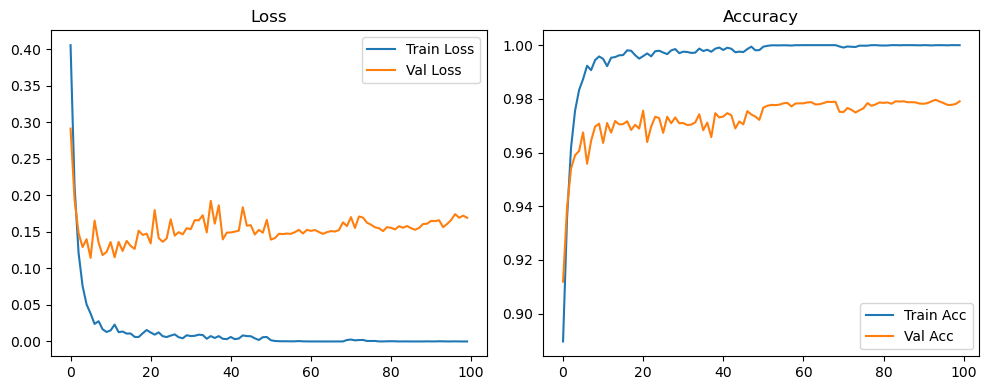

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5307, Acc: 0.8472 | Val Loss: 0.3060, Acc: 0.9079


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3121, Acc: 0.9057 | Val Loss: 0.2415, Acc: 0.9267


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2385, Acc: 0.9277 | Val Loss: 0.2029, Acc: 0.9388


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1851, Acc: 0.9437 | Val Loss: 0.1553, Acc: 0.9529


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1579, Acc: 0.9513 | Val Loss: 0.1434, Acc: 0.9578


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1330, Acc: 0.9586 | Val Loss: 0.1346, Acc: 0.9602


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1165, Acc: 0.9639 | Val Loss: 0.1311, Acc: 0.9609


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9688 | Val Loss: 0.1295, Acc: 0.9637


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0869, Acc: 0.9718 | Val Loss: 0.1276, Acc: 0.9647


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9735 | Val Loss: 0.1190, Acc: 0.9669


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9769 | Val Loss: 0.1156, Acc: 0.9677


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9780 | Val Loss: 0.1175, Acc: 0.9684


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9808 | Val Loss: 0.1187, Acc: 0.9681


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9814 | Val Loss: 0.1162, Acc: 0.9696


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9835 | Val Loss: 0.1106, Acc: 0.9695


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9845 | Val Loss: 0.1157, Acc: 0.9698


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9851 | Val Loss: 0.1120, Acc: 0.9722


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9861 | Val Loss: 0.1264, Acc: 0.9707


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9866 | Val Loss: 0.1170, Acc: 0.9715


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.1091, Acc: 0.9710


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9863 | Val Loss: 0.1162, Acc: 0.9718


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9880 | Val Loss: 0.1219, Acc: 0.9707


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.1121, Acc: 0.9731


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9884 | Val Loss: 0.1171, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9887 | Val Loss: 0.1295, Acc: 0.9711


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.1111, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.1267, Acc: 0.9719


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1247, Acc: 0.9718


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9904 | Val Loss: 0.1190, Acc: 0.9736


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.1193, Acc: 0.9722


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.1185, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9916 | Val Loss: 0.1305, Acc: 0.9724


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.1210, Acc: 0.9724


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9921 | Val Loss: 0.1182, Acc: 0.9735


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1158, Acc: 0.9743


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.1115, Acc: 0.9739


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.1281, Acc: 0.9733


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1257, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1272, Acc: 0.9747


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9931 | Val Loss: 0.1291, Acc: 0.9732


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.1245, Acc: 0.9747


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1281, Acc: 0.9725


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9928 | Val Loss: 0.1334, Acc: 0.9722


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1277, Acc: 0.9729


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1295, Acc: 0.9739


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1293, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.1235, Acc: 0.9747


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9938 | Val Loss: 0.1268, Acc: 0.9748


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1335, Acc: 0.9740


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1361, Acc: 0.9738


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1233, Acc: 0.9758


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1232, Acc: 0.9756


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.1301, Acc: 0.9758


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1306, Acc: 0.9765


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9788


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1346, Acc: 0.9776


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1333, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1369, Acc: 0.9764


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1347, Acc: 0.9764


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1340, Acc: 0.9771


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1380, Acc: 0.9760


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1416, Acc: 0.9758


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1336, Acc: 0.9761


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1419, Acc: 0.9761


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1457, Acc: 0.9758


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1396, Acc: 0.9756


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1412, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1453, Acc: 0.9763


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1529, Acc: 0.9756


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1461, Acc: 0.9766


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1529, Acc: 0.9758


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1489, Acc: 0.9762


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1349, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1366, Acc: 0.9766


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1344, Acc: 0.9767


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1391, Acc: 0.9762


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1449, Acc: 0.9762


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1421, Acc: 0.9759


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1416, Acc: 0.9767


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1409, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1453, Acc: 0.9756


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1411, Acc: 0.9773


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1414, Acc: 0.9760


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1440, Acc: 0.9773


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1457, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1476, Acc: 0.9767


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1457, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1446, Acc: 0.9773


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1447, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1508, Acc: 0.9758


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1485, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1494, Acc: 0.9771


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1500, Acc: 0.9767


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1507, Acc: 0.9767


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1483, Acc: 0.9776


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1495, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1504, Acc: 0.9771


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1506, Acc: 0.9778


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1569, Acc: 0.9768


Final Test Loss: 0.1435 Accuracy: 0.9788


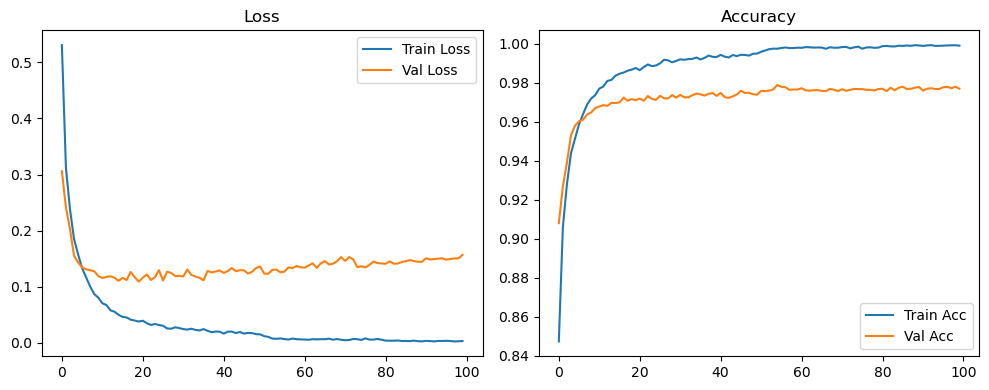

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.8481, Acc: 0.7299 | Val Loss: 0.3613, Acc: 0.8944


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4971, Acc: 0.8483 | Val Loss: 0.3002, Acc: 0.9119


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.4136, Acc: 0.8776 | Val Loss: 0.2659, Acc: 0.9226


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3477, Acc: 0.8959 | Val Loss: 0.2208, Acc: 0.9339


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.3056, Acc: 0.9095 | Val Loss: 0.1992, Acc: 0.9411


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2708, Acc: 0.9191 | Val Loss: 0.1778, Acc: 0.9479


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2471, Acc: 0.9262 | Val Loss: 0.1673, Acc: 0.9506


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2210, Acc: 0.9340 | Val Loss: 0.1570, Acc: 0.9544


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.2083, Acc: 0.9371 | Val Loss: 0.1505, Acc: 0.9558


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1916, Acc: 0.9430 | Val Loss: 0.1379, Acc: 0.9590


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1821, Acc: 0.9450 | Val Loss: 0.1394, Acc: 0.9597


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1716, Acc: 0.9494 | Val Loss: 0.1283, Acc: 0.9642


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1645, Acc: 0.9500 | Val Loss: 0.1272, Acc: 0.9620


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1584, Acc: 0.9511 | Val Loss: 0.1270, Acc: 0.9635


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1492, Acc: 0.9539 | Val Loss: 0.1182, Acc: 0.9658


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1431, Acc: 0.9553 | Val Loss: 0.1200, Acc: 0.9655


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1381, Acc: 0.9568 | Val Loss: 0.1143, Acc: 0.9673


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1301, Acc: 0.9598 | Val Loss: 0.1156, Acc: 0.9671


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1263, Acc: 0.9611 | Val Loss: 0.1168, Acc: 0.9677


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1213, Acc: 0.9621 | Val Loss: 0.1101, Acc: 0.9686


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1208, Acc: 0.9616 | Val Loss: 0.1093, Acc: 0.9692


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1171, Acc: 0.9643 | Val Loss: 0.1051, Acc: 0.9701


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9657 | Val Loss: 0.1037, Acc: 0.9709


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1059, Acc: 0.9666 | Val Loss: 0.1086, Acc: 0.9690


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1059, Acc: 0.9666 | Val Loss: 0.1083, Acc: 0.9708


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1097, Acc: 0.9657 | Val Loss: 0.1035, Acc: 0.9702


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1000, Acc: 0.9680 | Val Loss: 0.1081, Acc: 0.9696


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0929, Acc: 0.9712 | Val Loss: 0.1090, Acc: 0.9698


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0976, Acc: 0.9694 | Val Loss: 0.1078, Acc: 0.9700


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0929, Acc: 0.9710 | Val Loss: 0.1039, Acc: 0.9719


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9707 | Val Loss: 0.1012, Acc: 0.9720


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9720 | Val Loss: 0.1002, Acc: 0.9718


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9739 | Val Loss: 0.1010, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9739 | Val Loss: 0.1054, Acc: 0.9715


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0825, Acc: 0.9745 | Val Loss: 0.1042, Acc: 0.9712


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9742 | Val Loss: 0.1025, Acc: 0.9717


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9748 | Val Loss: 0.1023, Acc: 0.9714


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9741 | Val Loss: 0.1030, Acc: 0.9716


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9756 | Val Loss: 0.1038, Acc: 0.9727


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9765 | Val Loss: 0.1104, Acc: 0.9728


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.1015, Acc: 0.9728


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9766 | Val Loss: 0.1082, Acc: 0.9718


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9769 | Val Loss: 0.1034, Acc: 0.9723


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9776 | Val Loss: 0.1010, Acc: 0.9735


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9763 | Val Loss: 0.1007, Acc: 0.9732


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9771 | Val Loss: 0.1032, Acc: 0.9733


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9776 | Val Loss: 0.0998, Acc: 0.9740


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9776 | Val Loss: 0.1062, Acc: 0.9738


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9787 | Val Loss: 0.1020, Acc: 0.9737


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9790 | Val Loss: 0.1024, Acc: 0.9738


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9816 | Val Loss: 0.1032, Acc: 0.9751


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9823 | Val Loss: 0.1027, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9832 | Val Loss: 0.1025, Acc: 0.9752


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9843 | Val Loss: 0.1019, Acc: 0.9756


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9837 | Val Loss: 0.1021, Acc: 0.9762


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9834 | Val Loss: 0.0997, Acc: 0.9762


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9831 | Val Loss: 0.1006, Acc: 0.9745


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9840 | Val Loss: 0.1015, Acc: 0.9757


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9852 | Val Loss: 0.1012, Acc: 0.9755


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1022, Acc: 0.9751


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9844 | Val Loss: 0.1035, Acc: 0.9745


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9857 | Val Loss: 0.1083, Acc: 0.9741


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9852 | Val Loss: 0.1011, Acc: 0.9755


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.1052, Acc: 0.9755


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1037, Acc: 0.9752


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9855 | Val Loss: 0.1032, Acc: 0.9750


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9860 | Val Loss: 0.1051, Acc: 0.9753


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9860 | Val Loss: 0.1051, Acc: 0.9752


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9864 | Val Loss: 0.1036, Acc: 0.9757


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1070, Acc: 0.9746


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9866 | Val Loss: 0.1082, Acc: 0.9750


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.1091, Acc: 0.9746


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.1042, Acc: 0.9757


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9862 | Val Loss: 0.1118, Acc: 0.9750


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1087, Acc: 0.9753


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.1094, Acc: 0.9748


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.1081, Acc: 0.9747


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.1094, Acc: 0.9741


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9867 | Val Loss: 0.1050, Acc: 0.9750


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.1044, Acc: 0.9748


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9878 | Val Loss: 0.1054, Acc: 0.9755


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.1071, Acc: 0.9751


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.1091, Acc: 0.9755


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9879 | Val Loss: 0.1079, Acc: 0.9750


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.1078, Acc: 0.9741


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.1090, Acc: 0.9744


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1073, Acc: 0.9746


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.1073, Acc: 0.9749


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.1084, Acc: 0.9751


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.1093, Acc: 0.9754


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9905 | Val Loss: 0.1107, Acc: 0.9749


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.1115, Acc: 0.9748


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.1110, Acc: 0.9741


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1110, Acc: 0.9752


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.1104, Acc: 0.9738


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1136, Acc: 0.9743


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.1090, Acc: 0.9743


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1105, Acc: 0.9744


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.1116, Acc: 0.9748


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.1119, Acc: 0.9752


Final Test Loss: 0.1054 Accuracy: 0.9780


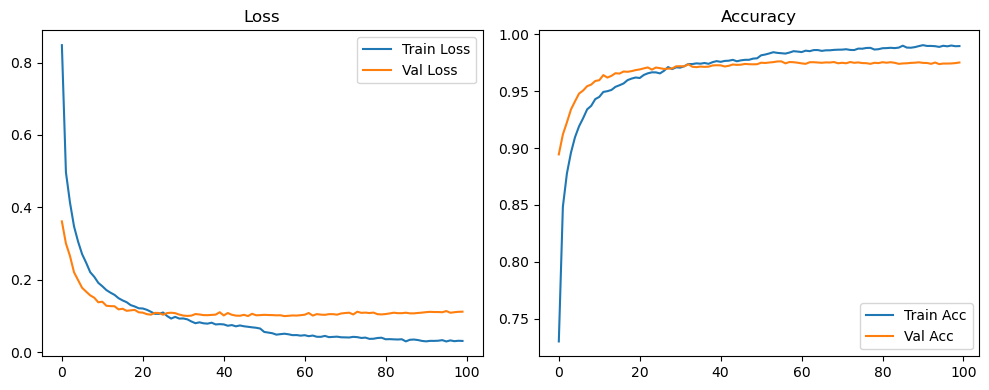

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4920, Acc: 0.8859 | Val Loss: 0.3069, Acc: 0.9079


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2386, Acc: 0.9313 | Val Loss: 0.2123, Acc: 0.9358


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1286, Acc: 0.9613 | Val Loss: 0.1609, Acc: 0.9500


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9770 | Val Loss: 0.1123, Acc: 0.9659


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9856 | Val Loss: 0.1306, Acc: 0.9607


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9906 | Val Loss: 0.1244, Acc: 0.9627


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9940 | Val Loss: 0.1060, Acc: 0.9698


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.1207, Acc: 0.9648


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.1065, Acc: 0.9691


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9731


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1227, Acc: 0.9693


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.1233, Acc: 0.9667


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1208, Acc: 0.9697


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1161, Acc: 0.9702


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1113, Acc: 0.9724


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1106, Acc: 0.9722


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1137, Acc: 0.9721


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1305, Acc: 0.9692


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9717


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1228, Acc: 0.9712


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1354, Acc: 0.9705


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1237, Acc: 0.9711


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1457, Acc: 0.9683


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1220, Acc: 0.9731


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1209, Acc: 0.9745


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1231, Acc: 0.9723


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1297, Acc: 0.9735


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1431, Acc: 0.9699


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1418, Acc: 0.9692


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1548, Acc: 0.9688


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1376, Acc: 0.9718


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1516, Acc: 0.9707


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1403, Acc: 0.9728


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1542, Acc: 0.9724


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1552, Acc: 0.9693


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1409, Acc: 0.9733


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1265, Acc: 0.9757


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1556, Acc: 0.9702


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1618, Acc: 0.9692


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1504, Acc: 0.9710


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1301, Acc: 0.9725


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1264, Acc: 0.9752


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1450, Acc: 0.9714


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1265, Acc: 0.9766


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1347, Acc: 0.9737


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1383, Acc: 0.9741


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1479, Acc: 0.9727


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1419, Acc: 0.9729


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1511, Acc: 0.9727


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1387, Acc: 0.9726


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1521, Acc: 0.9734


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1417, Acc: 0.9735


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1435, Acc: 0.9741


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1509, Acc: 0.9708


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1507, Acc: 0.9747


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1531, Acc: 0.9732


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1640, Acc: 0.9719


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1557, Acc: 0.9732


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1706, Acc: 0.9699


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1637, Acc: 0.9728


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1552, Acc: 0.9740


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1536, Acc: 0.9720


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1423, Acc: 0.9755


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1638, Acc: 0.9735


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1573, Acc: 0.9735


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1482, Acc: 0.9738


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1529, Acc: 0.9742


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1578, Acc: 0.9724


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1477, Acc: 0.9718


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1437, Acc: 0.9748


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1531, Acc: 0.9747


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1542, Acc: 0.9756


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1486, Acc: 0.9756


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1532, Acc: 0.9748


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1659, Acc: 0.9714


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1609, Acc: 0.9731


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1496, Acc: 0.9754


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1516, Acc: 0.9755


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1620, Acc: 0.9748


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1475, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1829, Acc: 0.9731


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1706, Acc: 0.9738


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1580, Acc: 0.9751


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1562, Acc: 0.9759


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1552, Acc: 0.9742


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1513, Acc: 0.9763


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1528, Acc: 0.9738


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1733, Acc: 0.9719


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1567, Acc: 0.9755


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1554, Acc: 0.9756


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1662, Acc: 0.9724


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1843, Acc: 0.9702


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1638, Acc: 0.9742


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1505, Acc: 0.9757


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1570, Acc: 0.9752


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1550, Acc: 0.9762


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1696, Acc: 0.9742


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1645, Acc: 0.9762


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1672, Acc: 0.9738


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1478, Acc: 0.9770


Final Test Loss: 0.1321 Accuracy: 0.9794


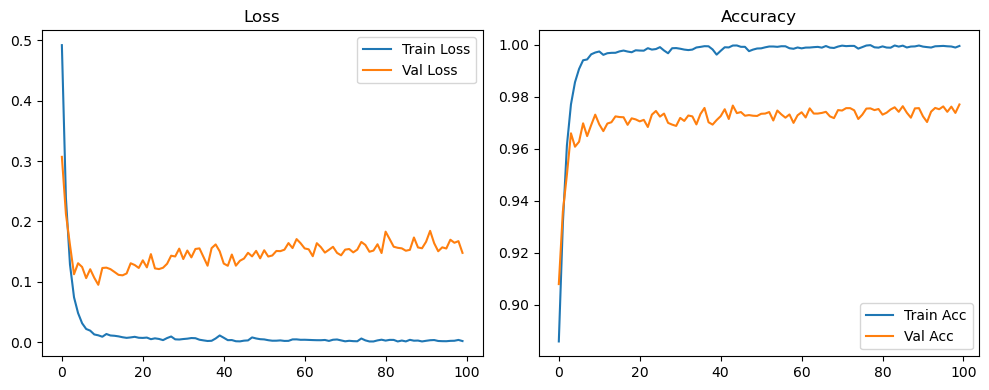

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6540, Acc: 0.8342 | Val Loss: 0.3342, Acc: 0.9031


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3597, Acc: 0.8916 | Val Loss: 0.2760, Acc: 0.9160


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2933, Acc: 0.9115 | Val Loss: 0.2295, Acc: 0.9314


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2343, Acc: 0.9279 | Val Loss: 0.1836, Acc: 0.9432


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2071, Acc: 0.9366 | Val Loss: 0.1705, Acc: 0.9486


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1803, Acc: 0.9445 | Val Loss: 0.1645, Acc: 0.9509


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1639, Acc: 0.9491 | Val Loss: 0.1534, Acc: 0.9560


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1464, Acc: 0.9555 | Val Loss: 0.1512, Acc: 0.9542


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1315, Acc: 0.9579 | Val Loss: 0.1422, Acc: 0.9578


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1204, Acc: 0.9609 | Val Loss: 0.1349, Acc: 0.9594


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1126, Acc: 0.9645 | Val Loss: 0.1332, Acc: 0.9607


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1083, Acc: 0.9658 | Val Loss: 0.1284, Acc: 0.9633


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0956, Acc: 0.9692 | Val Loss: 0.1298, Acc: 0.9625


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0917, Acc: 0.9700 | Val Loss: 0.1326, Acc: 0.9637


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0823, Acc: 0.9731 | Val Loss: 0.1240, Acc: 0.9653


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0757, Acc: 0.9750 | Val Loss: 0.1262, Acc: 0.9643


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0755, Acc: 0.9756 | Val Loss: 0.1227, Acc: 0.9666


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0695, Acc: 0.9772 | Val Loss: 0.1265, Acc: 0.9663


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9788 | Val Loss: 0.1244, Acc: 0.9667


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9788 | Val Loss: 0.1256, Acc: 0.9672


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9797 | Val Loss: 0.1228, Acc: 0.9681


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9801 | Val Loss: 0.1277, Acc: 0.9666


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9818 | Val Loss: 0.1256, Acc: 0.9667


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.1225, Acc: 0.9692


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9823 | Val Loss: 0.1268, Acc: 0.9667


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9829 | Val Loss: 0.1261, Acc: 0.9684


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9846 | Val Loss: 0.1321, Acc: 0.9671


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9850 | Val Loss: 0.1337, Acc: 0.9685


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9850 | Val Loss: 0.1360, Acc: 0.9692


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9854 | Val Loss: 0.1295, Acc: 0.9697


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 0.1294, Acc: 0.9696


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1314, Acc: 0.9688


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9867 | Val Loss: 0.1351, Acc: 0.9689


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.1302, Acc: 0.9701


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9876 | Val Loss: 0.1325, Acc: 0.9688


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.1340, Acc: 0.9687


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9886 | Val Loss: 0.1339, Acc: 0.9686


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9892 | Val Loss: 0.1332, Acc: 0.9699


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9896 | Val Loss: 0.1438, Acc: 0.9679


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.1391, Acc: 0.9692


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9895 | Val Loss: 0.1426, Acc: 0.9694


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.1421, Acc: 0.9702


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1389, Acc: 0.9705


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9904 | Val Loss: 0.1371, Acc: 0.9702


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9910 | Val Loss: 0.1435, Acc: 0.9702


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.1354, Acc: 0.9715


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9908 | Val Loss: 0.1456, Acc: 0.9698


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.1529, Acc: 0.9692


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1465, Acc: 0.9697


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.1444, Acc: 0.9693


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1414, Acc: 0.9716


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9910 | Val Loss: 0.1408, Acc: 0.9701


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.1351, Acc: 0.9713


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1427, Acc: 0.9703


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.1393, Acc: 0.9720


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1444, Acc: 0.9703


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.1485, Acc: 0.9702


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.1470, Acc: 0.9708


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.1467, Acc: 0.9711


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.1520, Acc: 0.9700


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1498, Acc: 0.9708


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9924 | Val Loss: 0.1502, Acc: 0.9708


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.1430, Acc: 0.9699


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1424, Acc: 0.9707


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1455, Acc: 0.9723


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.1451, Acc: 0.9708


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.1516, Acc: 0.9714


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1505, Acc: 0.9714


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1474, Acc: 0.9707


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.1426, Acc: 0.9723


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1449, Acc: 0.9712


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1448, Acc: 0.9722


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1437, Acc: 0.9721


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1560, Acc: 0.9703


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.1566, Acc: 0.9717


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.1527, Acc: 0.9728


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1538, Acc: 0.9714


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1526, Acc: 0.9717


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1484, Acc: 0.9728


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1521, Acc: 0.9714


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1564, Acc: 0.9704


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1465, Acc: 0.9726


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1597, Acc: 0.9718


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.1535, Acc: 0.9708


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9944 | Val Loss: 0.1591, Acc: 0.9716


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1563, Acc: 0.9705


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1507, Acc: 0.9730


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.1587, Acc: 0.9710


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1599, Acc: 0.9712


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1503, Acc: 0.9713


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.1565, Acc: 0.9713


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.1634, Acc: 0.9711


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1560, Acc: 0.9721


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1501, Acc: 0.9719


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1593, Acc: 0.9708


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1533, Acc: 0.9728


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1510, Acc: 0.9722


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1595, Acc: 0.9704


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.1551, Acc: 0.9722


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1536, Acc: 0.9721


Final Test Loss: 0.1374 Accuracy: 0.9739


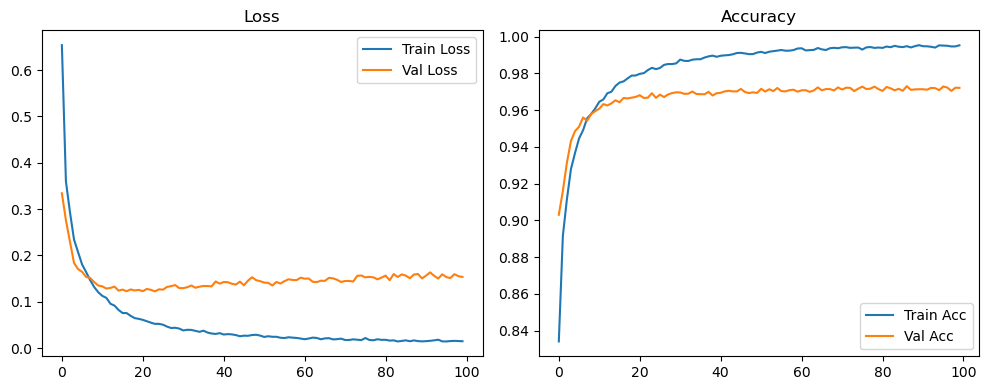

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 1.0601, Acc: 0.6695 | Val Loss: 0.4235, Acc: 0.8838


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.5978, Acc: 0.8156 | Val Loss: 0.3463, Acc: 0.8998


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.5092, Acc: 0.8454 | Val Loss: 0.3156, Acc: 0.9077


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.4485, Acc: 0.8654 | Val Loss: 0.2909, Acc: 0.9158


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.4038, Acc: 0.8791 | Val Loss: 0.2658, Acc: 0.9204


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3708, Acc: 0.8895 | Val Loss: 0.2497, Acc: 0.9266


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.3447, Acc: 0.8988 | Val Loss: 0.2347, Acc: 0.9293


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.3173, Acc: 0.9053 | Val Loss: 0.2253, Acc: 0.9332


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.3006, Acc: 0.9102 | Val Loss: 0.2131, Acc: 0.9360


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2787, Acc: 0.9175 | Val Loss: 0.1955, Acc: 0.9425


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2637, Acc: 0.9213 | Val Loss: 0.1899, Acc: 0.9435


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.2532, Acc: 0.9242 | Val Loss: 0.1772, Acc: 0.9461


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.2387, Acc: 0.9277 | Val Loss: 0.1745, Acc: 0.9477


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.2269, Acc: 0.9321 | Val Loss: 0.1660, Acc: 0.9510


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.2168, Acc: 0.9348 | Val Loss: 0.1618, Acc: 0.9527


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.2112, Acc: 0.9355 | Val Loss: 0.1594, Acc: 0.9533


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1983, Acc: 0.9407 | Val Loss: 0.1518, Acc: 0.9568


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1898, Acc: 0.9440 | Val Loss: 0.1474, Acc: 0.9580


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1821, Acc: 0.9447 | Val Loss: 0.1493, Acc: 0.9573


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1734, Acc: 0.9467 | Val Loss: 0.1400, Acc: 0.9598


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1718, Acc: 0.9477 | Val Loss: 0.1387, Acc: 0.9607


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1658, Acc: 0.9495 | Val Loss: 0.1341, Acc: 0.9616


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1598, Acc: 0.9514 | Val Loss: 0.1289, Acc: 0.9632


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1511, Acc: 0.9538 | Val Loss: 0.1368, Acc: 0.9610


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1511, Acc: 0.9529 | Val Loss: 0.1320, Acc: 0.9640


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1493, Acc: 0.9544 | Val Loss: 0.1267, Acc: 0.9647


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1453, Acc: 0.9545 | Val Loss: 0.1349, Acc: 0.9635


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1332, Acc: 0.9587 | Val Loss: 0.1275, Acc: 0.9652


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1374, Acc: 0.9574 | Val Loss: 0.1285, Acc: 0.9643


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1315, Acc: 0.9586 | Val Loss: 0.1226, Acc: 0.9667


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1330, Acc: 0.9584 | Val Loss: 0.1216, Acc: 0.9657


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1299, Acc: 0.9593 | Val Loss: 0.1281, Acc: 0.9650


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1237, Acc: 0.9620 | Val Loss: 0.1244, Acc: 0.9653


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1204, Acc: 0.9614 | Val Loss: 0.1222, Acc: 0.9657


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1181, Acc: 0.9626 | Val Loss: 0.1205, Acc: 0.9669


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1110, Acc: 0.9650 | Val Loss: 0.1155, Acc: 0.9681


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.1145, Acc: 0.9650 | Val Loss: 0.1242, Acc: 0.9667


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.1117, Acc: 0.9641 | Val Loss: 0.1161, Acc: 0.9684


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.1085, Acc: 0.9663 | Val Loss: 0.1214, Acc: 0.9664


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.1070, Acc: 0.9670 | Val Loss: 0.1250, Acc: 0.9670


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.1090, Acc: 0.9662 | Val Loss: 0.1171, Acc: 0.9688


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.1022, Acc: 0.9676 | Val Loss: 0.1186, Acc: 0.9686


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.1029, Acc: 0.9690 | Val Loss: 0.1200, Acc: 0.9676


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.1015, Acc: 0.9676 | Val Loss: 0.1180, Acc: 0.9692


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.1001, Acc: 0.9676 | Val Loss: 0.1176, Acc: 0.9688


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0995, Acc: 0.9679 | Val Loss: 0.1166, Acc: 0.9683


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0943, Acc: 0.9702 | Val Loss: 0.1168, Acc: 0.9692


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0932, Acc: 0.9697 | Val Loss: 0.1208, Acc: 0.9689


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9706 | Val Loss: 0.1160, Acc: 0.9697


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0905, Acc: 0.9709 | Val Loss: 0.1155, Acc: 0.9708


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0880, Acc: 0.9724 | Val Loss: 0.1129, Acc: 0.9715


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0876, Acc: 0.9723 | Val Loss: 0.1166, Acc: 0.9703


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0867, Acc: 0.9722 | Val Loss: 0.1130, Acc: 0.9704


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0833, Acc: 0.9736 | Val Loss: 0.1153, Acc: 0.9707


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0885, Acc: 0.9717 | Val Loss: 0.1183, Acc: 0.9700


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0847, Acc: 0.9729 | Val Loss: 0.1131, Acc: 0.9708


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0874, Acc: 0.9723 | Val Loss: 0.1163, Acc: 0.9689


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0809, Acc: 0.9735 | Val Loss: 0.1151, Acc: 0.9707


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0813, Acc: 0.9740 | Val Loss: 0.1126, Acc: 0.9711


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0806, Acc: 0.9748 | Val Loss: 0.1128, Acc: 0.9710


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9760 | Val Loss: 0.1142, Acc: 0.9708


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0785, Acc: 0.9748 | Val Loss: 0.1138, Acc: 0.9699


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0813, Acc: 0.9746 | Val Loss: 0.1121, Acc: 0.9713


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0768, Acc: 0.9759 | Val Loss: 0.1139, Acc: 0.9712


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9760 | Val Loss: 0.1176, Acc: 0.9711


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0775, Acc: 0.9753 | Val Loss: 0.1129, Acc: 0.9698


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0754, Acc: 0.9762 | Val Loss: 0.1155, Acc: 0.9710


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9758 | Val Loss: 0.1130, Acc: 0.9711


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9770 | Val Loss: 0.1127, Acc: 0.9723


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0698, Acc: 0.9778 | Val Loss: 0.1144, Acc: 0.9704


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0714, Acc: 0.9771 | Val Loss: 0.1172, Acc: 0.9718


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9771 | Val Loss: 0.1183, Acc: 0.9714


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9775 | Val Loss: 0.1140, Acc: 0.9722


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0714, Acc: 0.9771 | Val Loss: 0.1154, Acc: 0.9709


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9793 | Val Loss: 0.1185, Acc: 0.9713


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9777 | Val Loss: 0.1150, Acc: 0.9714


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9786 | Val Loss: 0.1087, Acc: 0.9725


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9798 | Val Loss: 0.1164, Acc: 0.9710


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0668, Acc: 0.9790 | Val Loss: 0.1147, Acc: 0.9709


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9788 | Val Loss: 0.1140, Acc: 0.9711


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9784 | Val Loss: 0.1161, Acc: 0.9704


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9792 | Val Loss: 0.1182, Acc: 0.9711


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9795 | Val Loss: 0.1174, Acc: 0.9710


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0655, Acc: 0.9796 | Val Loss: 0.1114, Acc: 0.9718


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9805 | Val Loss: 0.1163, Acc: 0.9707


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9805 | Val Loss: 0.1141, Acc: 0.9718


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9797 | Val Loss: 0.1146, Acc: 0.9718


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9796 | Val Loss: 0.1172, Acc: 0.9703


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9800 | Val Loss: 0.1180, Acc: 0.9703


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9802 | Val Loss: 0.1164, Acc: 0.9718


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.1204, Acc: 0.9712


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9803 | Val Loss: 0.1209, Acc: 0.9717


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 0.1139, Acc: 0.9722


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9793 | Val Loss: 0.1171, Acc: 0.9731


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9813 | Val Loss: 0.1208, Acc: 0.9718


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9812 | Val Loss: 0.1233, Acc: 0.9716


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.1148, Acc: 0.9727


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9823 | Val Loss: 0.1161, Acc: 0.9718


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.1228, Acc: 0.9719


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9821 | Val Loss: 0.1167, Acc: 0.9725


Final Test Loss: 0.0997 Accuracy: 0.9759


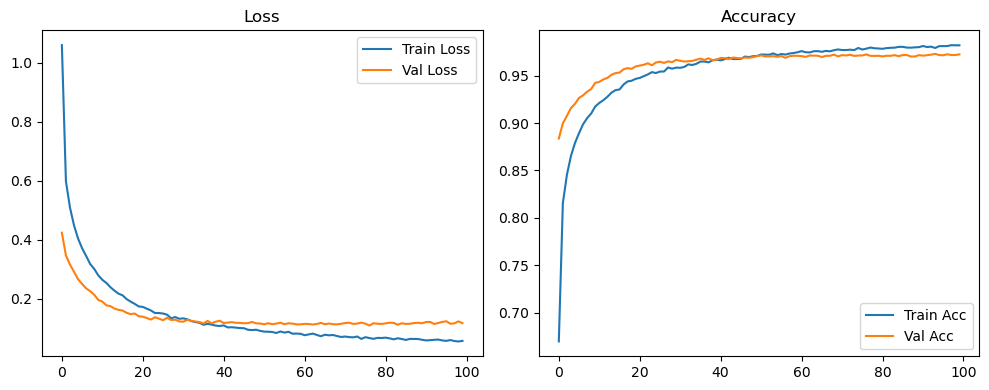

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6167, Acc: 0.8763 | Val Loss: 0.3506, Acc: 0.9063


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2778, Acc: 0.9253 | Val Loss: 0.2306, Acc: 0.9325


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1519, Acc: 0.9559 | Val Loss: 0.1641, Acc: 0.9514


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0848, Acc: 0.9757 | Val Loss: 0.1233, Acc: 0.9614


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9858 | Val Loss: 0.1012, Acc: 0.9671


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9916 | Val Loss: 0.1082, Acc: 0.9652


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9944 | Val Loss: 0.0987, Acc: 0.9698


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9952 | Val Loss: 0.1048, Acc: 0.9665


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9979 | Val Loss: 0.0911, Acc: 0.9729


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9984 | Val Loss: 0.0876, Acc: 0.9735


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9991 | Val Loss: 0.0927, Acc: 0.9731


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1065, Acc: 0.9698


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9986 | Val Loss: 0.0935, Acc: 0.9730


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1041, Acc: 0.9718


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1205, Acc: 0.9667


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9710


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.0975, Acc: 0.9735


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9992 | Val Loss: 0.0989, Acc: 0.9747


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9998 | Val Loss: 0.0891, Acc: 0.9762


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0897, Acc: 0.9758


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1004, Acc: 0.9741


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1211, Acc: 0.9698


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1246, Acc: 0.9681


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1185, Acc: 0.9712


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1115, Acc: 0.9731


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1039, Acc: 0.9747


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0989, Acc: 0.9758


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0946, Acc: 0.9772


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0962, Acc: 0.9774


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0980, Acc: 0.9768


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1486, Acc: 0.9663


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9939 | Val Loss: 0.1451, Acc: 0.9653


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1174, Acc: 0.9732


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1126, Acc: 0.9729


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1080, Acc: 0.9742


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1148, Acc: 0.9742


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1145, Acc: 0.9728


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1094, Acc: 0.9758


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1104, Acc: 0.9744


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1188, Acc: 0.9735


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1507, Acc: 0.9694


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1430, Acc: 0.9710


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1192, Acc: 0.9754


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1126, Acc: 0.9778


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1293, Acc: 0.9736


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1180, Acc: 0.9753


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1273, Acc: 0.9731


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1398, Acc: 0.9706


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1331, Acc: 0.9711


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1277, Acc: 0.9737


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1291, Acc: 0.9721


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1302, Acc: 0.9727


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1180, Acc: 0.9753


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1193, Acc: 0.9754


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1208, Acc: 0.9756


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1284, Acc: 0.9744


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1353, Acc: 0.9732


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.2221, Acc: 0.9584


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1432, Acc: 0.9711


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1300, Acc: 0.9743


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1248, Acc: 0.9746


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1320, Acc: 0.9742


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.1216, Acc: 0.9758


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1231, Acc: 0.9763


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1225, Acc: 0.9758


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1416, Acc: 0.9711


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1666, Acc: 0.9664


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9968 | Val Loss: 0.1337, Acc: 0.9731


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1236, Acc: 0.9751


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1155, Acc: 0.9772


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1175, Acc: 0.9767


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1109, Acc: 0.9781


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1191, Acc: 0.9776


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1265, Acc: 0.9749


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1182, Acc: 0.9787


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1207, Acc: 0.9765


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1433, Acc: 0.9738


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1246, Acc: 0.9778


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1198, Acc: 0.9777


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1534, Acc: 0.9719


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1387, Acc: 0.9732


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1271, Acc: 0.9748


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1192, Acc: 0.9775


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1245, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1249, Acc: 0.9752


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1199, Acc: 0.9773


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1295, Acc: 0.9763


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1205, Acc: 0.9786


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1375, Acc: 0.9756


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1277, Acc: 0.9770


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1194, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1415, Acc: 0.9752


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1434, Acc: 0.9740


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1396, Acc: 0.9748


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1352, Acc: 0.9750


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1358, Acc: 0.9732


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1446, Acc: 0.9742


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1301, Acc: 0.9759


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1291, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1305, Acc: 0.9756


Final Test Loss: 0.1256 Accuracy: 0.9786


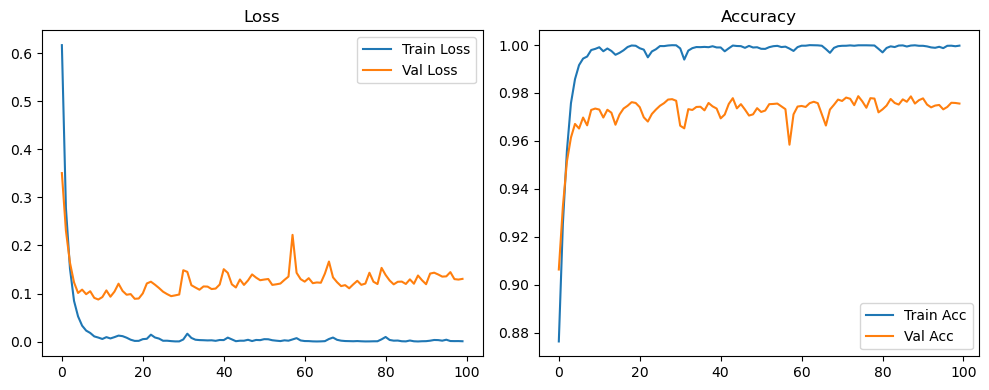

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.8272, Acc: 0.8119 | Val Loss: 0.3962, Acc: 0.8943


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4182, Acc: 0.8828 | Val Loss: 0.3127, Acc: 0.9083


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3355, Acc: 0.9004 | Val Loss: 0.2515, Acc: 0.9233


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2715, Acc: 0.9177 | Val Loss: 0.2039, Acc: 0.9388


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2371, Acc: 0.9279 | Val Loss: 0.1778, Acc: 0.9451


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2110, Acc: 0.9355 | Val Loss: 0.1687, Acc: 0.9481


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1900, Acc: 0.9419 | Val Loss: 0.1619, Acc: 0.9507


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1741, Acc: 0.9466 | Val Loss: 0.1508, Acc: 0.9542


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1589, Acc: 0.9499 | Val Loss: 0.1467, Acc: 0.9557


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1469, Acc: 0.9538 | Val Loss: 0.1341, Acc: 0.9581


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1352, Acc: 0.9580 | Val Loss: 0.1415, Acc: 0.9570


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1307, Acc: 0.9594 | Val Loss: 0.1349, Acc: 0.9603


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1201, Acc: 0.9629 | Val Loss: 0.1277, Acc: 0.9632


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1154, Acc: 0.9629 | Val Loss: 0.1291, Acc: 0.9627


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1072, Acc: 0.9655 | Val Loss: 0.1285, Acc: 0.9617


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0999, Acc: 0.9678 | Val Loss: 0.1259, Acc: 0.9639


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0969, Acc: 0.9691 | Val Loss: 0.1257, Acc: 0.9637


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0925, Acc: 0.9705 | Val Loss: 0.1224, Acc: 0.9655


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0863, Acc: 0.9720 | Val Loss: 0.1205, Acc: 0.9657


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0849, Acc: 0.9729 | Val Loss: 0.1241, Acc: 0.9649


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9739 | Val Loss: 0.1229, Acc: 0.9657


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0776, Acc: 0.9749 | Val Loss: 0.1226, Acc: 0.9658


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9762 | Val Loss: 0.1237, Acc: 0.9662


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0711, Acc: 0.9767 | Val Loss: 0.1197, Acc: 0.9678


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9778 | Val Loss: 0.1235, Acc: 0.9668


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9778 | Val Loss: 0.1182, Acc: 0.9684


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9788 | Val Loss: 0.1280, Acc: 0.9648


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0581, Acc: 0.9805 | Val Loss: 0.1208, Acc: 0.9679


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9809 | Val Loss: 0.1220, Acc: 0.9663


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0557, Acc: 0.9813 | Val Loss: 0.1208, Acc: 0.9680


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9821 | Val Loss: 0.1270, Acc: 0.9662


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9823 | Val Loss: 0.1247, Acc: 0.9688


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9818 | Val Loss: 0.1248, Acc: 0.9682


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9831 | Val Loss: 0.1292, Acc: 0.9675


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9826 | Val Loss: 0.1252, Acc: 0.9666


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9834 | Val Loss: 0.1211, Acc: 0.9684


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0485, Acc: 0.9837 | Val Loss: 0.1277, Acc: 0.9694


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9863 | Val Loss: 0.1259, Acc: 0.9685


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9855 | Val Loss: 0.1288, Acc: 0.9690


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9856 | Val Loss: 0.1296, Acc: 0.9694


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9855 | Val Loss: 0.1305, Acc: 0.9679


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9864 | Val Loss: 0.1242, Acc: 0.9696


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.1323, Acc: 0.9692


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.1252, Acc: 0.9696


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.1286, Acc: 0.9690


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9869 | Val Loss: 0.1264, Acc: 0.9696


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9875 | Val Loss: 0.1252, Acc: 0.9698


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9867 | Val Loss: 0.1330, Acc: 0.9688


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9876 | Val Loss: 0.1279, Acc: 0.9699


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9878 | Val Loss: 0.1282, Acc: 0.9702


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9886 | Val Loss: 0.1292, Acc: 0.9692


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9888 | Val Loss: 0.1291, Acc: 0.9694


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.1292, Acc: 0.9698


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.1340, Acc: 0.9692


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.1249, Acc: 0.9712


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.1313, Acc: 0.9694


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.1234, Acc: 0.9713


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.1272, Acc: 0.9708


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9898 | Val Loss: 0.1425, Acc: 0.9686


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.1341, Acc: 0.9700


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.1358, Acc: 0.9698


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9903 | Val Loss: 0.1315, Acc: 0.9711


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9902 | Val Loss: 0.1339, Acc: 0.9706


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.1350, Acc: 0.9694


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1357, Acc: 0.9702


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.1332, Acc: 0.9693


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.1351, Acc: 0.9698


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.1339, Acc: 0.9698


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.1365, Acc: 0.9703


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9906 | Val Loss: 0.1332, Acc: 0.9709


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.1382, Acc: 0.9687


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.1403, Acc: 0.9705


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9923 | Val Loss: 0.1400, Acc: 0.9686


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9915 | Val Loss: 0.1415, Acc: 0.9688


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.1435, Acc: 0.9688


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1369, Acc: 0.9697


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1379, Acc: 0.9709


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1403, Acc: 0.9700


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9920 | Val Loss: 0.1461, Acc: 0.9683


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.1386, Acc: 0.9691


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1369, Acc: 0.9710


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.1397, Acc: 0.9703


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.1408, Acc: 0.9701


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.1458, Acc: 0.9698


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.1499, Acc: 0.9692


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1445, Acc: 0.9701


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1426, Acc: 0.9698


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1470, Acc: 0.9697


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.1499, Acc: 0.9691


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1407, Acc: 0.9705


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1385, Acc: 0.9710


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1526, Acc: 0.9694


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.1491, Acc: 0.9716


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9916 | Val Loss: 0.1428, Acc: 0.9706


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1428, Acc: 0.9702


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1486, Acc: 0.9701


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.1488, Acc: 0.9701


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.1487, Acc: 0.9690


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1479, Acc: 0.9702


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.1458, Acc: 0.9708


Final Test Loss: 0.1282 Accuracy: 0.9748


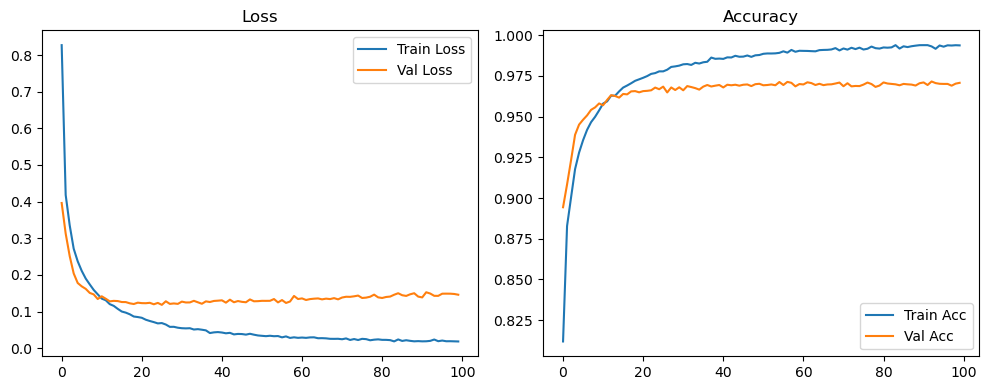

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.3071, Acc: 0.5985 | Val Loss: 0.5570, Acc: 0.8750


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.7209, Acc: 0.7809 | Val Loss: 0.4065, Acc: 0.8880


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.5989, Acc: 0.8168 | Val Loss: 0.3498, Acc: 0.8993


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.5295, Acc: 0.8395 | Val Loss: 0.3249, Acc: 0.9044


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.4782, Acc: 0.8560 | Val Loss: 0.3022, Acc: 0.9099


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.4441, Acc: 0.8664 | Val Loss: 0.2918, Acc: 0.9140


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.4217, Acc: 0.8747 | Val Loss: 0.2807, Acc: 0.9157


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3978, Acc: 0.8819 | Val Loss: 0.2713, Acc: 0.9207


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.3788, Acc: 0.8885 | Val Loss: 0.2629, Acc: 0.9208


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.3584, Acc: 0.8936 | Val Loss: 0.2501, Acc: 0.9258


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.3419, Acc: 0.8985 | Val Loss: 0.2454, Acc: 0.9271


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.3327, Acc: 0.9005 | Val Loss: 0.2352, Acc: 0.9307


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.3184, Acc: 0.9054 | Val Loss: 0.2305, Acc: 0.9313


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.3086, Acc: 0.9077 | Val Loss: 0.2230, Acc: 0.9337


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2932, Acc: 0.9130 | Val Loss: 0.2168, Acc: 0.9347


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2879, Acc: 0.9133 | Val Loss: 0.2056, Acc: 0.9383


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.2753, Acc: 0.9174 | Val Loss: 0.2036, Acc: 0.9400


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.2629, Acc: 0.9229 | Val Loss: 0.1986, Acc: 0.9417


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.2559, Acc: 0.9230 | Val Loss: 0.1950, Acc: 0.9444


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.2480, Acc: 0.9266 | Val Loss: 0.1889, Acc: 0.9445


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.2417, Acc: 0.9275 | Val Loss: 0.1813, Acc: 0.9473


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.2379, Acc: 0.9301 | Val Loss: 0.1778, Acc: 0.9478


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.2303, Acc: 0.9311 | Val Loss: 0.1711, Acc: 0.9487


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.2202, Acc: 0.9340 | Val Loss: 0.1766, Acc: 0.9486


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.2146, Acc: 0.9343 | Val Loss: 0.1696, Acc: 0.9511


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.2101, Acc: 0.9366 | Val Loss: 0.1640, Acc: 0.9510


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.2065, Acc: 0.9372 | Val Loss: 0.1704, Acc: 0.9515


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1936, Acc: 0.9410 | Val Loss: 0.1622, Acc: 0.9533


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1971, Acc: 0.9402 | Val Loss: 0.1556, Acc: 0.9546


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1905, Acc: 0.9431 | Val Loss: 0.1592, Acc: 0.9557


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1857, Acc: 0.9445 | Val Loss: 0.1522, Acc: 0.9564


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1864, Acc: 0.9434 | Val Loss: 0.1551, Acc: 0.9560


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1776, Acc: 0.9468 | Val Loss: 0.1498, Acc: 0.9577


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1714, Acc: 0.9481 | Val Loss: 0.1472, Acc: 0.9577


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1681, Acc: 0.9484 | Val Loss: 0.1449, Acc: 0.9596


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1645, Acc: 0.9507 | Val Loss: 0.1442, Acc: 0.9602


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1654, Acc: 0.9505 | Val Loss: 0.1443, Acc: 0.9602


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1591, Acc: 0.9513 | Val Loss: 0.1430, Acc: 0.9607


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1550, Acc: 0.9517 | Val Loss: 0.1428, Acc: 0.9614


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1550, Acc: 0.9527 | Val Loss: 0.1419, Acc: 0.9622


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1535, Acc: 0.9533 | Val Loss: 0.1401, Acc: 0.9617


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1506, Acc: 0.9535 | Val Loss: 0.1389, Acc: 0.9618


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1458, Acc: 0.9561 | Val Loss: 0.1381, Acc: 0.9629


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1461, Acc: 0.9546 | Val Loss: 0.1361, Acc: 0.9628


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1392, Acc: 0.9568 | Val Loss: 0.1328, Acc: 0.9647


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1409, Acc: 0.9571 | Val Loss: 0.1358, Acc: 0.9632


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1404, Acc: 0.9582 | Val Loss: 0.1355, Acc: 0.9640


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1329, Acc: 0.9596 | Val Loss: 0.1382, Acc: 0.9642


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1336, Acc: 0.9590 | Val Loss: 0.1352, Acc: 0.9621


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.1319, Acc: 0.9591 | Val Loss: 0.1332, Acc: 0.9635


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1255, Acc: 0.9614 | Val Loss: 0.1343, Acc: 0.9643


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.1253, Acc: 0.9610 | Val Loss: 0.1394, Acc: 0.9635


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.1263, Acc: 0.9596 | Val Loss: 0.1322, Acc: 0.9653


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.1205, Acc: 0.9621 | Val Loss: 0.1304, Acc: 0.9645


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.1237, Acc: 0.9611 | Val Loss: 0.1318, Acc: 0.9643


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.1194, Acc: 0.9639 | Val Loss: 0.1289, Acc: 0.9660


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.1192, Acc: 0.9628 | Val Loss: 0.1331, Acc: 0.9643


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.1180, Acc: 0.9629 | Val Loss: 0.1281, Acc: 0.9668


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.1152, Acc: 0.9636 | Val Loss: 0.1298, Acc: 0.9643


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.1162, Acc: 0.9638 | Val Loss: 0.1291, Acc: 0.9662


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.1108, Acc: 0.9657 | Val Loss: 0.1330, Acc: 0.9656


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.1110, Acc: 0.9652 | Val Loss: 0.1306, Acc: 0.9658


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.1110, Acc: 0.9654 | Val Loss: 0.1291, Acc: 0.9671


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.1073, Acc: 0.9657 | Val Loss: 0.1272, Acc: 0.9672


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.1019, Acc: 0.9672 | Val Loss: 0.1281, Acc: 0.9663


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.1070, Acc: 0.9659 | Val Loss: 0.1301, Acc: 0.9664


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.1052, Acc: 0.9659 | Val Loss: 0.1284, Acc: 0.9672


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.1026, Acc: 0.9679 | Val Loss: 0.1268, Acc: 0.9677


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.1014, Acc: 0.9679 | Val Loss: 0.1287, Acc: 0.9670


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.1026, Acc: 0.9674 | Val Loss: 0.1305, Acc: 0.9668


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.1018, Acc: 0.9675 | Val Loss: 0.1304, Acc: 0.9677


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9691 | Val Loss: 0.1287, Acc: 0.9663


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.1005, Acc: 0.9690 | Val Loss: 0.1217, Acc: 0.9678


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9686 | Val Loss: 0.1247, Acc: 0.9673


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0949, Acc: 0.9700 | Val Loss: 0.1258, Acc: 0.9675


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0938, Acc: 0.9703 | Val Loss: 0.1237, Acc: 0.9684


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0919, Acc: 0.9719 | Val Loss: 0.1246, Acc: 0.9682


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0892, Acc: 0.9717 | Val Loss: 0.1279, Acc: 0.9676


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0927, Acc: 0.9698 | Val Loss: 0.1255, Acc: 0.9669


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0899, Acc: 0.9720 | Val Loss: 0.1245, Acc: 0.9685


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9702 | Val Loss: 0.1258, Acc: 0.9672


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0932, Acc: 0.9707 | Val Loss: 0.1279, Acc: 0.9681


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0883, Acc: 0.9715 | Val Loss: 0.1267, Acc: 0.9687


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0888, Acc: 0.9714 | Val Loss: 0.1253, Acc: 0.9686


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0921, Acc: 0.9705 | Val Loss: 0.1271, Acc: 0.9672


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9732 | Val Loss: 0.1250, Acc: 0.9688


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0872, Acc: 0.9724 | Val Loss: 0.1274, Acc: 0.9687


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0879, Acc: 0.9727 | Val Loss: 0.1194, Acc: 0.9699


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0863, Acc: 0.9720 | Val Loss: 0.1268, Acc: 0.9685


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0831, Acc: 0.9732 | Val Loss: 0.1249, Acc: 0.9699


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0824, Acc: 0.9738 | Val Loss: 0.1279, Acc: 0.9684


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9740 | Val Loss: 0.1329, Acc: 0.9677


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0822, Acc: 0.9742 | Val Loss: 0.1254, Acc: 0.9686


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0835, Acc: 0.9731 | Val Loss: 0.1283, Acc: 0.9678


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9745 | Val Loss: 0.1275, Acc: 0.9684


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0781, Acc: 0.9744 | Val Loss: 0.1248, Acc: 0.9703


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0823, Acc: 0.9748 | Val Loss: 0.1242, Acc: 0.9695


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9751 | Val Loss: 0.1278, Acc: 0.9679


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0791, Acc: 0.9751 | Val Loss: 0.1269, Acc: 0.9688


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0765, Acc: 0.9752 | Val Loss: 0.1235, Acc: 0.9695


Final Test Loss: 0.1129 Accuracy: 0.9718


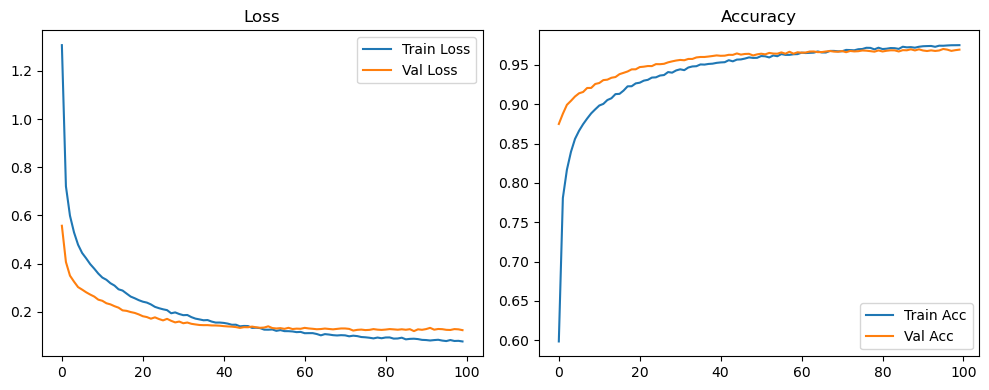

🏆 Best Config: batch64_lr0.01_0.005_0.001_dp0.2 Accuracy: 0.9833


In [8]:
root_path = "MLP_256_4bit_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)